# Fine-tune Phi 2 using QLoRA

In [1]:
# Install and import the necessary libraries
!pip install torch
!pip install -q -U accelerate peft bitsandbytes transformers trl einops evaluate
# !pip install -q -U tqdm
# !pip install -q -U git+https://github.com/sissa-data-science/DADApy

In [2]:
import os
import torch
from datasets import load_dataset
from datasets import load_from_disk
from peft import LoraConfig, prepare_model_for_kbit_training, PeftModel
from transformers import (
    AutoModelForCausalLM,
    AutoTokenizer,
    BitsAndBytesConfig,
    HfArgumentParser,
    AutoTokenizer,
    TrainingArguments,
    pipeline,
    logging,
)
from tqdm import tqdm
from trl import SFTTrainer

2024-05-30 15:58:02.314256: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-05-30 15:58:02.314374: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-05-30 15:58:02.429835: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [3]:
# Model
base_model = "microsoft/phi-2"
new_model = "phi-2-medquad"

# Dataset
dataset = load_dataset("prsdm/MedQuad-phi2-1k", split="train")

# Tokenizer
tokenizer = AutoTokenizer.from_pretrained(base_model, use_fast=True)
tokenizer.pad_token=tokenizer.eos_token
tokenizer.padding_side="right"

Generating train split:   0%|          | 0/1000 [00:00<?, ? examples/s]

tokenizer_config.json:   0%|          | 0.00/7.34k [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/798k [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/2.11M [00:00<?, ?B/s]

added_tokens.json:   0%|          | 0.00/1.08k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/99.0 [00:00<?, ?B/s]

Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.


In [13]:
def print_number_of_trainable_model_parameters(model):
    trainable_model_params = 0
    all_model_params = 0
    for _, param in model.named_parameters():
        all_model_params += param.numel()
        if param.requires_grad:
            trainable_model_params += param.numel()
    return f"trainable model parameters: {trainable_model_params}\nall model parameters: {all_model_params}\npercentage of trainable model parameters: {100 * trainable_model_params / all_model_params:.2f}%"

## Intrinsic dimentions of base model phi2 on medQuad.

In [6]:
# samples = 250 train, 100 test
train_dataset = dataset.select(range(800))
test_dataset = dataset.select(range(800,1000))

In [7]:
# Function that tokenizes the text
def tokenize(rows):
    # Retrieve Text
    if rows["text"][0] is None:
        text = ""
    else:
        text = rows["text"][0].replace('"', r'\"')

    # Tokenize
    encoded = tokenizer(
          text,
          add_special_tokens=True,
          max_length=260,
          return_token_type_ids=False,
          return_attention_mask=True,
          return_tensors='pt',
        ).to("cuda")
    return encoded

In [8]:
# Applying tokenization to the dataset
tokenized_dataset = train_dataset.map(tokenize,
                                batched=True,
                                batch_size=1,
                                remove_columns=["text"])

Map:   0%|          | 0/800 [00:00<?, ? examples/s]

Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.


In [ ]:
normal_model = AutoModelForCausalLM.from_pretrained(
    base_model,
    device_map={"": 0},
)

Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

In [ ]:
# computing intrinsic dimentions before finetuning
# Constants
from tqdm import tqdm
import gc
torch.cuda.empty_cache()
gc.collect()
num_data = 250
per_batch = 50
number_batches = num_data // per_batch

# Collect hidden layers
hidden_layers = []

# Collect hidden layers per batch
for batch in tqdm(range(number_batches)):
    for i in range(per_batch):
        # Extract inputs from the dataset using the tokenizer
        inputs = {k: torch.tensor(v).unsqueeze(0).to("cuda") for k, v in tokenized_dataset[batch * per_batch + i].items()}

        # Perform forward pass through the model
        with torch.no_grad():
            outputs = normal_model(**inputs, output_hidden_states=True)

        # Append the hidden states to the list
        liste = list(map(lambda x: x.to('cpu'), outputs.hidden_states))
        del outputs
        torch.cuda.empty_cache()
        gc.collect()
        hidden_layers.append(liste)
del liste

100%|██████████| 5/5 [03:13<00:00, 38.76s/it]


In [ ]:
len(hidden_layers[249])

33

In [ ]:
# Move back to CPU
torch.set_default_device("cpu")

# Process hidden layers
hidden_layers_avg = []

for j in range(33):
    avg_batch_layer = []
    for i in range(number_batches * per_batch):
        layer = hidden_layers[i][j].detach().cpu()
        avg_batch_layer.append(torch.mean(layer.squeeze(dim=0), dim=0))
    hidden_layers_avg.append(avg_batch_layer)

# Handle empty tensors
for layer in hidden_layers_avg:
    for idx, tensor in enumerate(layer):
        if tensor.shape == torch.Size([]):
            print("Encountered empty tensor. Filling with zeros.")
            layer[idx] = torch.zeros(2560)


# Stack hidden layers
hidden_layers_stacked = [torch.stack(layer) for layer in hidden_layers_avg]
hidden_layers_stacked = torch.stack(hidden_layers_stacked)

In [ ]:
# Assuming 'phi2_model' is your loaded model
embedding_size = normal_model.config.hidden_size
print(f"Embedding size for phi2 model: {embedding_size}")

Embedding size for phi2 model: 2560


In [ ]:
gc.collect()

22301

In [ ]:
import matplotlib.pyplot as plt
from dadapy.data import Data
import numpy as np

In [ ]:
len(hidden_layers_stacked)

33

No identical identical points were found
No identical identical points were found
Intrinsic dimension for layer 0: 13.038541154569742
No identical identical points were found
No identical identical points were found
Intrinsic dimension for layer 1: 13.67312334964858
No identical identical points were found
No identical identical points were found
Intrinsic dimension for layer 2: 14.24142693403802
No identical identical points were found
No identical identical points were found
Intrinsic dimension for layer 3: 13.37564809912871
No identical identical points were found
No identical identical points were found
Intrinsic dimension for layer 4: 12.849894912600835
No identical identical points were found
No identical identical points were found
Intrinsic dimension for layer 5: 11.956869564525753
No identical identical points were found
No identical identical points were found
Intrinsic dimension for layer 6: 10.942497139069395
No identical identical points were found
No identical identical p

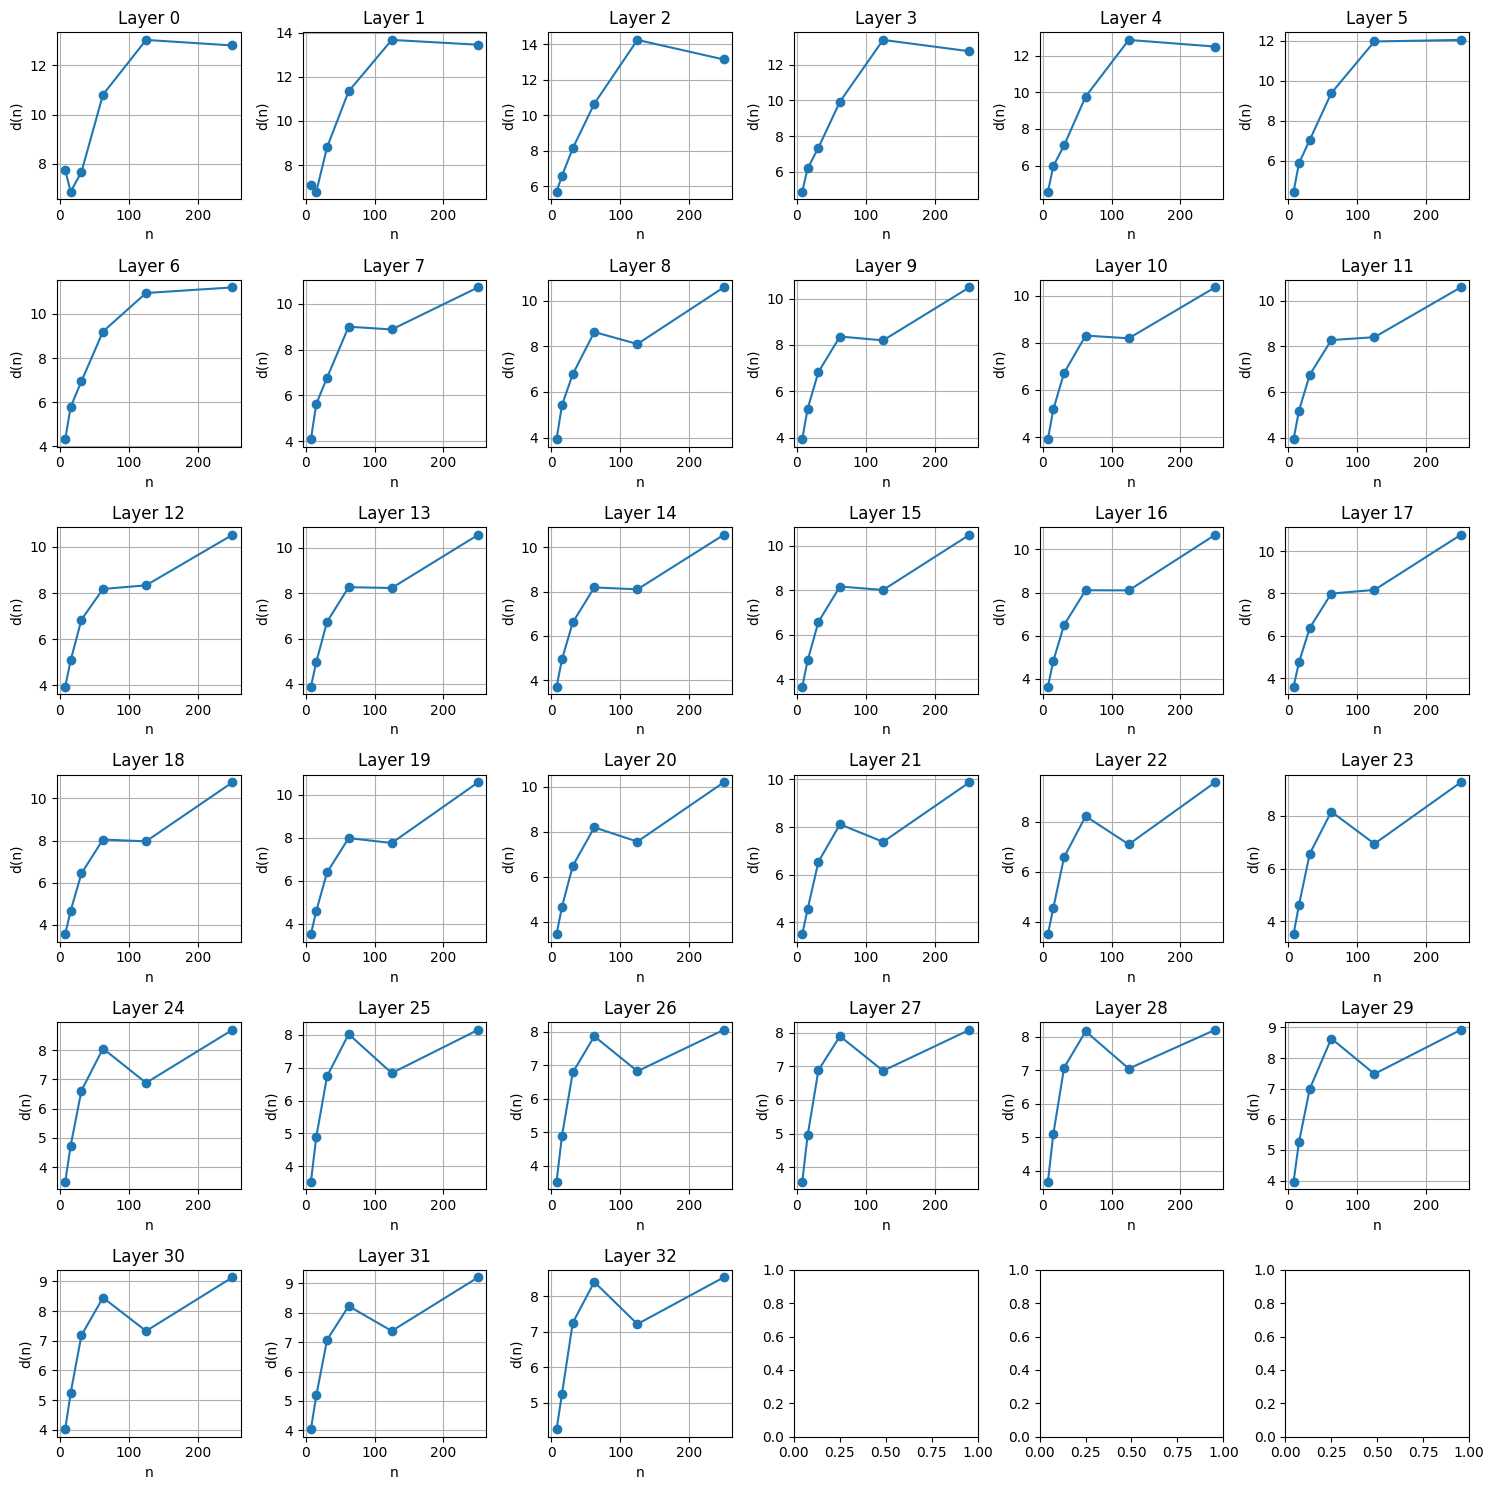

In [ ]:

# Compute intrinsic dimensions
intrinsic_dims = []

# Check which id to pick
fig, axes = plt.subplots(6, 6, figsize=(15, 15))

# # Flatten the axes array for easy iteration
axes = axes.flatten()

# n = len(id_list_2NN)
# ax = axes[i]
# ax.plot([per_batch * number_batches / 2**i for i in range(n)], id_list_2NN,  marker='o')
# ax.set_title(f'Figure {i+1}')
# ax.set_xlabel('n')
# ax.set_ylabel('d(n)')
# ax.grid(True)
# plt.tight_layout()
# plt.show()
# plt.savefig('ids_n.png')

for i in range(0, 33):
    X = hidden_layers_stacked[i].numpy()
    data = Data(X)
    data.remove_identical_points()
    data.remove_identical_points()
    #id_list_2NN, _, _ = data.return_id_scaling_2NN()
    id_list_2NN, _, _ = data.return_id_scaling_gride()
    n = len(id_list_2NN)
    ax = axes[i]
    ax.plot([per_batch * number_batches / 2**j for j in range(n)], id_list_2NN,  marker='o')
    ax.set_title(f'Layer {i}')
    intrinsic_dims.append(id_list_2NN[1])
    print(f"Intrinsic dimension for layer {i}: {id_list_2NN[1]}")
    ax.set_xlabel('n')
    ax.set_ylabel('d(n)')
    ax.grid(True)

plt.tight_layout()
plt.savefig('ids_n.png')
plt.show()


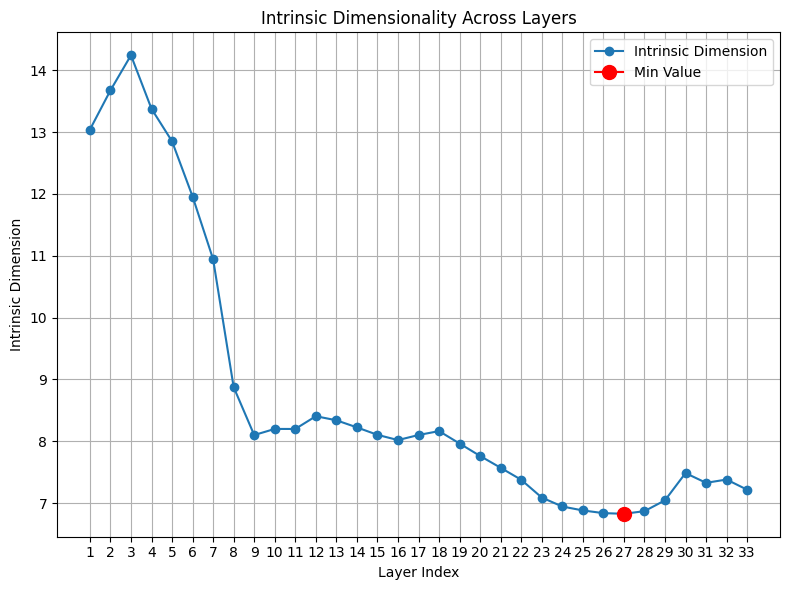

In [ ]:
# Plot results
# Find the index of the minimum value
min_index = intrinsic_dims.index(min(intrinsic_dims)) + 1

# Plot results
plt.figure(figsize=(8, 6))
plt.plot(np.arange(1, 34), intrinsic_dims, marker='o', linestyle='-', label='Intrinsic Dimension')
plt.plot(min_index, min(intrinsic_dims), marker='o', color='red', markersize=10, label='Min Value')
plt.title('Intrinsic Dimensionality Across Layers')
plt.xlabel('Layer Index')
plt.ylabel('Intrinsic Dimension')
plt.grid(True)
plt.xticks(np.arange(1, 34))
plt.legend()
plt.tight_layout()
plt.savefig("optimizing_layer4.png")
plt.show()


In [ ]:
intrinsic_dims

[13.038541154569742,
 13.67312334964858,
 14.24142693403802,
 13.37564809912871,
 12.849894912600835,
 11.956869564525753,
 10.942497139069395,
 8.873846494516446,
 8.09909189381203,
 8.198273108629714,
 8.19762816839173,
 8.404009568413866,
 8.338216641961449,
 8.223261457848508,
 8.102856179479016,
 8.017943627143012,
 8.099834273576938,
 8.163210653195417,
 7.962214736990835,
 7.7607312156983825,
 7.569553408672596,
 7.375930591295154,
 7.088577235432603,
 6.943829886857157,
 6.879999604352779,
 6.836669341030152,
 6.825771422613557,
 6.868200224793081,
 7.043714307723131,
 7.484154298985582,
 7.326697844227746,
 7.379606692444038,
 7.215366898289678]

In [ ]:
import pickle
# File path to save the pickle file
file_path = 'intrinsic_dims.pkl'

# Save the list to a pickle file
with open(file_path, 'wb') as file:
    pickle.dump(intrinsic_dims, file)

print(f'Intrinsic dimensions saved to {file_path}')

Intrinsic dimensions saved to intrinsic_dims.pkl


## QLoRA model loading

In [4]:
# Quantization configuration
bnb_config = BitsAndBytesConfig(
    load_in_4bit=True,
    bnb_4bit_quant_type="nf4",
    bnb_4bit_compute_dtype=torch.float16,
    bnb_4bit_use_double_quant=False,
)

In [5]:
# Load base moodel
model = AutoModelForCausalLM.from_pretrained(
    base_model,
    quantization_config=bnb_config,
    trust_remote_code=True,
    low_cpu_mem_usage=True,
    device_map={"": 0},
    revision="refs/pr/23" #the main version of Phi-2 doesn’t support gradient checkpointing (while training this model)
)

config.json:   0%|          | 0.00/755 [00:00<?, ?B/s]

configuration_phi.py:   0%|          | 0.00/2.03k [00:00<?, ?B/s]

modeling_phi.py:   0%|          | 0.00/33.7k [00:00<?, ?B/s]

model.safetensors.index.json:   0%|          | 0.00/24.3k [00:00<?, ?B/s]

model-00001-of-00002.safetensors:   0%|          | 0.00/4.98G [00:00<?, ?B/s]

model-00002-of-00002.safetensors:   0%|          | 0.00/577M [00:00<?, ?B/s]

Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

generation_config.json:   0%|          | 0.00/69.0 [00:00<?, ?B/s]

In [6]:
model.config.use_cache = False
model.config.pretraining_tp = 1
model = prepare_model_for_kbit_training(model, use_gradient_checkpointing=True)

You are using an old version of the checkpointing format that is deprecated (We will also silently ignore `gradient_checkpointing_kwargs` in case you passed it).Please update to the new format on your modeling file. To use the new format, you need to completely remove the definition of the method `_set_gradient_checkpointing` in your model.


## QLoRA

In [9]:
def find_target_modules(model):
    unique_layers = set()

    for name, module in model.named_modules():
        if "Linear" in str(type(module)):
            layer_type = name.split('.')[-1]
            unique_layers.add(layer_type)
    return list(unique_layers)

In [10]:
find_target_modules(model)

['linear', 'out_proj', 'fc1', 'Wqkv', 'fc2']

In [5]:
train_dataset = dataset.select(range(250))
test_dataset = dataset.select(range(990,1000))

## Rank = 1, training samples = 250, testing samples = 100, target modules = all unique layers

In [8]:
# Set training arguments
# rank = 1
training_arguments = TrainingArguments(
    output_dir = "./results",
    report_to="none",
    num_train_epochs = 1,
    fp16 = False,
    bf16 = False,
    per_device_train_batch_size = 1,
    per_device_eval_batch_size = 1,
    gradient_accumulation_steps = 1,
    gradient_checkpointing = True,
    max_grad_norm = 0.3,
    learning_rate = 2e-4,
    weight_decay = 0.001,
    optim = "paged_adamw_32bit",
    lr_scheduler_type = "cosine",
    max_steps = -1,
    warmup_ratio = 0.03,
    group_by_length = True,
    save_steps = 0,
    logging_steps = 50,
)

In [9]:
# LoRA configuration
# alpha/rank = 8
peft_config = LoraConfig(
    r=1,                   #default=8
    lora_alpha= 8,
    lora_dropout=0.05,
    bias="none",
    task_type="CAUSAL_LM",
    target_modules= ['fc2', 'Wqkv', 'out_proj', 'fc1']
)
#print_trainable_parameters(model)

In [10]:
# Set supervised fine-tuning parameters
trainer = SFTTrainer(
    model=model,
    train_dataset=train_dataset,
    peft_config=peft_config,
    dataset_text_field="text",
    max_seq_length= None,
    tokenizer=tokenizer,
    args=training_arguments,
)

You are using an old version of the checkpointing format that is deprecated (We will also silently ignore `gradient_checkpointing_kwargs` in case you passed it).Please update to the new format on your modeling file. To use the new format, you need to completely remove the definition of the method `_set_gradient_checkpointing` in your model.
/opt/conda/lib/python3.10/site-packages/trl/trainer/sft_trainer.py:246: UserWarning: You didn't pass a `max_seq_length` argument to the SFTTrainer, this will default to 1024
  warnings.warn(


Map:   0%|          | 0/250 [00:00<?, ? examples/s]

In [14]:
print(print_number_of_trainable_model_parameters(model))

trainable model parameters: 1310720
all model parameters: 1522703360
percentage of trainable model parameters: 0.09%


In [11]:
# Training the model and getting the training output
train_output = trainer.train()

Step,Training Loss
50,1.243100
100,1.220400
150,1.188400
200,1.150000
250,1.103300


In [12]:
# Extracting training time from train_output
training_time = train_output.metrics['train_runtime']

In [13]:
print(training_time)

656.9473


In [21]:
torch.cuda.empty_cache()

In [12]:
# Save trained model
trainer.model.save_pretrained(f"{new_model}_rank_{peft_config.r}")

/opt/conda/lib/python3.10/site-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


config.json:   0%|          | 0.00/735 [00:00<?, ?B/s]

You are using a model of type phi to instantiate a model of type phi-msft. This is not supported for all configurations of models and can yield errors.


In [13]:
model

PhiForCausalLM(
  (transformer): PhiModel(
    (embd): Embedding(
      (wte): Embedding(51200, 2560)
      (drop): Dropout(p=0.0, inplace=False)
    )
    (h): ModuleList(
      (0-31): 32 x ParallelBlock(
        (ln): LayerNorm((2560,), eps=1e-05, elementwise_affine=True)
        (resid_dropout): Dropout(p=0.1, inplace=False)
        (mixer): MHA(
          (rotary_emb): RotaryEmbedding()
          (Wqkv): lora.Linear4bit(
            (base_layer): Linear4bit(in_features=2560, out_features=7680, bias=True)
            (lora_dropout): ModuleDict(
              (default): Dropout(p=0.05, inplace=False)
            )
            (lora_A): ModuleDict(
              (default): Linear(in_features=2560, out_features=1, bias=False)
            )
            (lora_B): ModuleDict(
              (default): Linear(in_features=1, out_features=7680, bias=False)
            )
            (lora_embedding_A): ParameterDict()
            (lora_embedding_B): ParameterDict()
          )
          (out_

In [16]:
details_save_path = os.path.join("./results/saved_model", "training_details.txt")
# Ensure the directory exists
os.makedirs("./results/saved_model", exist_ok=True)
with open(details_save_path, "w") as f:
    f.write(f"Model name: {new_model}_rank_{peft_config.r}\n")
    f.write(f"Training time: {training_time:.2f} seconds\n")

In [17]:
save_path = f'/kaggle/working/{new_model}_rank_{peft_config.r}.pt'

# Save the model state dictionary
torch.save(model.state_dict(), save_path)

In [14]:
new_model = AutoModelForCausalLM.from_pretrained("/kaggle/working/phi-2-medquad_rank_1")
new_model

model.safetensors.index.json:   0%|          | 0.00/35.7k [00:00<?, ?B/s]

model-00001-of-00002.safetensors:   0%|          | 0.00/5.00G [00:00<?, ?B/s]

model-00002-of-00002.safetensors:   0%|          | 0.00/564M [00:00<?, ?B/s]

Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

generation_config.json:   0%|          | 0.00/124 [00:00<?, ?B/s]

Loading adapter weights from /kaggle/working/phi-2-medquad_rank_1 led to unexpected keys not found in the model:  ['transformer.h.0.mixer.Wqkv.lora_A.default.weight', 'transformer.h.0.mixer.Wqkv.lora_B.default.weight', 'transformer.h.0.mixer.out_proj.lora_A.default.weight', 'transformer.h.0.mixer.out_proj.lora_B.default.weight', 'transformer.h.0.mlp.fc1.lora_A.default.weight', 'transformer.h.0.mlp.fc1.lora_B.default.weight', 'transformer.h.0.mlp.fc2.lora_A.default.weight', 'transformer.h.0.mlp.fc2.lora_B.default.weight', 'transformer.h.1.mixer.Wqkv.lora_A.default.weight', 'transformer.h.1.mixer.Wqkv.lora_B.default.weight', 'transformer.h.1.mixer.out_proj.lora_A.default.weight', 'transformer.h.1.mixer.out_proj.lora_B.default.weight', 'transformer.h.1.mlp.fc1.lora_A.default.weight', 'transformer.h.1.mlp.fc1.lora_B.default.weight', 'transformer.h.1.mlp.fc2.lora_A.default.weight', 'transformer.h.1.mlp.fc2.lora_B.default.weight', 'transformer.h.10.mixer.Wqkv.lora_A.default.weight', 'transfo

PhiForCausalLM(
  (model): PhiModel(
    (embed_tokens): Embedding(51200, 2560)
    (embed_dropout): Dropout(p=0.0, inplace=False)
    (layers): ModuleList(
      (0-31): 32 x PhiDecoderLayer(
        (self_attn): PhiSdpaAttention(
          (q_proj): Linear(in_features=2560, out_features=2560, bias=True)
          (k_proj): Linear(in_features=2560, out_features=2560, bias=True)
          (v_proj): Linear(in_features=2560, out_features=2560, bias=True)
          (dense): Linear(in_features=2560, out_features=2560, bias=True)
          (rotary_emb): PhiRotaryEmbedding()
        )
        (mlp): PhiMLP(
          (activation_fn): NewGELUActivation()
          (fc1): lora.Linear(
            (base_layer): Linear(in_features=2560, out_features=10240, bias=True)
            (lora_dropout): ModuleDict(
              (default): Dropout(p=0.05, inplace=False)
            )
            (lora_A): ModuleDict(
              (default): Linear(in_features=2560, out_features=1, bias=False)
          

## Inference

In [ ]:
# Reload model and merge it with LoRA parameters
finetuned_model = AutoModelForCausalLM.from_pretrained(
    base_model,
    torch_dtype=torch.float16,
    trust_remote_code=True,
    cache_dir="",
    device_map={"": 0},
)
model = PeftModel.from_pretrained(model, new_model)
model = model.merge_and_unload()

In [ ]:
# #Check training results with tensorboard
# %load_ext tensorboard
# %tensorboard --logdir results/runs

In [ ]:
# Clear the memory
# del model, pipe, trainer

In [ ]:
# # Run text generation pipeline with our model
# logging.set_verbosity(logging.CRITICAL)

# prompt = "What are the treatments for Gastrointestinal Carcinoid Tumors?"
# instruction = f"### Instruction: {prompt} "
# pipe = pipeline(task="text-generation", model=model, tokenizer=tokenizer, max_length=200)
# result = pipe(instruction)
# print(result[0]['generated_text'][len(instruction):])

In [31]:
for prompt in test_dataset.select(range(1)):
  # Extract the instruction part
  instruction = prompt["text"].split('### Instruction: ')[1].split('### Assistant: ')[0]
  print(instruction)

What are the symptoms of Schwannomatosis ? 


In [37]:
for prompt in test_dataset.select(range(1)):
  print(prompt["text"])

### Instruction: What are the symptoms of Schwannomatosis ? ### Assistant: What are the signs and symptoms of Schwannomatosis? Signs and symptoms of the schwannomatosis often develop during adulthood between ages 25 and 30. Affected people generally have multiple schwannomas, which are benign tumors of the nervous system. In schwannomatosis, these tumors can grow along any nerve in the body, although they are less common on the vestibular nerve (vestibular schwannomas, also known as acoustic neuromas). People with vestibular schwannomas, especially those with tumors affecting the vestibular nerve on both sides of the head (bilateral), may have neurofibromatosis type 2 instead. The signs and symptoms associated with schwannomatosis vary based on the size and location of the schwannomas. The most common symptom is chronic pain, which can develop as a growing schwannoma presses on nerves or surrounding tissues. Some people may develop a mass if the schwannomas is located just beneath the 

In [12]:
model.eval()

PhiForCausalLM(
  (transformer): PhiModel(
    (embd): Embedding(
      (wte): Embedding(51200, 2560)
      (drop): Dropout(p=0.0, inplace=False)
    )
    (h): ModuleList(
      (0-31): 32 x ParallelBlock(
        (ln): LayerNorm((2560,), eps=1e-05, elementwise_affine=True)
        (resid_dropout): Dropout(p=0.1, inplace=False)
        (mixer): MHA(
          (rotary_emb): RotaryEmbedding()
          (Wqkv): lora.Linear4bit(
            (base_layer): Linear4bit(in_features=2560, out_features=7680, bias=True)
            (lora_dropout): ModuleDict(
              (default): Dropout(p=0.05, inplace=False)
            )
            (lora_A): ModuleDict(
              (default): Linear(in_features=2560, out_features=1, bias=False)
            )
            (lora_B): ModuleDict(
              (default): Linear(in_features=1, out_features=7680, bias=False)
            )
            (lora_embedding_A): ParameterDict()
            (lora_embedding_B): ParameterDict()
          )
          (out_

In [13]:
import time

# Initializing the text-generation pipeline
# pipelines - easy way to use models for inference
pipe = pipeline(task="text-generation", model=model, tokenizer=tokenizer, max_new_tokens=256)

# List to store results
results = []

# generating 10 results
for i in range(10):
    start_time = time.time()
    
    # Iterating over the testing dataset and generating predictions
    for prompt in test_dataset.select(range(1)):
        # Extract the instruction part
        instruction = prompt["text"].split('### Instruction: ')[1].split('### Assistant: ')[0]
        result = pipe(f"### Instruction: {instruction}")
        generated_text = result[0]['generated_text']
        results.append({
            "prompt": instruction,
            "generated_text": generated_text
        })
        
    end_time = time.time()
    elapsed_time = start_time - end_time
    
    # Printing the required result
    # print(f"Prompt: {results[-1]['prompt']}")
    print(f"{results[-1]['generated_text']}")
    print(f"\n{elapsed_time:.2f} s\n")

### Instruction: What are the symptoms of Schwannomatosis ?  ### Assistant: Signs and symptoms of Schwannomatosis may include:
                
- Abnormal bone growth
- Abnormal bone shape
- Abnormal bone size
- Abnormal bone texture
- Abnormal bone structure
- Abnormality of the spine
- Abnormality of the skull
- Abnormality of the pelvis
- Abnormality of the ribs
- Abnormality of the hands
- Abnormality of the feet
- Abnormality of the fingers
- Abnormality of the toes
- Abnormality of the nails
- Abnormality of the skin
- Abnormality of the hair
- Abnormality of the teeth
- Abnormality of the eyes
- Abnormality of the ears
- Abnormality of the tongue
- Abnormality of the voice
- Abnormality of the genitals
- Abnormality of the anus
- Abnormality of the rectum
- Abnormality of the vagina
- Abnormality of the uterus
- Abnormality of the bladder
- Abnormality of the kidneys
- Abnormality of the liver
- Abnormality of the gallbladder
- Abnormality

-21.94 s

### Instruction: What are th

In [15]:
# Reload model and merge it with LoRA parameters
model = AutoModelForCausalLM.from_pretrained(
    base_model,
    torch_dtype=torch.float16,
    trust_remote_code=True,
    cache_dir="",
    device_map={"": 0},
)
model = PeftModel.from_pretrained(model, "/kaggle/working/phi-2-medquad_rank_1")
model = model.merge_and_unload()

config.json:   0%|          | 0.00/735 [00:00<?, ?B/s]

model.safetensors.index.json:   0%|          | 0.00/35.7k [00:00<?, ?B/s]

model-00001-of-00002.safetensors:   0%|          | 0.00/5.00G [00:00<?, ?B/s]

model-00002-of-00002.safetensors:   0%|          | 0.00/564M [00:00<?, ?B/s]

Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

generation_config.json:   0%|          | 0.00/124 [00:00<?, ?B/s]

In [ ]:
# # Reload tokenizer to save it
# tokenizer = AutoTokenizer.from_pretrained(base_model, trust_remote_code=True)
# tokenizer.pad_token = tokenizer.eos_token
# tokenizer.padding_side = "right"

In [ ]:
# !huggingface-cli login

In [ ]:
# model.push_to_hub(new_model, use_temp_dir=False)
# tokenizer.push_to_hub(new_model, use_temp_dir=False)

## Rank = 64, training samples = 250, testing samples = 100, target modules = all unique layers

In [6]:
model = AutoModelForCausalLM.from_pretrained(
    base_model,
    quantization_config=bnb_config,
    trust_remote_code=True,
    low_cpu_mem_usage=True,
    device_map={"": 0},
    revision="refs/pr/23" #the main version of Phi-2 doesn’t support gradient checkpointing (while training this model)
)

config.json:   0%|          | 0.00/755 [00:00<?, ?B/s]

configuration_phi.py:   0%|          | 0.00/2.03k [00:00<?, ?B/s]

modeling_phi.py:   0%|          | 0.00/33.7k [00:00<?, ?B/s]

model.safetensors.index.json:   0%|          | 0.00/24.3k [00:00<?, ?B/s]

model-00001-of-00002.safetensors:   0%|          | 0.00/4.98G [00:00<?, ?B/s]

model-00002-of-00002.safetensors:   0%|          | 0.00/577M [00:00<?, ?B/s]

Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

generation_config.json:   0%|          | 0.00/69.0 [00:00<?, ?B/s]

In [7]:
model.config.use_cache = False
model.config.pretraining_tp = 1
model = prepare_model_for_kbit_training(model, use_gradient_checkpointing=True)

You are using an old version of the checkpointing format that is deprecated (We will also silently ignore `gradient_checkpointing_kwargs` in case you passed it).Please update to the new format on your modeling file. To use the new format, you need to completely remove the definition of the method `_set_gradient_checkpointing` in your model.


In [8]:
# Set training arguments
# rank = 64
training_arguments = TrainingArguments(
    output_dir = "./results",
    report_to="none",
    num_train_epochs = 1,
    fp16 = False,
    bf16 = False,
    per_device_train_batch_size = 1,
    per_device_eval_batch_size = 1,
    gradient_accumulation_steps = 1,
    gradient_checkpointing = True,
    max_grad_norm = 0.3,
    learning_rate = 2e-4,
    weight_decay = 0.001,
    optim = "paged_adamw_32bit",
    lr_scheduler_type = "cosine",
    max_steps = -1,
    warmup_ratio = 0.03,
    group_by_length = True,
    save_steps = 0,
    logging_steps = 50,
)

In [10]:
find_target_modules(model)


model
model.embed_tokens
model.embed_dropout
model.layers
model.layers.0
model.layers.0.self_attn
model.layers.0.self_attn.q_proj
model.layers.0.self_attn.k_proj
model.layers.0.self_attn.v_proj
model.layers.0.self_attn.dense
model.layers.0.self_attn.rotary_emb
model.layers.0.mlp
model.layers.0.mlp.activation_fn
model.layers.0.mlp.fc1
model.layers.0.mlp.fc2
model.layers.0.input_layernorm
model.layers.0.resid_dropout
model.layers.1
model.layers.1.self_attn
model.layers.1.self_attn.q_proj
model.layers.1.self_attn.k_proj
model.layers.1.self_attn.v_proj
model.layers.1.self_attn.dense
model.layers.1.self_attn.rotary_emb
model.layers.1.mlp
model.layers.1.mlp.activation_fn
model.layers.1.mlp.fc1
model.layers.1.mlp.fc2
model.layers.1.input_layernorm
model.layers.1.resid_dropout
model.layers.2
model.layers.2.self_attn
model.layers.2.self_attn.q_proj
model.layers.2.self_attn.k_proj
model.layers.2.self_attn.v_proj
model.layers.2.self_attn.dense
model.layers.2.self_attn.rotary_emb
model.layers.2.m

['dense', 'k_proj', 'v_proj', 'lm_head', 'fc1', 'q_proj', 'fc2']

In [9]:
# LoRA configuration
# alpha/rank = 8
peft_config = LoraConfig(
    r=64,                   #default=8
    lora_alpha= 512,
    lora_dropout=0.05,
    bias="none",
    task_type="CAUSAL_LM",
    target_modules= ['fc2', 'Wqkv', 'out_proj', 'fc1']
#     target_modules= ['dense', 'k_proj', 'v_proj', 'fc1', 'q_proj', 'fc2']

)
#print_trainable_parameters(model)

In [10]:
# Set supervised fine-tuning parameters
trainer = SFTTrainer(
    model=model,
    train_dataset=train_dataset,
    peft_config=peft_config,
    dataset_text_field="text",
    max_seq_length= None,
    tokenizer=tokenizer,
    args=training_arguments,
)

You are using an old version of the checkpointing format that is deprecated (We will also silently ignore `gradient_checkpointing_kwargs` in case you passed it).Please update to the new format on your modeling file. To use the new format, you need to completely remove the definition of the method `_set_gradient_checkpointing` in your model.
/opt/conda/lib/python3.10/site-packages/trl/trainer/sft_trainer.py:246: UserWarning: You didn't pass a `max_seq_length` argument to the SFTTrainer, this will default to 1024
  warnings.warn(


Map:   0%|          | 0/250 [00:00<?, ? examples/s]

In [13]:
print(print_number_of_trainable_model_parameters(model))

trainable model parameters: 83886080
all model parameters: 1605278720
percentage of trainable model parameters: 5.23%


In [11]:
# Training the model and getting the training output
train_output = trainer.train()

Step,Training Loss
50,1.223900
100,1.132800
150,1.116900
200,1.050400
250,0.982800


In [12]:
# Extracting training time from train_output
training_time = train_output.metrics['train_runtime']

In [13]:
print(training_time)

677.1375


In [16]:
# Save trained model
trainer.model.save_pretrained(f"{new_model}_rank_{peft_config.r}")

/opt/conda/lib/python3.10/site-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


config.json:   0%|          | 0.00/735 [00:00<?, ?B/s]

You are using a model of type phi to instantiate a model of type phi-msft. This is not supported for all configurations of models and can yield errors.


In [17]:
details_save_path = os.path.join("./results/saved_model", "training_details.txt")
# Ensure the directory exists
os.makedirs("./results/saved_model", exist_ok=True)
with open(details_save_path, "w") as f:
    f.write(f"Model name: {new_model}_rank_{peft_config.r}\n")
    f.write(f"Training time: {training_time:.2f} seconds\n")

In [18]:
save_path = f'/kaggle/working/{new_model}_rank_{peft_config.r}.pt'

# Save the model state dictionary
torch.save(model.state_dict(), save_path)

In [20]:
# Reload model and merge it with LoRA parameters
model = AutoModelForCausalLM.from_pretrained(
    base_model,
    torch_dtype=torch.float16,
    trust_remote_code=True,
    cache_dir="",
    device_map={"": 0},
)
model = PeftModel.from_pretrained(model, f"{new_model}_rank_{peft_config.r}")
model = model.merge_and_unload()

Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

In [21]:
model

PhiForCausalLM(
  (model): PhiModel(
    (embed_tokens): Embedding(51200, 2560)
    (embed_dropout): Dropout(p=0.0, inplace=False)
    (layers): ModuleList(
      (0-31): 32 x PhiDecoderLayer(
        (self_attn): PhiSdpaAttention(
          (q_proj): Linear(in_features=2560, out_features=2560, bias=True)
          (k_proj): Linear(in_features=2560, out_features=2560, bias=True)
          (v_proj): Linear(in_features=2560, out_features=2560, bias=True)
          (dense): Linear(in_features=2560, out_features=2560, bias=True)
          (rotary_emb): PhiRotaryEmbedding()
        )
        (mlp): PhiMLP(
          (activation_fn): NewGELUActivation()
          (fc1): Linear(in_features=2560, out_features=10240, bias=True)
          (fc2): Linear(in_features=10240, out_features=2560, bias=True)
        )
        (input_layernorm): LayerNorm((2560,), eps=1e-05, elementwise_affine=True)
        (resid_dropout): Dropout(p=0.1, inplace=False)
      )
    )
    (final_layernorm): LayerNorm((256

In [ ]:
new_model

## Inference

In [ ]:
# #Check training results with tensorboard
# %load_ext tensorboard
# %tensorboard --logdir results/runs

In [ ]:
# Clear the memory
# del model, pipe, trainer

In [ ]:
# # Run text generation pipeline with our model
# logging.set_verbosity(logging.CRITICAL)

# prompt = "What are the treatments for Gastrointestinal Carcinoid Tumors?"
# instruction = f"### Instruction: {prompt} "
# pipe = pipeline(task="text-generation", model=model, tokenizer=tokenizer, max_length=200)
# result = pipe(instruction)
# print(result[0]['generated_text'][len(instruction):])

In [14]:
model.eval()

PhiForCausalLM(
  (transformer): PhiModel(
    (embd): Embedding(
      (wte): Embedding(51200, 2560)
      (drop): Dropout(p=0.0, inplace=False)
    )
    (h): ModuleList(
      (0-31): 32 x ParallelBlock(
        (ln): LayerNorm((2560,), eps=1e-05, elementwise_affine=True)
        (resid_dropout): Dropout(p=0.1, inplace=False)
        (mixer): MHA(
          (rotary_emb): RotaryEmbedding()
          (Wqkv): lora.Linear4bit(
            (base_layer): Linear4bit(in_features=2560, out_features=7680, bias=True)
            (lora_dropout): ModuleDict(
              (default): Dropout(p=0.05, inplace=False)
            )
            (lora_A): ModuleDict(
              (default): Linear(in_features=2560, out_features=64, bias=False)
            )
            (lora_B): ModuleDict(
              (default): Linear(in_features=64, out_features=7680, bias=False)
            )
            (lora_embedding_A): ParameterDict()
            (lora_embedding_B): ParameterDict()
          )
          (ou

In [19]:
for prompt in test_dataset.select(range(1)):
  # Extract the instruction part
  instruction = prompt["text"].split('### Instruction: ')[1].split('### Assistant: ')[0]
  print(instruction)

What are the symptoms of Schwannomatosis ? 


In [ ]:
for prompt in test_dataset.select(range(1)):
  print(prompt["text"])

### Instruction: What are the symptoms of Schwannomatosis ? ### Assistant: What are the signs and symptoms of Schwannomatosis? Signs and symptoms of the schwannomatosis often develop during adulthood between ages 25 and 30. Affected people generally have multiple schwannomas, which are benign tumors of the nervous system. In schwannomatosis, these tumors can grow along any nerve in the body, although they are less common on the vestibular nerve (vestibular schwannomas, also known as acoustic neuromas). People with vestibular schwannomas, especially those with tumors affecting the vestibular nerve on both sides of the head (bilateral), may have neurofibromatosis type 2 instead. The signs and symptoms associated with schwannomatosis vary based on the size and location of the schwannomas. The most common symptom is chronic pain, which can develop as a growing schwannoma presses on nerves or surrounding tissues. Some people may develop a mass if the schwannomas is located just beneath the 

In [15]:
import time
# Initializing the text-generation pipeline
# pipelines - easy way to use models for inference
pipe = pipeline(task="text-generation", model=model, tokenizer=tokenizer, max_new_tokens=256)

# List to store results
results = []

# generating 10 results
for i in range(10):
    start_time = time.time()
    
    # Iterating over the testing dataset and generating predictions
    for prompt in test_dataset.select(range(1)):
        # Extract the instruction part
        instruction = prompt["text"].split('### Instruction: ')[1].split('### Assistant: ')[0]
        result = pipe(f"### Instruction: {instruction}")
        generated_text = result[0]['generated_text']
        results.append({
            "prompt": instruction,
            "generated_text": generated_text
        })
        
    end_time = time.time()
    elapsed_time = end_time - start_time

    # Printing the required result
    # print(f"Prompt: {results[-1]['prompt']}")
    print(f"{results[-1]['generated_text']}")
    print(f"\n{elapsed_time:.2f} s\n")

### Instruction: What are the symptoms of Schwannomatosis ?  ### Assistant: What are the signs and symptoms of Schwannomatosis? The signs and symptoms of Schwannomatosis vary depending on the type of the disease. The most common symptoms include: Pain in the arms, legs, trunk, and/or neck. Weakness in the arms, legs, trunk, and/or neck. Numbness in the arms, legs, trunk, and/or neck. Loss of sensation in the arms, legs, trunk, and/or neck. Loss of muscle mass in the arms, legs, trunk, and/or neck. Loss of muscle strength in the arms, legs, trunk, and/or neck. Loss of muscle coordination in the arms, legs, trunk, and/or neck. Loss of reflexes in the arms, legs, trunk, and/or neck. Loss of sensation in the arms, legs, trunk, and/or neck. Loss of muscle mass in the arms, legs, trunk, and/or neck. Loss of muscle strength in the arms, legs, trunk, and/or neck. Loss of muscle coordination in the arms, legs, trunk, and/or neck. Loss of reflexes in the arms, legs, trunk, and/or neck. Loss of



## Rank = 14, training samples = 250, testing samples = 100, target modules = all unique layers

In [6]:
model = AutoModelForCausalLM.from_pretrained(
    base_model,
    quantization_config=bnb_config,
    trust_remote_code=True,
    low_cpu_mem_usage=True,
    device_map={"": 0},
    revision="refs/pr/23" #the main version of Phi-2 doesn’t support gradient checkpointing (while training this model)
)

config.json:   0%|          | 0.00/755 [00:00<?, ?B/s]

configuration_phi.py:   0%|          | 0.00/2.03k [00:00<?, ?B/s]

modeling_phi.py:   0%|          | 0.00/33.7k [00:00<?, ?B/s]

model.safetensors.index.json:   0%|          | 0.00/24.3k [00:00<?, ?B/s]

model-00001-of-00002.safetensors:   0%|          | 0.00/4.98G [00:00<?, ?B/s]

model-00002-of-00002.safetensors:   0%|          | 0.00/577M [00:00<?, ?B/s]

Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

generation_config.json:   0%|          | 0.00/69.0 [00:00<?, ?B/s]

In [7]:
model.config.use_cache = False
model.config.pretraining_tp = 1
model = prepare_model_for_kbit_training(model, use_gradient_checkpointing=True)

You are using an old version of the checkpointing format that is deprecated (We will also silently ignore `gradient_checkpointing_kwargs` in case you passed it).Please update to the new format on your modeling file. To use the new format, you need to completely remove the definition of the method `_set_gradient_checkpointing` in your model.


In [8]:
# Set training arguments
# rank = 14
training_arguments = TrainingArguments(
    output_dir = "./results",
    report_to="none",
    num_train_epochs = 1,
    fp16 = False,
    bf16 = False,
    per_device_train_batch_size = 1,
    per_device_eval_batch_size = 1,
    gradient_accumulation_steps = 1,
    gradient_checkpointing = True,
    max_grad_norm = 0.3,
    learning_rate = 2e-4,
    weight_decay = 0.001,
    optim = "paged_adamw_32bit",
    lr_scheduler_type = "cosine",
    max_steps = -1,
    warmup_ratio = 0.03,
    group_by_length = True,
    save_steps = 0,
    logging_steps = 50,
)

In [9]:
# LoRA configuration
# alpha/rank = 8
peft_config = LoraConfig(
    r=14,                   #default=8
    lora_alpha= 112,
    lora_dropout=0.05,
    bias="none",
    task_type="CAUSAL_LM",
    target_modules= ['fc2', 'Wqkv', 'out_proj', 'fc1']
)
#print_trainable_parameters(model)

In [10]:
# Set supervised fine-tuning parameters
trainer = SFTTrainer(
    model=model,
    train_dataset=train_dataset,
    peft_config=peft_config,
    dataset_text_field="text",
    max_seq_length= None,
    tokenizer=tokenizer,
    args=training_arguments,
)

You are using an old version of the checkpointing format that is deprecated (We will also silently ignore `gradient_checkpointing_kwargs` in case you passed it).Please update to the new format on your modeling file. To use the new format, you need to completely remove the definition of the method `_set_gradient_checkpointing` in your model.
/opt/conda/lib/python3.10/site-packages/trl/trainer/sft_trainer.py:246: UserWarning: You didn't pass a `max_seq_length` argument to the SFTTrainer, this will default to 1024
  warnings.warn(


Map:   0%|          | 0/250 [00:00<?, ? examples/s]

In [12]:
print(print_number_of_trainable_model_parameters(model))

trainable model parameters: 18350080
all model parameters: 1539742720
percentage of trainable model parameters: 1.19%


In [11]:
# Training the model and getting the training output
train_output = trainer.train()

Step,Training Loss
50,1.211200
100,1.137800
150,1.110100
200,1.071300
250,1.011100


In [12]:
# Extracting training time from train_output
training_time = train_output.metrics['train_runtime']

In [13]:
print(training_time)

668.1049


In [15]:
# Save trained model
trainer.model.save_pretrained(f"{new_model}_rank_{peft_config.r}")

/opt/conda/lib/python3.10/site-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


config.json:   0%|          | 0.00/735 [00:00<?, ?B/s]

You are using a model of type phi to instantiate a model of type phi-msft. This is not supported for all configurations of models and can yield errors.


In [16]:
details_save_path = os.path.join("./results/saved_model", "training_details.txt")
# Ensure the directory exists
os.makedirs("./results/saved_model", exist_ok=True)
with open(details_save_path, "w") as f:
    f.write(f"Model name: {new_model}_rank_{peft_config.r}\n")
    f.write(f"Training time: {training_time:.2f} seconds\n")

In [17]:
save_path = f'/kaggle/working/{new_model}_rank_{peft_config.r}.pt'

# Save the model state dictionary
torch.save(model.state_dict(), save_path)

## Inference

In [ ]:
# #Check training results with tensorboard
# %load_ext tensorboard
# %tensorboard --logdir results/runs

In [ ]:
# Clear the memory
# del model, pipe, trainer

In [ ]:
# # Run text generation pipeline with our model
# logging.set_verbosity(logging.CRITICAL)

# prompt = "What are the treatments for Gastrointestinal Carcinoid Tumors?"
# instruction = f"### Instruction: {prompt} "
# pipe = pipeline(task="text-generation", model=model, tokenizer=tokenizer, max_length=200)
# result = pipe(instruction)
# print(result[0]['generated_text'][len(instruction):])

In [ ]:
for prompt in test_dataset.select(range(1)):
  # Extract the instruction part
  instruction = prompt["text"].split('### Instruction: ')[1].split('### Assistant: ')[0]
  print(instruction)

What are the symptoms of Schwannomatosis ? 


In [ ]:
for prompt in test_dataset.select(range(1)):
  print(prompt["text"])

### Instruction: What are the symptoms of Schwannomatosis ? ### Assistant: What are the signs and symptoms of Schwannomatosis? Signs and symptoms of the schwannomatosis often develop during adulthood between ages 25 and 30. Affected people generally have multiple schwannomas, which are benign tumors of the nervous system. In schwannomatosis, these tumors can grow along any nerve in the body, although they are less common on the vestibular nerve (vestibular schwannomas, also known as acoustic neuromas). People with vestibular schwannomas, especially those with tumors affecting the vestibular nerve on both sides of the head (bilateral), may have neurofibromatosis type 2 instead. The signs and symptoms associated with schwannomatosis vary based on the size and location of the schwannomas. The most common symptom is chronic pain, which can develop as a growing schwannoma presses on nerves or surrounding tissues. Some people may develop a mass if the schwannomas is located just beneath the 

In [14]:
model.eval()

PhiForCausalLM(
  (transformer): PhiModel(
    (embd): Embedding(
      (wte): Embedding(51200, 2560)
      (drop): Dropout(p=0.0, inplace=False)
    )
    (h): ModuleList(
      (0-31): 32 x ParallelBlock(
        (ln): LayerNorm((2560,), eps=1e-05, elementwise_affine=True)
        (resid_dropout): Dropout(p=0.1, inplace=False)
        (mixer): MHA(
          (rotary_emb): RotaryEmbedding()
          (Wqkv): lora.Linear4bit(
            (base_layer): Linear4bit(in_features=2560, out_features=7680, bias=True)
            (lora_dropout): ModuleDict(
              (default): Dropout(p=0.05, inplace=False)
            )
            (lora_A): ModuleDict(
              (default): Linear(in_features=2560, out_features=14, bias=False)
            )
            (lora_B): ModuleDict(
              (default): Linear(in_features=14, out_features=7680, bias=False)
            )
            (lora_embedding_A): ParameterDict()
            (lora_embedding_B): ParameterDict()
          )
          (ou

In [15]:
import time
# Initializing the text-generation pipeline
# pipelines - easy way to use models for inference
pipe = pipeline(task="text-generation", model=model, tokenizer=tokenizer, max_new_tokens=256)

# List to store results
results = []

# generating 10 results
for i in range(10):
    start_time = time.time()
    
    # Iterating over the testing dataset and generating predictions
    for prompt in test_dataset.select(range(1)):
        # Extract the instruction part
        instruction = prompt["text"].split('### Instruction: ')[1].split('### Assistant: ')[0]
        result = pipe(f"### Instruction: {instruction}")
        generated_text = result[0]['generated_text']
        results.append({
            "prompt": instruction,
            "generated_text": generated_text
        })
        
    end_time = time.time()
    elapsed_time = end_time - start_time

    # Printing the required result
    # print(f"Prompt: {results[-1]['prompt']}")
    print(f"{results[-1]['generated_text']}")
    print(f"\n{elapsed_time:.2f} s\n")

### Instruction: What are the symptoms of Schwannomatosis ?  ### Assistant: What are the signs and symptoms of Schwannomatosis? The signs and symptoms of Schwannomatosis vary depending on the type of Schwannomatosis. The most common signs and symptoms of Schwannomatosis are: Pain in the neck, shoulder, arm, leg, or foot. Numbness or tingling in the neck, shoulder, arm, leg, or foot. Muscle weakness in the neck, shoulder, arm, leg, or foot. Abnormal growths on the skin. Abnormal growths on the skin. Abnormal growths on the skin. Abnormal growths on the skin. Abnormal growths on the skin. Abnormal growths on the skin. Abnormal growths on the skin. Abnormal growths on the skin. Abnormal growths on the skin. Abnormal growths on the skin. Abnormal growths on the skin. Abnormal growths on the skin. Abnormal growths on the skin. Abnormal growths on the skin. Abnormal growths on the skin. Abnormal growths on the skin. Abnormal growths on the skin. Abnormal growths on the skin. Abnormal growths

## Rank = Intrinsic dimentions, training samples = 250, testing samples = 100, target modules = all unique layers

In [6]:
import pickle

# Load the pickle file
with open("/kaggle/input/intrinsic-dims/intrinsic_dims.pkl", "rb") as f:
    id = pickle.load(f)

In [7]:
model = AutoModelForCausalLM.from_pretrained(
    base_model,
    quantization_config=bnb_config,
    trust_remote_code=True,
    low_cpu_mem_usage=True,
    device_map={"": 0},
    revision="refs/pr/23" #the main version of Phi-2 doesn’t support gradient checkpointing (while training this model)
)

config.json:   0%|          | 0.00/755 [00:00<?, ?B/s]

configuration_phi.py:   0%|          | 0.00/2.03k [00:00<?, ?B/s]

modeling_phi.py:   0%|          | 0.00/33.7k [00:00<?, ?B/s]

model.safetensors.index.json:   0%|          | 0.00/24.3k [00:00<?, ?B/s]

model-00001-of-00002.safetensors:   0%|          | 0.00/4.98G [00:00<?, ?B/s]

model-00002-of-00002.safetensors:   0%|          | 0.00/577M [00:00<?, ?B/s]

Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

generation_config.json:   0%|          | 0.00/69.0 [00:00<?, ?B/s]

In [9]:
model.config.use_cache = False
model.config.pretraining_tp = 1
model = prepare_model_for_kbit_training(model, use_gradient_checkpointing=True)

You are using an old version of the checkpointing format that is deprecated (We will also silently ignore `gradient_checkpointing_kwargs` in case you passed it).Please update to the new format on your modeling file. To use the new format, you need to completely remove the definition of the method `_set_gradient_checkpointing` in your model.


In [9]:
def find_target_modules(model):
    unique_layers = set()
    
    for name, module in model.named_modules():
        print(name)
        if "Linear" in str(type(module)):
            layer_type = name.split('.')[-1]
            unique_layers.add(layer_type)
    return list(unique_layers)

In [36]:
find_target_modules(model)


model
model.embed_tokens
model.embed_dropout
model.layers
model.layers.0
model.layers.0.self_attn
model.layers.0.self_attn.q_proj
model.layers.0.self_attn.k_proj
model.layers.0.self_attn.v_proj
model.layers.0.self_attn.dense
model.layers.0.self_attn.rotary_emb
model.layers.0.mlp
model.layers.0.mlp.activation_fn
model.layers.0.mlp.fc1
model.layers.0.mlp.fc2
model.layers.0.input_layernorm
model.layers.0.resid_dropout
model.layers.1
model.layers.1.self_attn
model.layers.1.self_attn.q_proj
model.layers.1.self_attn.k_proj
model.layers.1.self_attn.v_proj
model.layers.1.self_attn.dense
model.layers.1.self_attn.rotary_emb
model.layers.1.mlp
model.layers.1.mlp.activation_fn
model.layers.1.mlp.fc1
model.layers.1.mlp.fc2
model.layers.1.input_layernorm
model.layers.1.resid_dropout
model.layers.2
model.layers.2.self_attn
model.layers.2.self_attn.q_proj
model.layers.2.self_attn.k_proj
model.layers.2.self_attn.v_proj
model.layers.2.self_attn.dense
model.layers.2.self_attn.rotary_emb
model.layers.2.m

['q_proj', 'v_proj', 'fc1', 'fc2', 'lm_head', 'dense', 'k_proj']

In [10]:
r_values = {}
for i in range(0, 32):
    r_values.update({
        f'transformer.h.{i}.mlp.fc2': int(id[i]),
        f'transformer.h.{i}.mlp.fc1': int(id[i]),
        f'transformer.h.{i}.mixer.out_proj': int(id[i]),
        f'transformer.h.{i}.mixer.Wqkv': int(id[i]),
    })
# r_values = {}
# for i in range(0, 32):
#     r_values.update({
#         f'model.layers.{i}.self_attn.q_proj': int(id[i]),
#         f'model.layers.{i}.self_attn.k_proj': int(id[i]),
#         f'model.layers.{i}.self_attn.v_proj': int(id[i]),
#         f'model.layers.{i}.mlp.fc1': int(id[i]),
#         f'model.layers.{i}.mlp.fc2': int(id[i]),
#         f'model.layers.{i}.self_attn.dense': int(id[i]),

#     })

In [21]:
# r_values.update({
#     'lm_head.linear': int(id[32])
# })

In [11]:
alpha_pattern = r_values.copy()
for k,v in alpha_pattern.items():
    alpha_pattern[k] *= 8

In [12]:
# Set training arguments
# rank = ID
training_arguments = TrainingArguments(
    output_dir = "./results",
    report_to="none",
    num_train_epochs = 1,
    fp16 = False,
    bf16 = False,
    per_device_train_batch_size = 1,
    per_device_eval_batch_size = 1,
    gradient_accumulation_steps = 1,
    gradient_checkpointing = True,
    max_grad_norm = 0.3,
    learning_rate = 2e-4,
    weight_decay = 0.001,
    optim = "paged_adamw_32bit",
    lr_scheduler_type = "cosine",
    max_steps = -1,
    warmup_ratio = 0.03,
    group_by_length = True,
    save_steps = 0,
    logging_steps = 50,
)

In [13]:
# LoRA configuration
# alpha/rank = 8
peft_config = LoraConfig(
#     r=14,                   #default=8
#     lora_alpha= 16,
    lora_dropout=0.05,
    bias="none",
    task_type="CAUSAL_LM",
#     target_modules= ['fc2', 'Wqkv', 'out_proj', 'fc1']
    target_modules = [k for k,v in r_values.items()],
    rank_pattern = r_values,
    alpha_pattern = alpha_pattern
)
#print_trainable_parameters(model)

In [24]:
for k,v in r_values.items():
    print(k,v)

transformer.h.0.mlp.fc2 13
transformer.h.0.mlp.fc1 13
transformer.h.0.mixer.out_proj 13
transformer.h.0.mixer.Wqkv 13
transformer.h.1.mlp.fc2 13
transformer.h.1.mlp.fc1 13
transformer.h.1.mixer.out_proj 13
transformer.h.1.mixer.Wqkv 13
transformer.h.2.mlp.fc2 14
transformer.h.2.mlp.fc1 14
transformer.h.2.mixer.out_proj 14
transformer.h.2.mixer.Wqkv 14
transformer.h.3.mlp.fc2 13
transformer.h.3.mlp.fc1 13
transformer.h.3.mixer.out_proj 13
transformer.h.3.mixer.Wqkv 13
transformer.h.4.mlp.fc2 12
transformer.h.4.mlp.fc1 12
transformer.h.4.mixer.out_proj 12
transformer.h.4.mixer.Wqkv 12
transformer.h.5.mlp.fc2 11
transformer.h.5.mlp.fc1 11
transformer.h.5.mixer.out_proj 11
transformer.h.5.mixer.Wqkv 11
transformer.h.6.mlp.fc2 10
transformer.h.6.mlp.fc1 10
transformer.h.6.mixer.out_proj 10
transformer.h.6.mixer.Wqkv 10
transformer.h.7.mlp.fc2 8
transformer.h.7.mlp.fc1 8
transformer.h.7.mixer.out_proj 8
transformer.h.7.mixer.Wqkv 8
transformer.h.8.mlp.fc2 8
transformer.h.8.mlp.fc1 8
transfor

In [30]:
# # print(model)
# import peft

In [31]:
# peft_model = peft.get_peft_model(model, peft_config)

In [14]:
# Set supervised fine-tuning parameters
trainer = SFTTrainer(
    model=model,
    train_dataset=train_dataset,
    peft_config=peft_config,
    dataset_text_field="text",
    max_seq_length= None,
    tokenizer=tokenizer,
    args=training_arguments,
)
# Set supervised fine-tuning parameters
# trainer = SFTTrainer(
#     model=peft_model,
#     train_dataset=train_dataset,
#     peft_config=peft_config,
#     dataset_text_field="text",
#     max_seq_length= None,
#     tokenizer=tokenizer,
#     args=training_arguments,
# )

You are using an old version of the checkpointing format that is deprecated (We will also silently ignore `gradient_checkpointing_kwargs` in case you passed it).Please update to the new format on your modeling file. To use the new format, you need to completely remove the definition of the method `_set_gradient_checkpointing` in your model.
/opt/conda/lib/python3.10/site-packages/trl/trainer/sft_trainer.py:246: UserWarning: You didn't pass a `max_seq_length` argument to the SFTTrainer, this will default to 1024
  warnings.warn(


Map:   0%|          | 0/250 [00:00<?, ? examples/s]

In [33]:
print(print_number_of_trainable_model_parameters(model))

trainable model parameters: 10936320
all model parameters: 1532328960
percentage of trainable model parameters: 0.71%


In [15]:
# Training the model and getting the training output
train_output = trainer.train()

Step,Training Loss
50,1.208900
100,1.152700
150,1.124400
200,1.088500
250,1.029000


In [35]:
# Extracting training time from train_output
training_time = train_output.metrics['train_runtime']

In [15]:
# Save trained model
trainer.model.save_pretrained(f"{new_model}_rank_intrinsic_dims")

/opt/conda/lib/python3.10/site-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


In [37]:
details_save_path = os.path.join("./results/saved_model", "training_details.txt")
# Ensure the directory exists
os.makedirs("./results/saved_model", exist_ok=True)
with open(details_save_path, "w") as f:
    f.write(f"Model name: {new_model}_rank_intrinsic_dims\n")
    f.write(f"Training time: {training_time:.2f} seconds\n")

In [38]:
save_path = f'/kaggle/working/{new_model}_rank_intrinsic_dims.pt'

# Save the model state dictionary
torch.save(model.state_dict(), save_path)

In [ ]:
!huggingface-cli login

In [ ]:
# model.push_to_hub(new_model, use_temp_dir=False)
# tokenizer.push_to_hub(new_model, use_temp_dir=False)

## Inference

In [ ]:
# #Check training results with tensorboard
# %load_ext tensorboard
# %tensorboard --logdir results/runs

In [ ]:
# Clear the memory
# del model, pipe, trainer

In [ ]:
# # Run text generation pipeline with our model
# logging.set_verbosity(logging.CRITICAL)

# prompt = "What are the treatments for Gastrointestinal Carcinoid Tumors?"
# instruction = f"### Instruction: {prompt} "
# pipe = pipeline(task="text-generation", model=model, tokenizer=tokenizer, max_length=200)
# result = pipe(instruction)
# print(result[0]['generated_text'][len(instruction):])

In [23]:
for prompt in test_dataset.select(range(1)):
  # Extract the instruction part
  instruction = prompt["text"].split('### Instruction: ')[1].split('### Assistant: ')[0]
  print(instruction)

What are the symptoms of Schwannomatosis ? 


In [24]:
for prompt in test_dataset.select(range(1)):
  print(prompt["text"])

### Instruction: What are the symptoms of Schwannomatosis ? ### Assistant: What are the signs and symptoms of Schwannomatosis? Signs and symptoms of the schwannomatosis often develop during adulthood between ages 25 and 30. Affected people generally have multiple schwannomas, which are benign tumors of the nervous system. In schwannomatosis, these tumors can grow along any nerve in the body, although they are less common on the vestibular nerve (vestibular schwannomas, also known as acoustic neuromas). People with vestibular schwannomas, especially those with tumors affecting the vestibular nerve on both sides of the head (bilateral), may have neurofibromatosis type 2 instead. The signs and symptoms associated with schwannomatosis vary based on the size and location of the schwannomas. The most common symptom is chronic pain, which can develop as a growing schwannoma presses on nerves or surrounding tissues. Some people may develop a mass if the schwannomas is located just beneath the 

In [16]:
model.eval()

PhiForCausalLM(
  (transformer): PhiModel(
    (embd): Embedding(
      (wte): Embedding(51200, 2560)
      (drop): Dropout(p=0.0, inplace=False)
    )
    (h): ModuleList(
      (0-1): 2 x ParallelBlock(
        (ln): LayerNorm((2560,), eps=1e-05, elementwise_affine=True)
        (resid_dropout): Dropout(p=0.1, inplace=False)
        (mixer): MHA(
          (rotary_emb): RotaryEmbedding()
          (Wqkv): lora.Linear4bit(
            (base_layer): Linear4bit(in_features=2560, out_features=7680, bias=True)
            (lora_dropout): ModuleDict(
              (default): Dropout(p=0.05, inplace=False)
            )
            (lora_A): ModuleDict(
              (default): Linear(in_features=2560, out_features=13, bias=False)
            )
            (lora_B): ModuleDict(
              (default): Linear(in_features=13, out_features=7680, bias=False)
            )
            (lora_embedding_A): ParameterDict()
            (lora_embedding_B): ParameterDict()
          )
          (out_

In [24]:
# Run text generation pipeline with our next model
# Ignore warnings
logging.set_verbosity(logging.CRITICAL)

prompt = "What are the symptoms of Schwannomatosis ?"
pipe = pipeline(task="text-generation", model=model, tokenizer=tokenizer, max_length=256, do_sample=True)
result = pipe(f"### Instruction: {prompt}", return_full_text=True)
print(result[0]['generated_text'])

### Instruction: What are the symptoms of Schwannomatosis ? ### Assistant: What are the signs and symptoms of Schwannomatosis? The signs and symptoms of Schwannomatosis depend in part on the area of the body that is being affected and involve nerve dysfunction, muscle weakness, and/or joint deformities.
                
- Abnormality of the eye (e.                
                
- Intra-Aortic Bulge  - Muscle Weakness  - Numbness or tingling  - Paralysis  - Short stature  - Skeletal deformities  - Skeletal myopathy  - Thinning of the hair  - Vertebral deformities  - Verrucae in the ear.         - Abnormality of the eye (e.                
                
- Intra-Aortic Bulge  - Muscle Weakness  - Numbness or tingling  - Paralysis  - Short stature  - Skeletal deformities  - Skeletal myopathy  - Thinning of the hair  - Verrucae in the ear).      Abnormality of the eye (e.                
                
- Intra-Aortic Bulge  - Muscle Weakness  


In [19]:
print(result)

[{'generated_text': '### Instruction: What are the symptoms of Schwannomatosis ? ### Assistant: What are the signs and symptoms of Schwannomatosis? The signs and symptoms of Schwannomatosis vary depending on the type of Schwannomatosis. The most common signs and symptoms of Schwannomatosis include: Abnormal growths (tumors) of the skin, muscles, and/or nerves. Abnormal growths of the skin, muscles, and/or nerves are the most common sign of Schwannomatosis. These growths are usually painless and may be found anywhere on the body. Abnormal growths of the skin, muscles, and/or nerves may be present at birth or may develop later in life. Abnormal growths of the skin, muscles, and/or nerves may be painless or may cause pain. Abnormal growths of the skin, muscles, and/or nerves may be found anywhere on the body. Abnormal growths of the skin, muscles, and/or nerves may be painless or may cause pain. Abnormal growths of the skin, muscles, and/or nerves may be found anywhere on the body. Abnorm

In [16]:
# %%time
import time
# Initializing the text-generation pipeline
# pipelines - easy way to use models for inference
# pipe = pipeline(task="text-generation", model=model, tokenizer=tokenizer, max_new_tokens=10, temperature=0.2, do_sample=True)
pipe = pipeline(task="text-generation", model=model, tokenizer=tokenizer, max_new_tokens=256)

# List to store results
results = []

# generating 10 results
for i in range(10):
    start_time = time.time()
    
    # Iterating over the testing dataset and generating predictions
    for prompt in test_dataset.select(range(1)):
        # Extract the instruction part
        instruction = prompt["text"].split('### Instruction: ')[1].split('### Assistant: ')[0]
        result = pipe(f"### Instruction: {instruction}")
        generated_text = result[0]['generated_text']
        results.append({
            "prompt": instruction,
            "generated_text": generated_text
        })
        
    end_time = time.time()
    elapsed_time = end_time - start_time

    # Printing the required result
    # print(f"Prompt: {results[-1]['prompt']}")
    print(f"{results[-1]['generated_text']}")
    print(f"\n{elapsed_time:.2f} s\n")

### Instruction: What are the symptoms of Schwannomatosis ?  Assistant: What are the signs and symptoms of Schwannomatosis? The signs and symptoms of Schwannomatosis vary depending on the type of Schwannomatosis. The most common signs and symptoms of Schwannomatosis include: Pain in the neck, shoulder, arm, leg, or foot. Muscle weakness. Numbness or tingling in the affected area. Muscle wasting. Muscle atrophy. Muscle contractures. Muscle spasms. Muscle cramps. Muscle stiffness. Muscle spasms. Muscle weakness. Muscle atrophy. Muscle contractures. Muscle spasms. Muscle cramps. Muscle stiffness. Muscle weakness. Muscle atrophy. Muscle contractures. Muscle spasms. Muscle cramps. Muscle stiffness. Muscle weakness. Muscle atrophy. Muscle contractures. Muscle spasms. Muscle cramps. Muscle stiffness. Muscle weakness. Muscle atrophy. Muscle contractures. Muscle spasms. Muscle cramps. Muscle stiffness. Muscle weakness. Muscle atrophy. Muscle contractures. Muscle spasms. Muscle cramps. Muscle st

In [ ]:
### Instruction: What are the symptoms of Schwannomatosis ?  ### Assistant: What are the signs and symptoms of Schwannomatosis? Schwannomatosis is a rare condition that affects the peripheral nervous system. The peripheral nervous system includes the nerves that connect the brain and spinal cord to the rest of the body. The peripheral nervous system controls movement, sensation, and organ function. Schwannomatosis is characterized by the formation of tumors on the peripheral nerves. These tumors are called schwannomas. Schwannomatosis can affect any nerve in the body, but it most commonly affects the nerves that control movement and sensation. The tumors can cause pain, weakness, and loss of sensation in the affected area. Schwannomatosis can also affect the autonomic nervous system, which controls involuntary body functions such as heart rate, blood pressure, and digestion. Autonomic nervous system involvement can cause symptoms such as dizziness, fainting, and digestive problems. Schwannomatosis is a rare condition, and its exact cause is unknown. However, it is believed to be related to a genetic mutation that affects the Schwann cells, which are the cells that form the tumors. Schwannomatosis is more common in males than females, and it is often diagnosed in childhood or adolescence. The symptoms

## Rank = 6 (minimum intrinsic dimention), training samples = 250, testing samples = 100, target modules = all unique layers

In [6]:
model = AutoModelForCausalLM.from_pretrained(
    base_model,
    quantization_config=bnb_config,
    trust_remote_code=True,
    low_cpu_mem_usage=True,
    device_map={"": 0},
    revision="refs/pr/23" #the main version of Phi-2 doesn’t support gradient checkpointing (while training this model)
)

config.json:   0%|          | 0.00/755 [00:00<?, ?B/s]

configuration_phi.py:   0%|          | 0.00/2.03k [00:00<?, ?B/s]

modeling_phi.py:   0%|          | 0.00/33.7k [00:00<?, ?B/s]

model.safetensors.index.json:   0%|          | 0.00/24.3k [00:00<?, ?B/s]

model-00001-of-00002.safetensors:   0%|          | 0.00/4.98G [00:00<?, ?B/s]

model-00002-of-00002.safetensors:   0%|          | 0.00/577M [00:00<?, ?B/s]

Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

generation_config.json:   0%|          | 0.00/69.0 [00:00<?, ?B/s]

In [7]:
model.config.use_cache = False
model.config.pretraining_tp = 1
model = prepare_model_for_kbit_training(model, use_gradient_checkpointing=True)

You are using an old version of the checkpointing format that is deprecated (We will also silently ignore `gradient_checkpointing_kwargs` in case you passed it).Please update to the new format on your modeling file. To use the new format, you need to completely remove the definition of the method `_set_gradient_checkpointing` in your model.


In [8]:
# Set training arguments
# rank = 6
training_arguments = TrainingArguments(
    output_dir = "./results",
    report_to="none",
    num_train_epochs = 1,
    fp16 = False,
    bf16 = False,
    per_device_train_batch_size = 1,
    per_device_eval_batch_size = 1,
    gradient_accumulation_steps = 1,
    gradient_checkpointing = True,
    max_grad_norm = 0.3,
    learning_rate = 2e-4,
    weight_decay = 0.001,
    optim = "paged_adamw_32bit",
    lr_scheduler_type = "cosine",
    max_steps = -1,
    warmup_ratio = 0.03,
    group_by_length = True,
    save_steps = 0,
    logging_steps = 50,
)

In [9]:
# LoRA configuration
# alpha/rank = 8
peft_config = LoraConfig(
    r=6,                   #default=8
    lora_alpha= 48,
    lora_dropout=0.05,
    bias="none",
    task_type="CAUSAL_LM",
    target_modules= ['fc2', 'Wqkv', 'out_proj', 'fc1']
)
#print_trainable_parameters(model)

In [10]:
# Set supervised fine-tuning parameters
trainer = SFTTrainer(
    model=model,
    train_dataset=train_dataset,
    peft_config=peft_config,
    dataset_text_field="text",
    max_seq_length= None,
    tokenizer=tokenizer,
    args=training_arguments,
)

You are using an old version of the checkpointing format that is deprecated (We will also silently ignore `gradient_checkpointing_kwargs` in case you passed it).Please update to the new format on your modeling file. To use the new format, you need to completely remove the definition of the method `_set_gradient_checkpointing` in your model.
/opt/conda/lib/python3.10/site-packages/trl/trainer/sft_trainer.py:246: UserWarning: You didn't pass a `max_seq_length` argument to the SFTTrainer, this will default to 1024
  warnings.warn(


Map:   0%|          | 0/250 [00:00<?, ? examples/s]

In [13]:
print(print_number_of_trainable_model_parameters(model))

trainable model parameters: 7864320
all model parameters: 1529256960
percentage of trainable model parameters: 0.51%


In [11]:
# Training the model and getting the training output
train_output = trainer.train()

Step,Training Loss
50,1.211400
100,1.161800
150,1.130800
200,1.096300
250,1.037000


In [12]:
# Extracting training time from train_output
training_time = train_output.metrics['train_runtime']

In [13]:
print(training_time)

666.7365


In [17]:
# Save trained model
trainer.model.save_pretrained(f"{new_model}_rank_{peft_config.r}")

You are using a model of type phi to instantiate a model of type phi-msft. This is not supported for all configurations of models and can yield errors.


In [18]:
details_save_path = os.path.join("./results/saved_model", "training_details.txt")
# Ensure the directory exists
os.makedirs("./results/saved_model", exist_ok=True)
with open(details_save_path, "w") as f:
    f.write(f"Model name: {new_model}_rank_{peft_config.r}\n")
    f.write(f"Training time: {training_time:.2f} seconds\n")

In [19]:
save_path = f'/kaggle/working/{new_model}_rank_{peft_config.r}.pt'

# Save the model state dictionary
torch.save(model.state_dict(), save_path)

## Inference

In [ ]:
# #Check training results with tensorboard
# %load_ext tensorboard
# %tensorboard --logdir results/runs

In [ ]:
# Clear the memory
# del model, pipe, trainer

In [ ]:
# # Run text generation pipeline with our model
# logging.set_verbosity(logging.CRITICAL)

# prompt = "What are the treatments for Gastrointestinal Carcinoid Tumors?"
# instruction = f"### Instruction: {prompt} "
# pipe = pipeline(task="text-generation", model=model, tokenizer=tokenizer, max_length=200)
# result = pipe(instruction)
# print(result[0]['generated_text'][len(instruction):])

In [23]:
for prompt in test_dataset.select(range(1)):
  # Extract the instruction part
  instruction = prompt["text"].split('### Instruction: ')[1].split('### Assistant: ')[0]
  print(instruction)

What are the symptoms of Schwannomatosis ? 


In [24]:
for prompt in test_dataset.select(range(1)):
  print(prompt["text"])

### Instruction: What are the symptoms of Schwannomatosis ? ### Assistant: What are the signs and symptoms of Schwannomatosis? Signs and symptoms of the schwannomatosis often develop during adulthood between ages 25 and 30. Affected people generally have multiple schwannomas, which are benign tumors of the nervous system. In schwannomatosis, these tumors can grow along any nerve in the body, although they are less common on the vestibular nerve (vestibular schwannomas, also known as acoustic neuromas). People with vestibular schwannomas, especially those with tumors affecting the vestibular nerve on both sides of the head (bilateral), may have neurofibromatosis type 2 instead. The signs and symptoms associated with schwannomatosis vary based on the size and location of the schwannomas. The most common symptom is chronic pain, which can develop as a growing schwannoma presses on nerves or surrounding tissues. Some people may develop a mass if the schwannomas is located just beneath the 

In [14]:
model.eval()

PhiForCausalLM(
  (transformer): PhiModel(
    (embd): Embedding(
      (wte): Embedding(51200, 2560)
      (drop): Dropout(p=0.0, inplace=False)
    )
    (h): ModuleList(
      (0-31): 32 x ParallelBlock(
        (ln): LayerNorm((2560,), eps=1e-05, elementwise_affine=True)
        (resid_dropout): Dropout(p=0.1, inplace=False)
        (mixer): MHA(
          (rotary_emb): RotaryEmbedding()
          (Wqkv): lora.Linear4bit(
            (base_layer): Linear4bit(in_features=2560, out_features=7680, bias=True)
            (lora_dropout): ModuleDict(
              (default): Dropout(p=0.05, inplace=False)
            )
            (lora_A): ModuleDict(
              (default): Linear(in_features=2560, out_features=6, bias=False)
            )
            (lora_B): ModuleDict(
              (default): Linear(in_features=6, out_features=7680, bias=False)
            )
            (lora_embedding_A): ParameterDict()
            (lora_embedding_B): ParameterDict()
          )
          (out_

In [15]:
# %%time
import time
# Initializing the text-generation pipeline
# pipelines - easy way to use models for inference
# pipe = pipeline(task="text-generation", model=model, tokenizer=tokenizer, max_new_tokens=10, temperature=0.2, do_sample=True)
pipe = pipeline(task="text-generation", model=model, tokenizer=tokenizer, max_new_tokens=256)

# List to store results
results = []

# generating 10 results
for i in range(10):
    start_time = time.time()
    
    # Iterating over the testing dataset and generating predictions
    for prompt in test_dataset.select(range(1)):
        # Extract the instruction part
        instruction = prompt["text"].split('### Instruction: ')[1].split('### Assistant: ')[0]
        result = pipe(f"### Instruction: {instruction}")
        generated_text = result[0]['generated_text']
        results.append({
            "prompt": instruction,
            "generated_text": generated_text
        })
        
    end_time = time.time()
    elapsed_time = end_time - start_time

    # Printing the required result
    # print(f"Prompt: {results[-1]['prompt']}")
    print(f"{results[-1]['generated_text']}")
    print(f"\n{elapsed_time:.2f} s\n")

### Instruction: What are the symptoms of Schwannomatosis ?  ### Assistant: What are the signs and symptoms of Schwannomatosis? The signs and symptoms of Schwannomatosis vary depending on the type of Schwannomatosis. The signs and symptoms of the different types of Schwannomatosis are listed below. The Human Phenotype Ontology provides the following list of signs and symptoms for Schwannomatosis. If the information is available, the table below includes how often the symptom is seen in people with this condition. You can use the MedlinePlus Medical Dictionary to look up the definitions for these medical terms. Signs and Symptoms Approximate number of patients (when available) Abnormality of the skin 90% Abnormality of the autonomic nervous system 90% Abnormality of the autonomic nervous system 90% Abnormality of the autonomic nervous system 90% Abnormality of the autonomic nervous system 90% Abnormality of the autonomic nervous system 90% Abnormality of the autonomic nervous system 90%

## Evaluation - For evaluating question answering task, we can use 2 metrics:
Exact Match: metric based on the strict character match of the predicted answer and the right answer. For answers predicted correctly, the Exact Match will be 1. Even if only one character is different, Exact Match will be 0<br>
F1-Score: metric is useful if we value both false positives and false negatives equally. The F1-Score is calculated on each word in the predicted sequence against the correct answer

In [ ]:
# !pip install -q -U sacrerouge==0.2.2
# !pip install -q -U qaeval

In [ ]:
# !pip install questeval

In [2]:
# QAEval uses pretrained question-generation and question-answering models, which must be downloaded
# !sacrerouge setup-metric qa-eval

/bin/bash: sacrerouge: command not found


In [ ]:
# import json
# from sacrerouge.metrics import QAEval

# # load the generation and answer models into memory
# qaeval = QAEval()

In [3]:
import evaluate

2024-05-24 17:08:50.295814: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-05-24 17:08:50.295922: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-05-24 17:08:50.421663: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [4]:
f1_metric = evaluate.load("f1")

In [5]:
summary1 = """### Instruction: What are the symptoms of Schwannomatosis ?  ### Assistant: What are the signs and symptoms of Schwannomatosis?
                
The signs and symptoms of Schwannomatosis vary depending on the type of Schwannomatosis.
                
Schwannomatosis with neurofibromatosis type 1 (NF1)
                
Signs and symptoms of Schwannomatosis with NF1 may include:
                
- A small, painless lump on the skin
                - A painless lump under the skin
                - A lump on the skin that is not painful
                - A lump on the skin that is painful
                - A lump on the skin that is not painful and is soft
                - A lump on the skin that is painful and is soft
                - A lump on the skin that is not painful and is hard
                - A lump on the skin that is painful and is hard
                - A lump on the skin that is not painful and is hard and has a dimpled surface
                - A lump on the skin that is painful and is hard and has a dimpled surface
                - A lump on the skin that is not painful and is hard and has a smooth surface
                - A lump on the skin that"""
summary2 = """### Instruction: What are the symptoms of Schwannomatosis ?  ### Assistant: What are the signs and symptoms of Schwannomatosis? The signs and symptoms of Schwannomatosis vary depending on the type of Schwannomatosis. The most common signs and symptoms of Schwannomatosis include: Abnormal growths of tissue (tumors) in the skin, muscles, and nerves. Abnormality of the eye (ophthalmoscope). Abnormality of the hand (manual muscle exam). Abnormality of the foot (foot exam). Abnormality of the spine (spine exam). Abnormality of the shoulder (shoulder exam). Abnormality of the elbow (elbow exam). Abnormality of the hip (hip exam). Abnormality of the knee (knee exam). Abnormality of the ankle (ankle exam). Abnormality of the wrist (wrist exam). Abnormality of the finger (finger exam). Abnormality of the toe (toe exam). Abnormality of the fingernail (fingernail exam). Abnormality of the toenail (toenail exam). Abnormality of the hair (hair exam). Abnormality of the fingernail (fingernail exam). Ab"""
summary3 = """### Instruction: What are the symptoms of Schwannomatosis ? 
                
The signs and symptoms of Schwannomatosis vary depending on the type of Schwannomatosis a person has.
                
The most common signs and symptoms of Schwannomatosis include:
                
- Pain in the arms, legs, or trunk.
                
- Numbness or tingling in the arms, legs, or trunk.
                
- Weakness in the arms, legs, or trunk.
                
- Abnormal sensations in the arms, legs, or trunk.
                
- Abnormal sensations in the arms, legs, or trunk.
                
- Abnormal sensations in the arms, legs, or trunk.
                
- Abnormal sensations in the arms, legs, or trunk.
                
- Abnormal sensations in the arms, legs, or trunk.
                
- Abnormal sensations in the arms, legs, or trunk.
                
- Abnormal sensations in the arms, legs, or trunk.
                
- Abnormal sensations in the arms, legs, or trunk.
                
- Abnormal sensations in the arms, legs, or trunk.
                
- Abnormal sensations in the arms, legs, or trunk."""
summary4 = """### Instruction: What are the symptoms of Schwannomatosis ?  ### Assistant: What are the signs and symptoms of Schwannomatosis? Schwannomatosis is a rare disease that affects the peripheral nerves. The signs and symptoms of Schwannomatosis vary depending on the type of Schwannomatosis a person has. The signs and symptoms of Schwannomatosis may include: Abnormal skin growths (skin tags) Abnormal hair growth (bald patches) Abnormal skin pigmentation (moles) Abnormal skin color (melanoma) Abnormal skin texture (scaly patches) Abnormal skin sensation (numbness or tingling) Abnormal muscle weakness Abnormal muscle tone Abnormal eye movement Abnormal eye movement (jerking) Abnormal eye movement (jerking) Abnormal eye movement (jerking) Abnormal eye movement (jerking) Abnormal eye movement (jerking) Abnormal eye movement (jerking) Abnormal eye movement (jerking) Abnormal eye movement (jerking) Abnormal eye movement (jerking) Abnormal eye movement (jerking) Abnormal eye movement (jerking) Abnormal eye movement (jerking) Abnormal eye movement (jerking) Abnormal eye movement (jerking) Abnormal eye movement ("""
summary5 = """### Instruction: What are the symptoms of Schwannomatosis ? 
                
The signs and symptoms of Schwannomatosis vary depending on the type of Schwannomatosis.
                
The signs and symptoms of the different types of Schwannomatosis are listed below. For more information, see the Health Topics Schwannomatosis article.
                
- Peripheral neuropathy. Peripheral neuropathy is a condition in which the peripheral nerves are damaged. Peripheral nerves are nerves that carry messages between the brain and other parts of the body. Peripheral neuropathy can cause numbness, tingling, and pain in the hands and feet.
                
- Hearing loss. Hearing loss is a condition in which a person has difficulty hearing. Hearing loss can be mild or severe.
                
- Abnormal bone growth. Abnormal bone growth is a condition in which the bones grow abnormally. Abnormal bone growth can cause bones to grow too much or too little. Abnormal bone growth can also cause bones to grow in the wrong places. Abnormal bone growth can cause bones to break easily.
                
- Abnormal bone growth of the spine. Abnormal bone growth of the spine is a condition in which the spine grows abnormally. Abnormal bone growth of"""
reference = """### Instruction: What are the symptoms of Schwannomatosis ? ### Assistant: What are the signs and symptoms of Schwannomatosis? Signs and symptoms of the schwannomatosis often develop during adulthood between ages 25 and 30. Affected people generally have multiple schwannomas, which are benign tumors of the nervous system. In schwannomatosis, these tumors can grow along any nerve in the body, although they are less common on the vestibular nerve (vestibular schwannomas, also known as acoustic neuromas). People with vestibular schwannomas, especially those with tumors affecting the vestibular nerve on both sides of the head (bilateral), may have neurofibromatosis type 2 instead. The signs and symptoms associated with schwannomatosis vary based on the size and location of the schwannomas. The most common symptom is chronic pain, which can develop as a growing schwannoma presses on nerves or surrounding tissues. Some people may develop a mass if the schwannomas is located just beneath the skin. Others can experience neurological symptoms such as numbness; tingling; and/or weakness in the fingers and toes. The Human Phenotype Ontology provides the following list of signs and symptoms for Schwannomatosis. If the information is available, the table below includes how often the symptom is seen in people with this condition. You can use the MedlinePlus Medical Dictionary to look up the definitions for these medical terms. Signs and Symptoms Approximate number of patients (when available) Abnormality of the skin - Abnormality of the vertebral column - Autosomal dominant inheritance - Incomplete penetrance - Meningioma - Schwannoma - Somatic mutation - Spinal cord tumor - Variable expressivity - The Human Phenotype Ontology (HPO) has collected information on how often a sign or symptom occurs in a condition. Much of this information comes from Orphanet, a European rare disease database. The frequency of a sign or symptom is usually listed as a rough estimate of the percentage of patients who have that feature. The frequency may also be listed as a fraction. The first number of the fraction is how many people had the symptom, and the second number is the total number of people who were examined in one study. For example, a frequency of 25/25 means that in a study of 25 people all patients were found to have that symptom. Because these frequencies are based on a specific study, the fractions may be different if another group of patients are examined. Sometimes, no information on frequency is available. In these cases, the sign or symptom may be rare or common."""

In [6]:
results = f1_metric.compute(predictions=[summary1], references=[reference])
print(results)

ValueError: invalid literal for int() with base 10: '### Instruction: What are the symptoms of Schwannomatosis ?  ### Assistant: What are the signs and symptoms of Schwannomatosis?\n                \nThe signs and symptoms of Schwannomatosis vary depen

In [ ]:
 scores_list, qas = qaeval.score_all([summary1, summary2, summary3, summary4, summary5], [reference], return_qa_pairs=True)

In [11]:
summary1 = ["""### Instruction: What are the symptoms of Schwannomatosis ?  ### Assistant: What are the signs and symptoms of Schwannomatosis?
                
The signs and symptoms of Schwannomatosis vary depending on the type of Schwannomatosis.
                
Schwannomatosis with neurofibromatosis type 1 (NF1)
                
Signs and symptoms of Schwannomatosis with NF1 may include:
                
- A small, painless lump on the skin
                - A painless lump under the skin
                - A lump on the skin that is not painful
                - A lump on the skin that is painful
                - A lump on the skin that is not painful and is soft
                - A lump on the skin that is painful and is soft
                - A lump on the skin that is not painful and is hard
                - A lump on the skin that is painful and is hard
                - A lump on the skin that is not painful and is hard and has a dimpled surface
                - A lump on the skin that is painful and is hard and has a dimpled surface
                - A lump on the skin that is not painful and is hard and has a smooth surface
                - A lump on the skin that""",

"""### Instruction: What are the symptoms of Schwannomatosis ? 
                - What are the signs and symptoms of Schwannomatosis?
                - What are the signs and symptoms of Schwannomatosis?
                - What are the signs and symptoms of Schwannomatosis?
                - What are the signs and symptoms of Schwannomatosis?
                - What are the signs and symptoms of Schwannomatosis?
                - What are the signs and symptoms of Schwannomatosis?
                - What are the signs and symptoms of Schwannomatosis?
                - What are the signs and symptoms of Schwannomatosis?
                - What are the signs and symptoms of Schwannomatosis?
                - What are the signs and symptoms of Schwannomatosis?
                - What are the signs and symptoms of Schwannomatosis?
                - What are the signs and symptoms of Schwannomatosis?
                - What are the signs and symptoms of Schwannomatosis?
                - What are the signs and symptoms of Schwannomatosis?
                - What are the signs and symptoms of Schwannomatosis?
                - What are the signs and symptoms of Schwannomatosis?""",

"""### Instruction: What are the symptoms of Schwannomatosis ?  ### Assistant: The signs and symptoms of Schwannomatosis vary depending on the type of Schwannomatosis.
                
- Neuropathy: This is a condition in which the nerves are damaged. The symptoms of neuropathy depend on which nerves are affected. For example, if the nerves that control the muscles of the face are affected, the person may have facial weakness. If the nerves that control the muscles of the hands are affected, the person may have weakness of the hands.
                
- Muscle weakness: This is a condition in which the muscles are weak. The symptoms of muscle weakness depend on which muscles are affected. For example, if the muscles of the face are affected, the person may have facial weakness. If the muscles of the hands are affected, the person may have weakness of the hands.
                
- Hearing loss: This is a condition in which a person has difficulty hearing. The symptoms of hearing loss depend on which part of the ear is affected. For example, if the cochlea is affected, the person may have hearing loss.
                
- Skin changes: This is a condition in which the skin changes. The symptoms of skin changes depend on which part of the body is affected. For example, if""",

"""### Instruction: What are the symptoms of Schwannomatosis ?  ### Assistant: What are the signs and symptoms of Schwannomatosis? The signs and symptoms of Schwannomatosis vary depending on the type of Schwannomatosis. The following table lists the signs and symptoms that have been reported in patients with Schwannomatosis. Some of these signs and symptoms may be seen in other conditions. The information in the table is taken from the Orphanet  resource. The following table includes the basic information about this condition. You can use the MedlinePlus  Web site to learn more about these basic facts. Signs and Symptoms of Schwannomatosis Type of Schwannomatosis Signs and Symptoms of Neurofibroma (NF) - Neurofibroma of the eye - Cataract - Glaucoma - Retinal detachment - Retinal hemorrhage - Retinal edema - Retinal detachment - Retinal hemorrhage - Retinal edema - Retinal detachment - Retinal hemorrhage - Retinal detachment - Retinal hemorrhage - Retinal edema - Retinal detachment - Retinal hemorrhage - Retinal edema - Retinal detachment - Retinal hemorrhage - Retinal edema - Retinal detachment - Retinal hemorrhage - Retinal edema - Retinal detachment""",

"""### Instruction: What are the symptoms of Schwannomatosis ?  ### Assistant: What are the signs and symptoms of Schwannomatosis?
                
The signs and symptoms of Schwannomatosis vary depending on the type of Schwannomatosis.
                
The signs and symptoms of Schwannomatosis may include:
                
- A rash that may be itchy
                - A rash that may be itchy
                - A rash that may be itchy
                - A rash that may be itchy
                - A rash that may be itchy
                - A rash that may be itchy
                - A rash that may be itchy
                - A rash that may be itchy
                - A rash that may be itchy
                - A rash that may be itchy
                - A rash that may be itchy
                - A rash that may be itchy
                - A rash that may be itchy
                - A rash that may be itchy
                - A rash that may be itchy
                - A rash that may be itchy
                - A rash that may be itchy
                - A rash that may be itchy
                - A rash that may be itchy
                - A rash that may be""",

"""### Instruction: What are the symptoms of Schwannomatosis ?  ### Assistant: The symptoms of Schwannomatosis may vary from person to person. Some people may have no symptoms, while others may have a variety of symptoms. The symptoms may be mild or severe.
                
The most common symptom of Schwannomatosis is a lump or swelling in the neck, armpit, or groin. The lump may be painless or painful. The lump may be soft or hard. The lump may be movable or immovable. The lump may be firm or soft. The lump may be smooth or rough. The lump may be small or large. The lump may be one lump or many lumps.
                
Other symptoms of Schwannomatosis may include:
                
- Abnormal skin growths
                - Abnormality of the fingers and toes
                - Abnormality of the spine
                - Abnormality of the face
                - Abnormality of the eyes
                - Abnormality of the mouth
                - Abnormality of the nose
                - Abnormality of the skin
                - Abnormality of the tongue
                - Abnormality of the voice
                - Abnormality of the genitals
                - Abnormality of the""",

"""### Instruction: What are the symptoms of Schwannomatosis ?  ### Assistant: The signs and symptoms of Schwannomatosis may vary from person to person. Some people may have no symptoms, while others may have severe symptoms. The signs and symptoms of Schwannomatosis may include:
                
- Abnormal growths of tissue around the nerves
                
- Abnormal growths of tissue around the spinal cord
                
- Abnormal growths of tissue around the brain
                
- Abnormal growths of tissue around the eye
                
- Abnormal growths of tissue around the mouth
                
- Abnormal growths of tissue around the nose
                
- Abnormal growths of tissue around the ear
                
- Abnormal growths of tissue around the neck
                
- Abnormal growths of tissue around the shoulder
                
- Abnormal growths of tissue around the hip
                
- Abnormal growths of tissue around the knee
                
- Abnormal growths of tissue around the ankle
                
- Abnormal growths of tissue around the wrist
                
- Abnormal growths of tissue around the hand
                
- Abnormal growths of tissue around the foot
                
- Abnormal growths of tissue around the elbow""",
            
"""### Instruction: What are the symptoms of Schwannomatosis ? 
                - Key points
                - What are the signs and symptoms of Schwannomatosis?
                - What are the signs and symptoms of Schwannomatosis in children?
                - What are the signs and symptoms of Schwannomatosis in adults?
                - What are the signs and symptoms of Schwannomatosis in the eye?
                - What are the signs and symptoms of Schwannomatosis in the ear?
                - What are the signs and symptoms of Schwannomatosis in the hand?
                - What are the signs and symptoms of Schwannomatosis in the foot?
                - What are the signs and symptoms of Schwannomatosis in the neck?
                - What are the signs and symptoms of Schwannomatosis in the shoulder?
                - What are the signs and symptoms of Schwannomatosis in the arm?
                - What are the signs and symptoms of Schwannomatosis in the leg?
                - What are the signs and symptoms of Schwannomatosis in the hip?
                - What are the signs and symptoms of Schwannomatosis in the knee?
                - What are the signs and symptoms""",

"""### Instruction: What are the symptoms of Schwannomatosis ?  ### Assistant: What are the signs and symptoms of Schwannomatosis? The signs and symptoms of Schwannomatosis vary depending on the type of Schwannomatosis. The signs and symptoms of neurofibromatosis type 1 (NF1) are listed in the table below. The signs and symptoms of neurofibromatosis type 2 (NF2) are listed in the table below.
                
Signs and Symptoms of Neurofibromatosis Type 1 (NF1)
                
- Abnormality of the skin
                - Abnormality of the skeleton
                - Abnormality of the brain
                - Abnormality of the eyes
                - Abnormality of the ears
                - Abnormality of the nose
                - Abnormality of the teeth
                - Abnormality of the lips
                - Abnormality of the tongue
                - Abnormality of the hair
                - Abnormality of the nails
                - Abnormality of the skin
                - Abnormality of the skeleton
                - Abnormality of the brain
                - Abnormality of the eyes
                - Abnormality of the ears
                - Abnorm""",

"""### Instruction: What are the symptoms of Schwannomatosis ?  ### Assistant: What are the signs and symptoms of Schwannomatosis? Signs and symptoms of Schwannomatosis may include: Abnormal bone growth (osteosclerosis) Abnormal bone growth (osteosclerosis) Abnormal bone growth (osteosclerosis) Abnormal bone growth (osteosclerosis) Abnormal bone growth (osteosclerosis) Abnormal bone growth (osteosclerosis) Abnormal bone growth (osteosclerosis) Abnormal bone growth (osteosclerosis) Abnormal bone growth (osteosclerosis) Abnormal bone growth (osteosclerosis) Abnormal bone growth (osteosclerosis) Abnormal bone growth (osteosclerosis) Abnormal bone growth (osteosclerosis) Abnormal bone growth (osteosclerosis) Abnormal bone growth (osteosclerosis) Abnormal bone growth (osteosclerosis) Abnormal bone growth (osteosclerosis) Abnormal bone growth (osteosclerosis) Abnormal bone growth (osteosclerosis) Abnormal bone growth (osteosclerosis) Abnormal bone growth (osteosclerosis) Abnormal bone growth (osteosclerosis) Abnormal bone growth (osteos"""]

In [ ]:
# !pip install qafacteval

## converting finetuned model back to original model and computing Intrinsic dimentions

In [4]:
import torch
normal_model = AutoModelForCausalLM.from_pretrained(
    base_model,
    device_map={"": 0},
)

config.json:   0%|          | 0.00/735 [00:00<?, ?B/s]

model.safetensors.index.json:   0%|          | 0.00/35.7k [00:00<?, ?B/s]

model-00001-of-00002.safetensors:   0%|          | 0.00/5.00G [00:00<?, ?B/s]

model-00002-of-00002.safetensors:   0%|          | 0.00/564M [00:00<?, ?B/s]

Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

generation_config.json:   0%|          | 0.00/124 [00:00<?, ?B/s]

In [7]:
normal_model

PhiForCausalLM(
  (model): PhiModel(
    (embed_tokens): Embedding(51200, 2560)
    (embed_dropout): Dropout(p=0.0, inplace=False)
    (layers): ModuleList(
      (0-31): 32 x PhiDecoderLayer(
        (self_attn): PhiSdpaAttention(
          (q_proj): Linear(in_features=2560, out_features=2560, bias=True)
          (k_proj): Linear(in_features=2560, out_features=2560, bias=True)
          (v_proj): Linear(in_features=2560, out_features=2560, bias=True)
          (dense): Linear(in_features=2560, out_features=2560, bias=True)
          (rotary_emb): PhiRotaryEmbedding()
        )
        (mlp): PhiMLP(
          (activation_fn): NewGELUActivation()
          (fc1): Linear(in_features=2560, out_features=10240, bias=True)
          (fc2): Linear(in_features=10240, out_features=2560, bias=True)
        )
        (input_layernorm): LayerNorm((2560,), eps=1e-05, elementwise_affine=True)
        (resid_dropout): Dropout(p=0.1, inplace=False)
      )
    )
    (final_layernorm): LayerNorm((256

In [9]:
model

PhiForCausalLM(
  (transformer): PhiModel(
    (embd): Embedding(
      (wte): Embedding(51200, 2560)
      (drop): Dropout(p=0.0, inplace=False)
    )
    (h): ModuleList(
      (0-31): 32 x ParallelBlock(
        (ln): LayerNorm((2560,), eps=1e-05, elementwise_affine=True)
        (resid_dropout): Dropout(p=0.1, inplace=False)
        (mixer): MHA(
          (rotary_emb): RotaryEmbedding()
          (Wqkv): Linear4bit(in_features=2560, out_features=7680, bias=True)
          (out_proj): Linear4bit(in_features=2560, out_features=2560, bias=True)
          (inner_attn): SelfAttention(
            (drop): Dropout(p=0.0, inplace=False)
          )
          (inner_cross_attn): CrossAttention(
            (drop): Dropout(p=0.0, inplace=False)
          )
        )
        (mlp): MLP(
          (fc1): Linear4bit(in_features=2560, out_features=10240, bias=True)
          (fc2): Linear4bit(in_features=10240, out_features=2560, bias=True)
          (act): NewGELUActivation()
        )
      )

In [11]:
load_path = '/kaggle/input/finetuned-phi2-64/phi-2-medquad_rank_64.pt'
# loading state dictionary
finetuned_state_dict = torch.load(load_path)

In [ ]:
# Get the layers of the base model
print("Base model\n")
for name, module in base_model.named_modules():
    print(name)

In [10]:
print("Finetuned state dict\n")
for k,v in finetuned_state_dict.items():
    print(k,"\n")

Finetuned state dict

transformer.embd.wte.weight 

transformer.h.0.ln.weight 

transformer.h.0.ln.bias 

transformer.h.0.mixer.Wqkv.base_layer.weight 

transformer.h.0.mixer.Wqkv.base_layer.bias 

transformer.h.0.mixer.Wqkv.base_layer.weight.absmax 

transformer.h.0.mixer.Wqkv.base_layer.weight.quant_map 

transformer.h.0.mixer.Wqkv.base_layer.weight.quant_state.bitsandbytes__nf4 

transformer.h.0.mixer.Wqkv.lora_A.default.weight 

transformer.h.0.mixer.Wqkv.lora_B.default.weight 

transformer.h.0.mixer.out_proj.base_layer.weight 

transformer.h.0.mixer.out_proj.base_layer.bias 

transformer.h.0.mixer.out_proj.base_layer.weight.absmax 

transformer.h.0.mixer.out_proj.base_layer.weight.quant_map 

transformer.h.0.mixer.out_proj.base_layer.weight.quant_state.bitsandbytes__nf4 

transformer.h.0.mixer.out_proj.lora_A.default.weight 

transformer.h.0.mixer.out_proj.lora_B.default.weight 

transformer.h.0.mlp.fc1.base_layer.weight 

transformer.h.0.mlp.fc1.base_layer.bias 

transformer.h.0.

In [12]:
model.load_state_dict(finetuned_state_dict)

RuntimeError: Error(s) in loading state_dict for PhiForCausalLM:
	Missing key(s) in state_dict: "transformer.h.0.mixer.Wqkv.weight", "transformer.h.0.mixer.Wqkv.bias", "transformer.h.0.mixer.out_proj.weight", "transformer.h.0.mixer.out_proj.bias", "transformer.h.0.mlp.fc1.weight", "transformer.h.0.mlp.fc1.bias", "transformer.h.0.mlp.fc2.weight", "transformer.h.0.mlp.fc2.bias", "transformer.h.1.mixer.Wqkv.weight", "transformer.h.1.mixer.Wqkv.bias", "transformer.h.1.mixer.out_proj.weight", "transformer.h.1.mixer.out_proj.bias", "transformer.h.1.mlp.fc1.weight", "transformer.h.1.mlp.fc1.bias", "transformer.h.1.mlp.fc2.weight", "transformer.h.1.mlp.fc2.bias", "transformer.h.2.mixer.Wqkv.weight", "transformer.h.2.mixer.Wqkv.bias", "transformer.h.2.mixer.out_proj.weight", "transformer.h.2.mixer.out_proj.bias", "transformer.h.2.mlp.fc1.weight", "transformer.h.2.mlp.fc1.bias", "transformer.h.2.mlp.fc2.weight", "transformer.h.2.mlp.fc2.bias", "transformer.h.3.mixer.Wqkv.weight", "transformer.h.3.mixer.Wqkv.bias", "transformer.h.3.mixer.out_proj.weight", "transformer.h.3.mixer.out_proj.bias", "transformer.h.3.mlp.fc1.weight", "transformer.h.3.mlp.fc1.bias", "transformer.h.3.mlp.fc2.weight", "transformer.h.3.mlp.fc2.bias", "transformer.h.4.mixer.Wqkv.weight", "transformer.h.4.mixer.Wqkv.bias", "transformer.h.4.mixer.out_proj.weight", "transformer.h.4.mixer.out_proj.bias", "transformer.h.4.mlp.fc1.weight", "transformer.h.4.mlp.fc1.bias", "transformer.h.4.mlp.fc2.weight", "transformer.h.4.mlp.fc2.bias", "transformer.h.5.mixer.Wqkv.weight", "transformer.h.5.mixer.Wqkv.bias", "transformer.h.5.mixer.out_proj.weight", "transformer.h.5.mixer.out_proj.bias", "transformer.h.5.mlp.fc1.weight", "transformer.h.5.mlp.fc1.bias", "transformer.h.5.mlp.fc2.weight", "transformer.h.5.mlp.fc2.bias", "transformer.h.6.mixer.Wqkv.weight", "transformer.h.6.mixer.Wqkv.bias", "transformer.h.6.mixer.out_proj.weight", "transformer.h.6.mixer.out_proj.bias", "transformer.h.6.mlp.fc1.weight", "transformer.h.6.mlp.fc1.bias", "transformer.h.6.mlp.fc2.weight", "transformer.h.6.mlp.fc2.bias", "transformer.h.7.mixer.Wqkv.weight", "transformer.h.7.mixer.Wqkv.bias", "transformer.h.7.mixer.out_proj.weight", "transformer.h.7.mixer.out_proj.bias", "transformer.h.7.mlp.fc1.weight", "transformer.h.7.mlp.fc1.bias", "transformer.h.7.mlp.fc2.weight", "transformer.h.7.mlp.fc2.bias", "transformer.h.8.mixer.Wqkv.weight", "transformer.h.8.mixer.Wqkv.bias", "transformer.h.8.mixer.out_proj.weight", "transformer.h.8.mixer.out_proj.bias", "transformer.h.8.mlp.fc1.weight", "transformer.h.8.mlp.fc1.bias", "transformer.h.8.mlp.fc2.weight", "transformer.h.8.mlp.fc2.bias", "transformer.h.9.mixer.Wqkv.weight", "transformer.h.9.mixer.Wqkv.bias", "transformer.h.9.mixer.out_proj.weight", "transformer.h.9.mixer.out_proj.bias", "transformer.h.9.mlp.fc1.weight", "transformer.h.9.mlp.fc1.bias", "transformer.h.9.mlp.fc2.weight", "transformer.h.9.mlp.fc2.bias", "transformer.h.10.mixer.Wqkv.weight", "transformer.h.10.mixer.Wqkv.bias", "transformer.h.10.mixer.out_proj.weight", "transformer.h.10.mixer.out_proj.bias", "transformer.h.10.mlp.fc1.weight", "transformer.h.10.mlp.fc1.bias", "transformer.h.10.mlp.fc2.weight", "transformer.h.10.mlp.fc2.bias", "transformer.h.11.mixer.Wqkv.weight", "transformer.h.11.mixer.Wqkv.bias", "transformer.h.11.mixer.out_proj.weight", "transformer.h.11.mixer.out_proj.bias", "transformer.h.11.mlp.fc1.weight", "transformer.h.11.mlp.fc1.bias", "transformer.h.11.mlp.fc2.weight", "transformer.h.11.mlp.fc2.bias", "transformer.h.12.mixer.Wqkv.weight", "transformer.h.12.mixer.Wqkv.bias", "transformer.h.12.mixer.out_proj.weight", "transformer.h.12.mixer.out_proj.bias", "transformer.h.12.mlp.fc1.weight", "transformer.h.12.mlp.fc1.bias", "transformer.h.12.mlp.fc2.weight", "transformer.h.12.mlp.fc2.bias", "transformer.h.13.mixer.Wqkv.weight", "transformer.h.13.mixer.Wqkv.bias", "transformer.h.13.mixer.out_proj.weight", "transformer.h.13.mixer.out_proj.bias", "transformer.h.13.mlp.fc1.weight", "transformer.h.13.mlp.fc1.bias", "transformer.h.13.mlp.fc2.weight", "transformer.h.13.mlp.fc2.bias", "transformer.h.14.mixer.Wqkv.weight", "transformer.h.14.mixer.Wqkv.bias", "transformer.h.14.mixer.out_proj.weight", "transformer.h.14.mixer.out_proj.bias", "transformer.h.14.mlp.fc1.weight", "transformer.h.14.mlp.fc1.bias", "transformer.h.14.mlp.fc2.weight", "transformer.h.14.mlp.fc2.bias", "transformer.h.15.mixer.Wqkv.weight", "transformer.h.15.mixer.Wqkv.bias", "transformer.h.15.mixer.out_proj.weight", "transformer.h.15.mixer.out_proj.bias", "transformer.h.15.mlp.fc1.weight", "transformer.h.15.mlp.fc1.bias", "transformer.h.15.mlp.fc2.weight", "transformer.h.15.mlp.fc2.bias", "transformer.h.16.mixer.Wqkv.weight", "transformer.h.16.mixer.Wqkv.bias", "transformer.h.16.mixer.out_proj.weight", "transformer.h.16.mixer.out_proj.bias", "transformer.h.16.mlp.fc1.weight", "transformer.h.16.mlp.fc1.bias", "transformer.h.16.mlp.fc2.weight", "transformer.h.16.mlp.fc2.bias", "transformer.h.17.mixer.Wqkv.weight", "transformer.h.17.mixer.Wqkv.bias", "transformer.h.17.mixer.out_proj.weight", "transformer.h.17.mixer.out_proj.bias", "transformer.h.17.mlp.fc1.weight", "transformer.h.17.mlp.fc1.bias", "transformer.h.17.mlp.fc2.weight", "transformer.h.17.mlp.fc2.bias", "transformer.h.18.mixer.Wqkv.weight", "transformer.h.18.mixer.Wqkv.bias", "transformer.h.18.mixer.out_proj.weight", "transformer.h.18.mixer.out_proj.bias", "transformer.h.18.mlp.fc1.weight", "transformer.h.18.mlp.fc1.bias", "transformer.h.18.mlp.fc2.weight", "transformer.h.18.mlp.fc2.bias", "transformer.h.19.mixer.Wqkv.weight", "transformer.h.19.mixer.Wqkv.bias", "transformer.h.19.mixer.out_proj.weight", "transformer.h.19.mixer.out_proj.bias", "transformer.h.19.mlp.fc1.weight", "transformer.h.19.mlp.fc1.bias", "transformer.h.19.mlp.fc2.weight", "transformer.h.19.mlp.fc2.bias", "transformer.h.20.mixer.Wqkv.weight", "transformer.h.20.mixer.Wqkv.bias", "transformer.h.20.mixer.out_proj.weight", "transformer.h.20.mixer.out_proj.bias", "transformer.h.20.mlp.fc1.weight", "transformer.h.20.mlp.fc1.bias", "transformer.h.20.mlp.fc2.weight", "transformer.h.20.mlp.fc2.bias", "transformer.h.21.mixer.Wqkv.weight", "transformer.h.21.mixer.Wqkv.bias", "transformer.h.21.mixer.out_proj.weight", "transformer.h.21.mixer.out_proj.bias", "transformer.h.21.mlp.fc1.weight", "transformer.h.21.mlp.fc1.bias", "transformer.h.21.mlp.fc2.weight", "transformer.h.21.mlp.fc2.bias", "transformer.h.22.mixer.Wqkv.weight", "transformer.h.22.mixer.Wqkv.bias", "transformer.h.22.mixer.out_proj.weight", "transformer.h.22.mixer.out_proj.bias", "transformer.h.22.mlp.fc1.weight", "transformer.h.22.mlp.fc1.bias", "transformer.h.22.mlp.fc2.weight", "transformer.h.22.mlp.fc2.bias", "transformer.h.23.mixer.Wqkv.weight", "transformer.h.23.mixer.Wqkv.bias", "transformer.h.23.mixer.out_proj.weight", "transformer.h.23.mixer.out_proj.bias", "transformer.h.23.mlp.fc1.weight", "transformer.h.23.mlp.fc1.bias", "transformer.h.23.mlp.fc2.weight", "transformer.h.23.mlp.fc2.bias", "transformer.h.24.mixer.Wqkv.weight", "transformer.h.24.mixer.Wqkv.bias", "transformer.h.24.mixer.out_proj.weight", "transformer.h.24.mixer.out_proj.bias", "transformer.h.24.mlp.fc1.weight", "transformer.h.24.mlp.fc1.bias", "transformer.h.24.mlp.fc2.weight", "transformer.h.24.mlp.fc2.bias", "transformer.h.25.mixer.Wqkv.weight", "transformer.h.25.mixer.Wqkv.bias", "transformer.h.25.mixer.out_proj.weight", "transformer.h.25.mixer.out_proj.bias", "transformer.h.25.mlp.fc1.weight", "transformer.h.25.mlp.fc1.bias", "transformer.h.25.mlp.fc2.weight", "transformer.h.25.mlp.fc2.bias", "transformer.h.26.mixer.Wqkv.weight", "transformer.h.26.mixer.Wqkv.bias", "transformer.h.26.mixer.out_proj.weight", "transformer.h.26.mixer.out_proj.bias", "transformer.h.26.mlp.fc1.weight", "transformer.h.26.mlp.fc1.bias", "transformer.h.26.mlp.fc2.weight", "transformer.h.26.mlp.fc2.bias", "transformer.h.27.mixer.Wqkv.weight", "transformer.h.27.mixer.Wqkv.bias", "transformer.h.27.mixer.out_proj.weight", "transformer.h.27.mixer.out_proj.bias", "transformer.h.27.mlp.fc1.weight", "transformer.h.27.mlp.fc1.bias", "transformer.h.27.mlp.fc2.weight", "transformer.h.27.mlp.fc2.bias", "transformer.h.28.mixer.Wqkv.weight", "transformer.h.28.mixer.Wqkv.bias", "transformer.h.28.mixer.out_proj.weight", "transformer.h.28.mixer.out_proj.bias", "transformer.h.28.mlp.fc1.weight", "transformer.h.28.mlp.fc1.bias", "transformer.h.28.mlp.fc2.weight", "transformer.h.28.mlp.fc2.bias", "transformer.h.29.mixer.Wqkv.weight", "transformer.h.29.mixer.Wqkv.bias", "transformer.h.29.mixer.out_proj.weight", "transformer.h.29.mixer.out_proj.bias", "transformer.h.29.mlp.fc1.weight", "transformer.h.29.mlp.fc1.bias", "transformer.h.29.mlp.fc2.weight", "transformer.h.29.mlp.fc2.bias", "transformer.h.30.mixer.Wqkv.weight", "transformer.h.30.mixer.Wqkv.bias", "transformer.h.30.mixer.out_proj.weight", "transformer.h.30.mixer.out_proj.bias", "transformer.h.30.mlp.fc1.weight", "transformer.h.30.mlp.fc1.bias", "transformer.h.30.mlp.fc2.weight", "transformer.h.30.mlp.fc2.bias", "transformer.h.31.mixer.Wqkv.weight", "transformer.h.31.mixer.Wqkv.bias", "transformer.h.31.mixer.out_proj.weight", "transformer.h.31.mixer.out_proj.bias", "transformer.h.31.mlp.fc1.weight", "transformer.h.31.mlp.fc1.bias", "transformer.h.31.mlp.fc2.weight", "transformer.h.31.mlp.fc2.bias". 
	Unexpected key(s) in state_dict: "transformer.h.0.mixer.Wqkv.base_layer.weight", "transformer.h.0.mixer.Wqkv.base_layer.bias", "transformer.h.0.mixer.Wqkv.base_layer.weight.absmax", "transformer.h.0.mixer.Wqkv.base_layer.weight.quant_map", "transformer.h.0.mixer.Wqkv.base_layer.weight.quant_state.bitsandbytes__nf4", "transformer.h.0.mixer.Wqkv.lora_A.default.weight", "transformer.h.0.mixer.Wqkv.lora_B.default.weight", "transformer.h.0.mixer.out_proj.base_layer.weight", "transformer.h.0.mixer.out_proj.base_layer.bias", "transformer.h.0.mixer.out_proj.base_layer.weight.absmax", "transformer.h.0.mixer.out_proj.base_layer.weight.quant_map", "transformer.h.0.mixer.out_proj.base_layer.weight.quant_state.bitsandbytes__nf4", "transformer.h.0.mixer.out_proj.lora_A.default.weight", "transformer.h.0.mixer.out_proj.lora_B.default.weight", "transformer.h.0.mlp.fc1.base_layer.weight", "transformer.h.0.mlp.fc1.base_layer.bias", "transformer.h.0.mlp.fc1.base_layer.weight.absmax", "transformer.h.0.mlp.fc1.base_layer.weight.quant_map", "transformer.h.0.mlp.fc1.base_layer.weight.quant_state.bitsandbytes__nf4", "transformer.h.0.mlp.fc1.lora_A.default.weight", "transformer.h.0.mlp.fc1.lora_B.default.weight", "transformer.h.0.mlp.fc2.base_layer.weight", "transformer.h.0.mlp.fc2.base_layer.bias", "transformer.h.0.mlp.fc2.base_layer.weight.absmax", "transformer.h.0.mlp.fc2.base_layer.weight.quant_map", "transformer.h.0.mlp.fc2.base_layer.weight.quant_state.bitsandbytes__nf4", "transformer.h.0.mlp.fc2.lora_A.default.weight", "transformer.h.0.mlp.fc2.lora_B.default.weight", "transformer.h.1.mixer.Wqkv.base_layer.weight", "transformer.h.1.mixer.Wqkv.base_layer.bias", "transformer.h.1.mixer.Wqkv.base_layer.weight.absmax", "transformer.h.1.mixer.Wqkv.base_layer.weight.quant_map", "transformer.h.1.mixer.Wqkv.base_layer.weight.quant_state.bitsandbytes__nf4", "transformer.h.1.mixer.Wqkv.lora_A.default.weight", "transformer.h.1.mixer.Wqkv.lora_B.default.weight", "transformer.h.1.mixer.out_proj.base_layer.weight", "transformer.h.1.mixer.out_proj.base_layer.bias", "transformer.h.1.mixer.out_proj.base_layer.weight.absmax", "transformer.h.1.mixer.out_proj.base_layer.weight.quant_map", "transformer.h.1.mixer.out_proj.base_layer.weight.quant_state.bitsandbytes__nf4", "transformer.h.1.mixer.out_proj.lora_A.default.weight", "transformer.h.1.mixer.out_proj.lora_B.default.weight", "transformer.h.1.mlp.fc1.base_layer.weight", "transformer.h.1.mlp.fc1.base_layer.bias", "transformer.h.1.mlp.fc1.base_layer.weight.absmax", "transformer.h.1.mlp.fc1.base_layer.weight.quant_map", "transformer.h.1.mlp.fc1.base_layer.weight.quant_state.bitsandbytes__nf4", "transformer.h.1.mlp.fc1.lora_A.default.weight", "transformer.h.1.mlp.fc1.lora_B.default.weight", "transformer.h.1.mlp.fc2.base_layer.weight", "transformer.h.1.mlp.fc2.base_layer.bias", "transformer.h.1.mlp.fc2.base_layer.weight.absmax", "transformer.h.1.mlp.fc2.base_layer.weight.quant_map", "transformer.h.1.mlp.fc2.base_layer.weight.quant_state.bitsandbytes__nf4", "transformer.h.1.mlp.fc2.lora_A.default.weight", "transformer.h.1.mlp.fc2.lora_B.default.weight", "transformer.h.2.mixer.Wqkv.base_layer.weight", "transformer.h.2.mixer.Wqkv.base_layer.bias", "transformer.h.2.mixer.Wqkv.base_layer.weight.absmax", "transformer.h.2.mixer.Wqkv.base_layer.weight.quant_map", "transformer.h.2.mixer.Wqkv.base_layer.weight.quant_state.bitsandbytes__nf4", "transformer.h.2.mixer.Wqkv.lora_A.default.weight", "transformer.h.2.mixer.Wqkv.lora_B.default.weight", "transformer.h.2.mixer.out_proj.base_layer.weight", "transformer.h.2.mixer.out_proj.base_layer.bias", "transformer.h.2.mixer.out_proj.base_layer.weight.absmax", "transformer.h.2.mixer.out_proj.base_layer.weight.quant_map", "transformer.h.2.mixer.out_proj.base_layer.weight.quant_state.bitsandbytes__nf4", "transformer.h.2.mixer.out_proj.lora_A.default.weight", "transformer.h.2.mixer.out_proj.lora_B.default.weight", "transformer.h.2.mlp.fc1.base_layer.weight", "transformer.h.2.mlp.fc1.base_layer.bias", "transformer.h.2.mlp.fc1.base_layer.weight.absmax", "transformer.h.2.mlp.fc1.base_layer.weight.quant_map", "transformer.h.2.mlp.fc1.base_layer.weight.quant_state.bitsandbytes__nf4", "transformer.h.2.mlp.fc1.lora_A.default.weight", "transformer.h.2.mlp.fc1.lora_B.default.weight", "transformer.h.2.mlp.fc2.base_layer.weight", "transformer.h.2.mlp.fc2.base_layer.bias", "transformer.h.2.mlp.fc2.base_layer.weight.absmax", "transformer.h.2.mlp.fc2.base_layer.weight.quant_map", "transformer.h.2.mlp.fc2.base_layer.weight.quant_state.bitsandbytes__nf4", "transformer.h.2.mlp.fc2.lora_A.default.weight", "transformer.h.2.mlp.fc2.lora_B.default.weight", "transformer.h.3.mixer.Wqkv.base_layer.weight", "transformer.h.3.mixer.Wqkv.base_layer.bias", "transformer.h.3.mixer.Wqkv.base_layer.weight.absmax", "transformer.h.3.mixer.Wqkv.base_layer.weight.quant_map", "transformer.h.3.mixer.Wqkv.base_layer.weight.quant_state.bitsandbytes__nf4", "transformer.h.3.mixer.Wqkv.lora_A.default.weight", "transformer.h.3.mixer.Wqkv.lora_B.default.weight", "transformer.h.3.mixer.out_proj.base_layer.weight", "transformer.h.3.mixer.out_proj.base_layer.bias", "transformer.h.3.mixer.out_proj.base_layer.weight.absmax", "transformer.h.3.mixer.out_proj.base_layer.weight.quant_map", "transformer.h.3.mixer.out_proj.base_layer.weight.quant_state.bitsandbytes__nf4", "transformer.h.3.mixer.out_proj.lora_A.default.weight", "transformer.h.3.mixer.out_proj.lora_B.default.weight", "transformer.h.3.mlp.fc1.base_layer.weight", "transformer.h.3.mlp.fc1.base_layer.bias", "transformer.h.3.mlp.fc1.base_layer.weight.absmax", "transformer.h.3.mlp.fc1.base_layer.weight.quant_map", "transformer.h.3.mlp.fc1.base_layer.weight.quant_state.bitsandbytes__nf4", "transformer.h.3.mlp.fc1.lora_A.default.weight", "transformer.h.3.mlp.fc1.lora_B.default.weight", "transformer.h.3.mlp.fc2.base_layer.weight", "transformer.h.3.mlp.fc2.base_layer.bias", "transformer.h.3.mlp.fc2.base_layer.weight.absmax", "transformer.h.3.mlp.fc2.base_layer.weight.quant_map", "transformer.h.3.mlp.fc2.base_layer.weight.quant_state.bitsandbytes__nf4", "transformer.h.3.mlp.fc2.lora_A.default.weight", "transformer.h.3.mlp.fc2.lora_B.default.weight", "transformer.h.4.mixer.Wqkv.base_layer.weight", "transformer.h.4.mixer.Wqkv.base_layer.bias", "transformer.h.4.mixer.Wqkv.base_layer.weight.absmax", "transformer.h.4.mixer.Wqkv.base_layer.weight.quant_map", "transformer.h.4.mixer.Wqkv.base_layer.weight.quant_state.bitsandbytes__nf4", "transformer.h.4.mixer.Wqkv.lora_A.default.weight", "transformer.h.4.mixer.Wqkv.lora_B.default.weight", "transformer.h.4.mixer.out_proj.base_layer.weight", "transformer.h.4.mixer.out_proj.base_layer.bias", "transformer.h.4.mixer.out_proj.base_layer.weight.absmax", "transformer.h.4.mixer.out_proj.base_layer.weight.quant_map", "transformer.h.4.mixer.out_proj.base_layer.weight.quant_state.bitsandbytes__nf4", "transformer.h.4.mixer.out_proj.lora_A.default.weight", "transformer.h.4.mixer.out_proj.lora_B.default.weight", "transformer.h.4.mlp.fc1.base_layer.weight", "transformer.h.4.mlp.fc1.base_layer.bias", "transformer.h.4.mlp.fc1.base_layer.weight.absmax", "transformer.h.4.mlp.fc1.base_layer.weight.quant_map", "transformer.h.4.mlp.fc1.base_layer.weight.quant_state.bitsandbytes__nf4", "transformer.h.4.mlp.fc1.lora_A.default.weight", "transformer.h.4.mlp.fc1.lora_B.default.weight", "transformer.h.4.mlp.fc2.base_layer.weight", "transformer.h.4.mlp.fc2.base_layer.bias", "transformer.h.4.mlp.fc2.base_layer.weight.absmax", "transformer.h.4.mlp.fc2.base_layer.weight.quant_map", "transformer.h.4.mlp.fc2.base_layer.weight.quant_state.bitsandbytes__nf4", "transformer.h.4.mlp.fc2.lora_A.default.weight", "transformer.h.4.mlp.fc2.lora_B.default.weight", "transformer.h.5.mixer.Wqkv.base_layer.weight", "transformer.h.5.mixer.Wqkv.base_layer.bias", "transformer.h.5.mixer.Wqkv.base_layer.weight.absmax", "transformer.h.5.mixer.Wqkv.base_layer.weight.quant_map", "transformer.h.5.mixer.Wqkv.base_layer.weight.quant_state.bitsandbytes__nf4", "transformer.h.5.mixer.Wqkv.lora_A.default.weight", "transformer.h.5.mixer.Wqkv.lora_B.default.weight", "transformer.h.5.mixer.out_proj.base_layer.weight", "transformer.h.5.mixer.out_proj.base_layer.bias", "transformer.h.5.mixer.out_proj.base_layer.weight.absmax", "transformer.h.5.mixer.out_proj.base_layer.weight.quant_map", "transformer.h.5.mixer.out_proj.base_layer.weight.quant_state.bitsandbytes__nf4", "transformer.h.5.mixer.out_proj.lora_A.default.weight", "transformer.h.5.mixer.out_proj.lora_B.default.weight", "transformer.h.5.mlp.fc1.base_layer.weight", "transformer.h.5.mlp.fc1.base_layer.bias", "transformer.h.5.mlp.fc1.base_layer.weight.absmax", "transformer.h.5.mlp.fc1.base_layer.weight.quant_map", "transformer.h.5.mlp.fc1.base_layer.weight.quant_state.bitsandbytes__nf4", "transformer.h.5.mlp.fc1.lora_A.default.weight", "transformer.h.5.mlp.fc1.lora_B.default.weight", "transformer.h.5.mlp.fc2.base_layer.weight", "transformer.h.5.mlp.fc2.base_layer.bias", "transformer.h.5.mlp.fc2.base_layer.weight.absmax", "transformer.h.5.mlp.fc2.base_layer.weight.quant_map", "transformer.h.5.mlp.fc2.base_layer.weight.quant_state.bitsandbytes__nf4", "transformer.h.5.mlp.fc2.lora_A.default.weight", "transformer.h.5.mlp.fc2.lora_B.default.weight", "transformer.h.6.mixer.Wqkv.base_layer.weight", "transformer.h.6.mixer.Wqkv.base_layer.bias", "transformer.h.6.mixer.Wqkv.base_layer.weight.absmax", "transformer.h.6.mixer.Wqkv.base_layer.weight.quant_map", "transformer.h.6.mixer.Wqkv.base_layer.weight.quant_state.bitsandbytes__nf4", "transformer.h.6.mixer.Wqkv.lora_A.default.weight", "transformer.h.6.mixer.Wqkv.lora_B.default.weight", "transformer.h.6.mixer.out_proj.base_layer.weight", "transformer.h.6.mixer.out_proj.base_layer.bias", "transformer.h.6.mixer.out_proj.base_layer.weight.absmax", "transformer.h.6.mixer.out_proj.base_layer.weight.quant_map", "transformer.h.6.mixer.out_proj.base_layer.weight.quant_state.bitsandbytes__nf4", "transformer.h.6.mixer.out_proj.lora_A.default.weight", "transformer.h.6.mixer.out_proj.lora_B.default.weight", "transformer.h.6.mlp.fc1.base_layer.weight", "transformer.h.6.mlp.fc1.base_layer.bias", "transformer.h.6.mlp.fc1.base_layer.weight.absmax", "transformer.h.6.mlp.fc1.base_layer.weight.quant_map", "transformer.h.6.mlp.fc1.base_layer.weight.quant_state.bitsandbytes__nf4", "transformer.h.6.mlp.fc1.lora_A.default.weight", "transformer.h.6.mlp.fc1.lora_B.default.weight", "transformer.h.6.mlp.fc2.base_layer.weight", "transformer.h.6.mlp.fc2.base_layer.bias", "transformer.h.6.mlp.fc2.base_layer.weight.absmax", "transformer.h.6.mlp.fc2.base_layer.weight.quant_map", "transformer.h.6.mlp.fc2.base_layer.weight.quant_state.bitsandbytes__nf4", "transformer.h.6.mlp.fc2.lora_A.default.weight", "transformer.h.6.mlp.fc2.lora_B.default.weight", "transformer.h.7.mixer.Wqkv.base_layer.weight", "transformer.h.7.mixer.Wqkv.base_layer.bias", "transformer.h.7.mixer.Wqkv.base_layer.weight.absmax", "transformer.h.7.mixer.Wqkv.base_layer.weight.quant_map", "transformer.h.7.mixer.Wqkv.base_layer.weight.quant_state.bitsandbytes__nf4", "transformer.h.7.mixer.Wqkv.lora_A.default.weight", "transformer.h.7.mixer.Wqkv.lora_B.default.weight", "transformer.h.7.mixer.out_proj.base_layer.weight", "transformer.h.7.mixer.out_proj.base_layer.bias", "transformer.h.7.mixer.out_proj.base_layer.weight.absmax", "transformer.h.7.mixer.out_proj.base_layer.weight.quant_map", "transformer.h.7.mixer.out_proj.base_layer.weight.quant_state.bitsandbytes__nf4", "transformer.h.7.mixer.out_proj.lora_A.default.weight", "transformer.h.7.mixer.out_proj.lora_B.default.weight", "transformer.h.7.mlp.fc1.base_layer.weight", "transformer.h.7.mlp.fc1.base_layer.bias", "transformer.h.7.mlp.fc1.base_layer.weight.absmax", "transformer.h.7.mlp.fc1.base_layer.weight.quant_map", "transformer.h.7.mlp.fc1.base_layer.weight.quant_state.bitsandbytes__nf4", "transformer.h.7.mlp.fc1.lora_A.default.weight", "transformer.h.7.mlp.fc1.lora_B.default.weight", "transformer.h.7.mlp.fc2.base_layer.weight", "transformer.h.7.mlp.fc2.base_layer.bias", "transformer.h.7.mlp.fc2.base_layer.weight.absmax", "transformer.h.7.mlp.fc2.base_layer.weight.quant_map", "transformer.h.7.mlp.fc2.base_layer.weight.quant_state.bitsandbytes__nf4", "transformer.h.7.mlp.fc2.lora_A.default.weight", "transformer.h.7.mlp.fc2.lora_B.default.weight", "transformer.h.8.mixer.Wqkv.base_layer.weight", "transformer.h.8.mixer.Wqkv.base_layer.bias", "transformer.h.8.mixer.Wqkv.base_layer.weight.absmax", "transformer.h.8.mixer.Wqkv.base_layer.weight.quant_map", "transformer.h.8.mixer.Wqkv.base_layer.weight.quant_state.bitsandbytes__nf4", "transformer.h.8.mixer.Wqkv.lora_A.default.weight", "transformer.h.8.mixer.Wqkv.lora_B.default.weight", "transformer.h.8.mixer.out_proj.base_layer.weight", "transformer.h.8.mixer.out_proj.base_layer.bias", "transformer.h.8.mixer.out_proj.base_layer.weight.absmax", "transformer.h.8.mixer.out_proj.base_layer.weight.quant_map", "transformer.h.8.mixer.out_proj.base_layer.weight.quant_state.bitsandbytes__nf4", "transformer.h.8.mixer.out_proj.lora_A.default.weight", "transformer.h.8.mixer.out_proj.lora_B.default.weight", "transformer.h.8.mlp.fc1.base_layer.weight", "transformer.h.8.mlp.fc1.base_layer.bias", "transformer.h.8.mlp.fc1.base_layer.weight.absmax", "transformer.h.8.mlp.fc1.base_layer.weight.quant_map", "transformer.h.8.mlp.fc1.base_layer.weight.quant_state.bitsandbytes__nf4", "transformer.h.8.mlp.fc1.lora_A.default.weight", "transformer.h.8.mlp.fc1.lora_B.default.weight", "transformer.h.8.mlp.fc2.base_layer.weight", "transformer.h.8.mlp.fc2.base_layer.bias", "transformer.h.8.mlp.fc2.base_layer.weight.absmax", "transformer.h.8.mlp.fc2.base_layer.weight.quant_map", "transformer.h.8.mlp.fc2.base_layer.weight.quant_state.bitsandbytes__nf4", "transformer.h.8.mlp.fc2.lora_A.default.weight", "transformer.h.8.mlp.fc2.lora_B.default.weight", "transformer.h.9.mixer.Wqkv.base_layer.weight", "transformer.h.9.mixer.Wqkv.base_layer.bias", "transformer.h.9.mixer.Wqkv.base_layer.weight.absmax", "transformer.h.9.mixer.Wqkv.base_layer.weight.quant_map", "transformer.h.9.mixer.Wqkv.base_layer.weight.quant_state.bitsandbytes__nf4", "transformer.h.9.mixer.Wqkv.lora_A.default.weight", "transformer.h.9.mixer.Wqkv.lora_B.default.weight", "transformer.h.9.mixer.out_proj.base_layer.weight", "transformer.h.9.mixer.out_proj.base_layer.bias", "transformer.h.9.mixer.out_proj.base_layer.weight.absmax", "transformer.h.9.mixer.out_proj.base_layer.weight.quant_map", "transformer.h.9.mixer.out_proj.base_layer.weight.quant_state.bitsandbytes__nf4", "transformer.h.9.mixer.out_proj.lora_A.default.weight", "transformer.h.9.mixer.out_proj.lora_B.default.weight", "transformer.h.9.mlp.fc1.base_layer.weight", "transformer.h.9.mlp.fc1.base_layer.bias", "transformer.h.9.mlp.fc1.base_layer.weight.absmax", "transformer.h.9.mlp.fc1.base_layer.weight.quant_map", "transformer.h.9.mlp.fc1.base_layer.weight.quant_state.bitsandbytes__nf4", "transformer.h.9.mlp.fc1.lora_A.default.weight", "transformer.h.9.mlp.fc1.lora_B.default.weight", "transformer.h.9.mlp.fc2.base_layer.weight", "transformer.h.9.mlp.fc2.base_layer.bias", "transformer.h.9.mlp.fc2.base_layer.weight.absmax", "transformer.h.9.mlp.fc2.base_layer.weight.quant_map", "transformer.h.9.mlp.fc2.base_layer.weight.quant_state.bitsandbytes__nf4", "transformer.h.9.mlp.fc2.lora_A.default.weight", "transformer.h.9.mlp.fc2.lora_B.default.weight", "transformer.h.10.mixer.Wqkv.base_layer.weight", "transformer.h.10.mixer.Wqkv.base_layer.bias", "transformer.h.10.mixer.Wqkv.base_layer.weight.absmax", "transformer.h.10.mixer.Wqkv.base_layer.weight.quant_map", "transformer.h.10.mixer.Wqkv.base_layer.weight.quant_state.bitsandbytes__nf4", "transformer.h.10.mixer.Wqkv.lora_A.default.weight", "transformer.h.10.mixer.Wqkv.lora_B.default.weight", "transformer.h.10.mixer.out_proj.base_layer.weight", "transformer.h.10.mixer.out_proj.base_layer.bias", "transformer.h.10.mixer.out_proj.base_layer.weight.absmax", "transformer.h.10.mixer.out_proj.base_layer.weight.quant_map", "transformer.h.10.mixer.out_proj.base_layer.weight.quant_state.bitsandbytes__nf4", "transformer.h.10.mixer.out_proj.lora_A.default.weight", "transformer.h.10.mixer.out_proj.lora_B.default.weight", "transformer.h.10.mlp.fc1.base_layer.weight", "transformer.h.10.mlp.fc1.base_layer.bias", "transformer.h.10.mlp.fc1.base_layer.weight.absmax", "transformer.h.10.mlp.fc1.base_layer.weight.quant_map", "transformer.h.10.mlp.fc1.base_layer.weight.quant_state.bitsandbytes__nf4", "transformer.h.10.mlp.fc1.lora_A.default.weight", "transformer.h.10.mlp.fc1.lora_B.default.weight", "transformer.h.10.mlp.fc2.base_layer.weight", "transformer.h.10.mlp.fc2.base_layer.bias", "transformer.h.10.mlp.fc2.base_layer.weight.absmax", "transformer.h.10.mlp.fc2.base_layer.weight.quant_map", "transformer.h.10.mlp.fc2.base_layer.weight.quant_state.bitsandbytes__nf4", "transformer.h.10.mlp.fc2.lora_A.default.weight", "transformer.h.10.mlp.fc2.lora_B.default.weight", "transformer.h.11.mixer.Wqkv.base_layer.weight", "transformer.h.11.mixer.Wqkv.base_layer.bias", "transformer.h.11.mixer.Wqkv.base_layer.weight.absmax", "transformer.h.11.mixer.Wqkv.base_layer.weight.quant_map", "transformer.h.11.mixer.Wqkv.base_layer.weight.quant_state.bitsandbytes__nf4", "transformer.h.11.mixer.Wqkv.lora_A.default.weight", "transformer.h.11.mixer.Wqkv.lora_B.default.weight", "transformer.h.11.mixer.out_proj.base_layer.weight", "transformer.h.11.mixer.out_proj.base_layer.bias", "transformer.h.11.mixer.out_proj.base_layer.weight.absmax", "transformer.h.11.mixer.out_proj.base_layer.weight.quant_map", "transformer.h.11.mixer.out_proj.base_layer.weight.quant_state.bitsandbytes__nf4", "transformer.h.11.mixer.out_proj.lora_A.default.weight", "transformer.h.11.mixer.out_proj.lora_B.default.weight", "transformer.h.11.mlp.fc1.base_layer.weight", "transformer.h.11.mlp.fc1.base_layer.bias", "transformer.h.11.mlp.fc1.base_layer.weight.absmax", "transformer.h.11.mlp.fc1.base_layer.weight.quant_map", "transformer.h.11.mlp.fc1.base_layer.weight.quant_state.bitsandbytes__nf4", "transformer.h.11.mlp.fc1.lora_A.default.weight", "transformer.h.11.mlp.fc1.lora_B.default.weight", "transformer.h.11.mlp.fc2.base_layer.weight", "transformer.h.11.mlp.fc2.base_layer.bias", "transformer.h.11.mlp.fc2.base_layer.weight.absmax", "transformer.h.11.mlp.fc2.base_layer.weight.quant_map", "transformer.h.11.mlp.fc2.base_layer.weight.quant_state.bitsandbytes__nf4", "transformer.h.11.mlp.fc2.lora_A.default.weight", "transformer.h.11.mlp.fc2.lora_B.default.weight", "transformer.h.12.mixer.Wqkv.base_layer.weight", "transformer.h.12.mixer.Wqkv.base_layer.bias", "transformer.h.12.mixer.Wqkv.base_layer.weight.absmax", "transformer.h.12.mixer.Wqkv.base_layer.weight.quant_map", "transformer.h.12.mixer.Wqkv.base_layer.weight.quant_state.bitsandbytes__nf4", "transformer.h.12.mixer.Wqkv.lora_A.default.weight", "transformer.h.12.mixer.Wqkv.lora_B.default.weight", "transformer.h.12.mixer.out_proj.base_layer.weight", "transformer.h.12.mixer.out_proj.base_layer.bias", "transformer.h.12.mixer.out_proj.base_layer.weight.absmax", "transformer.h.12.mixer.out_proj.base_layer.weight.quant_map", "transformer.h.12.mixer.out_proj.base_layer.weight.quant_state.bitsandbytes__nf4", "transformer.h.12.mixer.out_proj.lora_A.default.weight", "transformer.h.12.mixer.out_proj.lora_B.default.weight", "transformer.h.12.mlp.fc1.base_layer.weight", "transformer.h.12.mlp.fc1.base_layer.bias", "transformer.h.12.mlp.fc1.base_layer.weight.absmax", "transformer.h.12.mlp.fc1.base_layer.weight.quant_map", "transformer.h.12.mlp.fc1.base_layer.weight.quant_state.bitsandbytes__nf4", "transformer.h.12.mlp.fc1.lora_A.default.weight", "transformer.h.12.mlp.fc1.lora_B.default.weight", "transformer.h.12.mlp.fc2.base_layer.weight", "transformer.h.12.mlp.fc2.base_layer.bias", "transformer.h.12.mlp.fc2.base_layer.weight.absmax", "transformer.h.12.mlp.fc2.base_layer.weight.quant_map", "transformer.h.12.mlp.fc2.base_layer.weight.quant_state.bitsandbytes__nf4", "transformer.h.12.mlp.fc2.lora_A.default.weight", "transformer.h.12.mlp.fc2.lora_B.default.weight", "transformer.h.13.mixer.Wqkv.base_layer.weight", "transformer.h.13.mixer.Wqkv.base_layer.bias", "transformer.h.13.mixer.Wqkv.base_layer.weight.absmax", "transformer.h.13.mixer.Wqkv.base_layer.weight.quant_map", "transformer.h.13.mixer.Wqkv.base_layer.weight.quant_state.bitsandbytes__nf4", "transformer.h.13.mixer.Wqkv.lora_A.default.weight", "transformer.h.13.mixer.Wqkv.lora_B.default.weight", "transformer.h.13.mixer.out_proj.base_layer.weight", "transformer.h.13.mixer.out_proj.base_layer.bias", "transformer.h.13.mixer.out_proj.base_layer.weight.absmax", "transformer.h.13.mixer.out_proj.base_layer.weight.quant_map", "transformer.h.13.mixer.out_proj.base_layer.weight.quant_state.bitsandbytes__nf4", "transformer.h.13.mixer.out_proj.lora_A.default.weight", "transformer.h.13.mixer.out_proj.lora_B.default.weight", "transformer.h.13.mlp.fc1.base_layer.weight", "transformer.h.13.mlp.fc1.base_layer.bias", "transformer.h.13.mlp.fc1.base_layer.weight.absmax", "transformer.h.13.mlp.fc1.base_layer.weight.quant_map", "transformer.h.13.mlp.fc1.base_layer.weight.quant_state.bitsandbytes__nf4", "transformer.h.13.mlp.fc1.lora_A.default.weight", "transformer.h.13.mlp.fc1.lora_B.default.weight", "transformer.h.13.mlp.fc2.base_layer.weight", "transformer.h.13.mlp.fc2.base_layer.bias", "transformer.h.13.mlp.fc2.base_layer.weight.absmax", "transformer.h.13.mlp.fc2.base_layer.weight.quant_map", "transformer.h.13.mlp.fc2.base_layer.weight.quant_state.bitsandbytes__nf4", "transformer.h.13.mlp.fc2.lora_A.default.weight", "transformer.h.13.mlp.fc2.lora_B.default.weight", "transformer.h.14.mixer.Wqkv.base_layer.weight", "transformer.h.14.mixer.Wqkv.base_layer.bias", "transformer.h.14.mixer.Wqkv.base_layer.weight.absmax", "transformer.h.14.mixer.Wqkv.base_layer.weight.quant_map", "transformer.h.14.mixer.Wqkv.base_layer.weight.quant_state.bitsandbytes__nf4", "transformer.h.14.mixer.Wqkv.lora_A.default.weight", "transformer.h.14.mixer.Wqkv.lora_B.default.weight", "transformer.h.14.mixer.out_proj.base_layer.weight", "transformer.h.14.mixer.out_proj.base_layer.bias", "transformer.h.14.mixer.out_proj.base_layer.weight.absmax", "transformer.h.14.mixer.out_proj.base_layer.weight.quant_map", "transformer.h.14.mixer.out_proj.base_layer.weight.quant_state.bitsandbytes__nf4", "transformer.h.14.mixer.out_proj.lora_A.default.weight", "transformer.h.14.mixer.out_proj.lora_B.default.weight", "transformer.h.14.mlp.fc1.base_layer.weight", "transformer.h.14.mlp.fc1.base_layer.bias", "transformer.h.14.mlp.fc1.base_layer.weight.absmax", "transformer.h.14.mlp.fc1.base_layer.weight.quant_map", "transformer.h.14.mlp.fc1.base_layer.weight.quant_state.bitsandbytes__nf4", "transformer.h.14.mlp.fc1.lora_A.default.weight", "transformer.h.14.mlp.fc1.lora_B.default.weight", "transformer.h.14.mlp.fc2.base_layer.weight", "transformer.h.14.mlp.fc2.base_layer.bias", "transformer.h.14.mlp.fc2.base_layer.weight.absmax", "transformer.h.14.mlp.fc2.base_layer.weight.quant_map", "transformer.h.14.mlp.fc2.base_layer.weight.quant_state.bitsandbytes__nf4", "transformer.h.14.mlp.fc2.lora_A.default.weight", "transformer.h.14.mlp.fc2.lora_B.default.weight", "transformer.h.15.mixer.Wqkv.base_layer.weight", "transformer.h.15.mixer.Wqkv.base_layer.bias", "transformer.h.15.mixer.Wqkv.base_layer.weight.absmax", "transformer.h.15.mixer.Wqkv.base_layer.weight.quant_map", "transformer.h.15.mixer.Wqkv.base_layer.weight.quant_state.bitsandbytes__nf4", "transformer.h.15.mixer.Wqkv.lora_A.default.weight", "transformer.h.15.mixer.Wqkv.lora_B.default.weight", "transformer.h.15.mixer.out_proj.base_layer.weight", "transformer.h.15.mixer.out_proj.base_layer.bias", "transformer.h.15.mixer.out_proj.base_layer.weight.absmax", "transformer.h.15.mixer.out_proj.base_layer.weight.quant_map", "transformer.h.15.mixer.out_proj.base_layer.weight.quant_state.bitsandbytes__nf4", "transformer.h.15.mixer.out_proj.lora_A.default.weight", "transformer.h.15.mixer.out_proj.lora_B.default.weight", "transformer.h.15.mlp.fc1.base_layer.weight", "transformer.h.15.mlp.fc1.base_layer.bias", "transformer.h.15.mlp.fc1.base_layer.weight.absmax", "transformer.h.15.mlp.fc1.base_layer.weight.quant_map", "transformer.h.15.mlp.fc1.base_layer.weight.quant_state.bitsandbytes__nf4", "transformer.h.15.mlp.fc1.lora_A.default.weight", "transformer.h.15.mlp.fc1.lora_B.default.weight", "transformer.h.15.mlp.fc2.base_layer.weight", "transformer.h.15.mlp.fc2.base_layer.bias", "transformer.h.15.mlp.fc2.base_layer.weight.absmax", "transformer.h.15.mlp.fc2.base_layer.weight.quant_map", "transformer.h.15.mlp.fc2.base_layer.weight.quant_state.bitsandbytes__nf4", "transformer.h.15.mlp.fc2.lora_A.default.weight", "transformer.h.15.mlp.fc2.lora_B.default.weight", "transformer.h.16.mixer.Wqkv.base_layer.weight", "transformer.h.16.mixer.Wqkv.base_layer.bias", "transformer.h.16.mixer.Wqkv.base_layer.weight.absmax", "transformer.h.16.mixer.Wqkv.base_layer.weight.quant_map", "transformer.h.16.mixer.Wqkv.base_layer.weight.quant_state.bitsandbytes__nf4", "transformer.h.16.mixer.Wqkv.lora_A.default.weight", "transformer.h.16.mixer.Wqkv.lora_B.default.weight", "transformer.h.16.mixer.out_proj.base_layer.weight", "transformer.h.16.mixer.out_proj.base_layer.bias", "transformer.h.16.mixer.out_proj.base_layer.weight.absmax", "transformer.h.16.mixer.out_proj.base_layer.weight.quant_map", "transformer.h.16.mixer.out_proj.base_layer.weight.quant_state.bitsandbytes__nf4", "transformer.h.16.mixer.out_proj.lora_A.default.weight", "transformer.h.16.mixer.out_proj.lora_B.default.weight", "transformer.h.16.mlp.fc1.base_layer.weight", "transformer.h.16.mlp.fc1.base_layer.bias", "transformer.h.16.mlp.fc1.base_layer.weight.absmax", "transformer.h.16.mlp.fc1.base_layer.weight.quant_map", "transformer.h.16.mlp.fc1.base_layer.weight.quant_state.bitsandbytes__nf4", "transformer.h.16.mlp.fc1.lora_A.default.weight", "transformer.h.16.mlp.fc1.lora_B.default.weight", "transformer.h.16.mlp.fc2.base_layer.weight", "transformer.h.16.mlp.fc2.base_layer.bias", "transformer.h.16.mlp.fc2.base_layer.weight.absmax", "transformer.h.16.mlp.fc2.base_layer.weight.quant_map", "transformer.h.16.mlp.fc2.base_layer.weight.quant_state.bitsandbytes__nf4", "transformer.h.16.mlp.fc2.lora_A.default.weight", "transformer.h.16.mlp.fc2.lora_B.default.weight", "transformer.h.17.mixer.Wqkv.base_layer.weight", "transformer.h.17.mixer.Wqkv.base_layer.bias", "transformer.h.17.mixer.Wqkv.base_layer.weight.absmax", "transformer.h.17.mixer.Wqkv.base_layer.weight.quant_map", "transformer.h.17.mixer.Wqkv.base_layer.weight.quant_state.bitsandbytes__nf4", "transformer.h.17.mixer.Wqkv.lora_A.default.weight", "transformer.h.17.mixer.Wqkv.lora_B.default.weight", "transformer.h.17.mixer.out_proj.base_layer.weight", "transformer.h.17.mixer.out_proj.base_layer.bias", "transformer.h.17.mixer.out_proj.base_layer.weight.absmax", "transformer.h.17.mixer.out_proj.base_layer.weight.quant_map", "transformer.h.17.mixer.out_proj.base_layer.weight.quant_state.bitsandbytes__nf4", "transformer.h.17.mixer.out_proj.lora_A.default.weight", "transformer.h.17.mixer.out_proj.lora_B.default.weight", "transformer.h.17.mlp.fc1.base_layer.weight", "transformer.h.17.mlp.fc1.base_layer.bias", "transformer.h.17.mlp.fc1.base_layer.weight.absmax", "transformer.h.17.mlp.fc1.base_layer.weight.quant_map", "transformer.h.17.mlp.fc1.base_layer.weight.quant_state.bitsandbytes__nf4", "transformer.h.17.mlp.fc1.lora_A.default.weight", "transformer.h.17.mlp.fc1.lora_B.default.weight", "transformer.h.17.mlp.fc2.base_layer.weight", "transformer.h.17.mlp.fc2.base_layer.bias", "transformer.h.17.mlp.fc2.base_layer.weight.absmax", "transformer.h.17.mlp.fc2.base_layer.weight.quant_map", "transformer.h.17.mlp.fc2.base_layer.weight.quant_state.bitsandbytes__nf4", "transformer.h.17.mlp.fc2.lora_A.default.weight", "transformer.h.17.mlp.fc2.lora_B.default.weight", "transformer.h.18.mixer.Wqkv.base_layer.weight", "transformer.h.18.mixer.Wqkv.base_layer.bias", "transformer.h.18.mixer.Wqkv.base_layer.weight.absmax", "transformer.h.18.mixer.Wqkv.base_layer.weight.quant_map", "transformer.h.18.mixer.Wqkv.base_layer.weight.quant_state.bitsandbytes__nf4", "transformer.h.18.mixer.Wqkv.lora_A.default.weight", "transformer.h.18.mixer.Wqkv.lora_B.default.weight", "transformer.h.18.mixer.out_proj.base_layer.weight", "transformer.h.18.mixer.out_proj.base_layer.bias", "transformer.h.18.mixer.out_proj.base_layer.weight.absmax", "transformer.h.18.mixer.out_proj.base_layer.weight.quant_map", "transformer.h.18.mixer.out_proj.base_layer.weight.quant_state.bitsandbytes__nf4", "transformer.h.18.mixer.out_proj.lora_A.default.weight", "transformer.h.18.mixer.out_proj.lora_B.default.weight", "transformer.h.18.mlp.fc1.base_layer.weight", "transformer.h.18.mlp.fc1.base_layer.bias", "transformer.h.18.mlp.fc1.base_layer.weight.absmax", "transformer.h.18.mlp.fc1.base_layer.weight.quant_map", "transformer.h.18.mlp.fc1.base_layer.weight.quant_state.bitsandbytes__nf4", "transformer.h.18.mlp.fc1.lora_A.default.weight", "transformer.h.18.mlp.fc1.lora_B.default.weight", "transformer.h.18.mlp.fc2.base_layer.weight", "transformer.h.18.mlp.fc2.base_layer.bias", "transformer.h.18.mlp.fc2.base_layer.weight.absmax", "transformer.h.18.mlp.fc2.base_layer.weight.quant_map", "transformer.h.18.mlp.fc2.base_layer.weight.quant_state.bitsandbytes__nf4", "transformer.h.18.mlp.fc2.lora_A.default.weight", "transformer.h.18.mlp.fc2.lora_B.default.weight", "transformer.h.19.mixer.Wqkv.base_layer.weight", "transformer.h.19.mixer.Wqkv.base_layer.bias", "transformer.h.19.mixer.Wqkv.base_layer.weight.absmax", "transformer.h.19.mixer.Wqkv.base_layer.weight.quant_map", "transformer.h.19.mixer.Wqkv.base_layer.weight.quant_state.bitsandbytes__nf4", "transformer.h.19.mixer.Wqkv.lora_A.default.weight", "transformer.h.19.mixer.Wqkv.lora_B.default.weight", "transformer.h.19.mixer.out_proj.base_layer.weight", "transformer.h.19.mixer.out_proj.base_layer.bias", "transformer.h.19.mixer.out_proj.base_layer.weight.absmax", "transformer.h.19.mixer.out_proj.base_layer.weight.quant_map", "transformer.h.19.mixer.out_proj.base_layer.weight.quant_state.bitsandbytes__nf4", "transformer.h.19.mixer.out_proj.lora_A.default.weight", "transformer.h.19.mixer.out_proj.lora_B.default.weight", "transformer.h.19.mlp.fc1.base_layer.weight", "transformer.h.19.mlp.fc1.base_layer.bias", "transformer.h.19.mlp.fc1.base_layer.weight.absmax", "transformer.h.19.mlp.fc1.base_layer.weight.quant_map", "transformer.h.19.mlp.fc1.base_layer.weight.quant_state.bitsandbytes__nf4", "transformer.h.19.mlp.fc1.lora_A.default.weight", "transformer.h.19.mlp.fc1.lora_B.default.weight", "transformer.h.19.mlp.fc2.base_layer.weight", "transformer.h.19.mlp.fc2.base_layer.bias", "transformer.h.19.mlp.fc2.base_layer.weight.absmax", "transformer.h.19.mlp.fc2.base_layer.weight.quant_map", "transformer.h.19.mlp.fc2.base_layer.weight.quant_state.bitsandbytes__nf4", "transformer.h.19.mlp.fc2.lora_A.default.weight", "transformer.h.19.mlp.fc2.lora_B.default.weight", "transformer.h.20.mixer.Wqkv.base_layer.weight", "transformer.h.20.mixer.Wqkv.base_layer.bias", "transformer.h.20.mixer.Wqkv.base_layer.weight.absmax", "transformer.h.20.mixer.Wqkv.base_layer.weight.quant_map", "transformer.h.20.mixer.Wqkv.base_layer.weight.quant_state.bitsandbytes__nf4", "transformer.h.20.mixer.Wqkv.lora_A.default.weight", "transformer.h.20.mixer.Wqkv.lora_B.default.weight", "transformer.h.20.mixer.out_proj.base_layer.weight", "transformer.h.20.mixer.out_proj.base_layer.bias", "transformer.h.20.mixer.out_proj.base_layer.weight.absmax", "transformer.h.20.mixer.out_proj.base_layer.weight.quant_map", "transformer.h.20.mixer.out_proj.base_layer.weight.quant_state.bitsandbytes__nf4", "transformer.h.20.mixer.out_proj.lora_A.default.weight", "transformer.h.20.mixer.out_proj.lora_B.default.weight", "transformer.h.20.mlp.fc1.base_layer.weight", "transformer.h.20.mlp.fc1.base_layer.bias", "transformer.h.20.mlp.fc1.base_layer.weight.absmax", "transformer.h.20.mlp.fc1.base_layer.weight.quant_map", "transformer.h.20.mlp.fc1.base_layer.weight.quant_state.bitsandbytes__nf4", "transformer.h.20.mlp.fc1.lora_A.default.weight", "transformer.h.20.mlp.fc1.lora_B.default.weight", "transformer.h.20.mlp.fc2.base_layer.weight", "transformer.h.20.mlp.fc2.base_layer.bias", "transformer.h.20.mlp.fc2.base_layer.weight.absmax", "transformer.h.20.mlp.fc2.base_layer.weight.quant_map", "transformer.h.20.mlp.fc2.base_layer.weight.quant_state.bitsandbytes__nf4", "transformer.h.20.mlp.fc2.lora_A.default.weight", "transformer.h.20.mlp.fc2.lora_B.default.weight", "transformer.h.21.mixer.Wqkv.base_layer.weight", "transformer.h.21.mixer.Wqkv.base_layer.bias", "transformer.h.21.mixer.Wqkv.base_layer.weight.absmax", "transformer.h.21.mixer.Wqkv.base_layer.weight.quant_map", "transformer.h.21.mixer.Wqkv.base_layer.weight.quant_state.bitsandbytes__nf4", "transformer.h.21.mixer.Wqkv.lora_A.default.weight", "transformer.h.21.mixer.Wqkv.lora_B.default.weight", "transformer.h.21.mixer.out_proj.base_layer.weight", "transformer.h.21.mixer.out_proj.base_layer.bias", "transformer.h.21.mixer.out_proj.base_layer.weight.absmax", "transformer.h.21.mixer.out_proj.base_layer.weight.quant_map", "transformer.h.21.mixer.out_proj.base_layer.weight.quant_state.bitsandbytes__nf4", "transformer.h.21.mixer.out_proj.lora_A.default.weight", "transformer.h.21.mixer.out_proj.lora_B.default.weight", "transformer.h.21.mlp.fc1.base_layer.weight", "transformer.h.21.mlp.fc1.base_layer.bias", "transformer.h.21.mlp.fc1.base_layer.weight.absmax", "transformer.h.21.mlp.fc1.base_layer.weight.quant_map", "transformer.h.21.mlp.fc1.base_layer.weight.quant_state.bitsandbytes__nf4", "transformer.h.21.mlp.fc1.lora_A.default.weight", "transformer.h.21.mlp.fc1.lora_B.default.weight", "transformer.h.21.mlp.fc2.base_layer.weight", "transformer.h.21.mlp.fc2.base_layer.bias", "transformer.h.21.mlp.fc2.base_layer.weight.absmax", "transformer.h.21.mlp.fc2.base_layer.weight.quant_map", "transformer.h.21.mlp.fc2.base_layer.weight.quant_state.bitsandbytes__nf4", "transformer.h.21.mlp.fc2.lora_A.default.weight", "transformer.h.21.mlp.fc2.lora_B.default.weight", "transformer.h.22.mixer.Wqkv.base_layer.weight", "transformer.h.22.mixer.Wqkv.base_layer.bias", "transformer.h.22.mixer.Wqkv.base_layer.weight.absmax", "transformer.h.22.mixer.Wqkv.base_layer.weight.quant_map", "transformer.h.22.mixer.Wqkv.base_layer.weight.quant_state.bitsandbytes__nf4", "transformer.h.22.mixer.Wqkv.lora_A.default.weight", "transformer.h.22.mixer.Wqkv.lora_B.default.weight", "transformer.h.22.mixer.out_proj.base_layer.weight", "transformer.h.22.mixer.out_proj.base_layer.bias", "transformer.h.22.mixer.out_proj.base_layer.weight.absmax", "transformer.h.22.mixer.out_proj.base_layer.weight.quant_map", "transformer.h.22.mixer.out_proj.base_layer.weight.quant_state.bitsandbytes__nf4", "transformer.h.22.mixer.out_proj.lora_A.default.weight", "transformer.h.22.mixer.out_proj.lora_B.default.weight", "transformer.h.22.mlp.fc1.base_layer.weight", "transformer.h.22.mlp.fc1.base_layer.bias", "transformer.h.22.mlp.fc1.base_layer.weight.absmax", "transformer.h.22.mlp.fc1.base_layer.weight.quant_map", "transformer.h.22.mlp.fc1.base_layer.weight.quant_state.bitsandbytes__nf4", "transformer.h.22.mlp.fc1.lora_A.default.weight", "transformer.h.22.mlp.fc1.lora_B.default.weight", "transformer.h.22.mlp.fc2.base_layer.weight", "transformer.h.22.mlp.fc2.base_layer.bias", "transformer.h.22.mlp.fc2.base_layer.weight.absmax", "transformer.h.22.mlp.fc2.base_layer.weight.quant_map", "transformer.h.22.mlp.fc2.base_layer.weight.quant_state.bitsandbytes__nf4", "transformer.h.22.mlp.fc2.lora_A.default.weight", "transformer.h.22.mlp.fc2.lora_B.default.weight", "transformer.h.23.mixer.Wqkv.base_layer.weight", "transformer.h.23.mixer.Wqkv.base_layer.bias", "transformer.h.23.mixer.Wqkv.base_layer.weight.absmax", "transformer.h.23.mixer.Wqkv.base_layer.weight.quant_map", "transformer.h.23.mixer.Wqkv.base_layer.weight.quant_state.bitsandbytes__nf4", "transformer.h.23.mixer.Wqkv.lora_A.default.weight", "transformer.h.23.mixer.Wqkv.lora_B.default.weight", "transformer.h.23.mixer.out_proj.base_layer.weight", "transformer.h.23.mixer.out_proj.base_layer.bias", "transformer.h.23.mixer.out_proj.base_layer.weight.absmax", "transformer.h.23.mixer.out_proj.base_layer.weight.quant_map", "transformer.h.23.mixer.out_proj.base_layer.weight.quant_state.bitsandbytes__nf4", "transformer.h.23.mixer.out_proj.lora_A.default.weight", "transformer.h.23.mixer.out_proj.lora_B.default.weight", "transformer.h.23.mlp.fc1.base_layer.weight", "transformer.h.23.mlp.fc1.base_layer.bias", "transformer.h.23.mlp.fc1.base_layer.weight.absmax", "transformer.h.23.mlp.fc1.base_layer.weight.quant_map", "transformer.h.23.mlp.fc1.base_layer.weight.quant_state.bitsandbytes__nf4", "transformer.h.23.mlp.fc1.lora_A.default.weight", "transformer.h.23.mlp.fc1.lora_B.default.weight", "transformer.h.23.mlp.fc2.base_layer.weight", "transformer.h.23.mlp.fc2.base_layer.bias", "transformer.h.23.mlp.fc2.base_layer.weight.absmax", "transformer.h.23.mlp.fc2.base_layer.weight.quant_map", "transformer.h.23.mlp.fc2.base_layer.weight.quant_state.bitsandbytes__nf4", "transformer.h.23.mlp.fc2.lora_A.default.weight", "transformer.h.23.mlp.fc2.lora_B.default.weight", "transformer.h.24.mixer.Wqkv.base_layer.weight", "transformer.h.24.mixer.Wqkv.base_layer.bias", "transformer.h.24.mixer.Wqkv.base_layer.weight.absmax", "transformer.h.24.mixer.Wqkv.base_layer.weight.quant_map", "transformer.h.24.mixer.Wqkv.base_layer.weight.quant_state.bitsandbytes__nf4", "transformer.h.24.mixer.Wqkv.lora_A.default.weight", "transformer.h.24.mixer.Wqkv.lora_B.default.weight", "transformer.h.24.mixer.out_proj.base_layer.weight", "transformer.h.24.mixer.out_proj.base_layer.bias", "transformer.h.24.mixer.out_proj.base_layer.weight.absmax", "transformer.h.24.mixer.out_proj.base_layer.weight.quant_map", "transformer.h.24.mixer.out_proj.base_layer.weight.quant_state.bitsandbytes__nf4", "transformer.h.24.mixer.out_proj.lora_A.default.weight", "transformer.h.24.mixer.out_proj.lora_B.default.weight", "transformer.h.24.mlp.fc1.base_layer.weight", "transformer.h.24.mlp.fc1.base_layer.bias", "transformer.h.24.mlp.fc1.base_layer.weight.absmax", "transformer.h.24.mlp.fc1.base_layer.weight.quant_map", "transformer.h.24.mlp.fc1.base_layer.weight.quant_state.bitsandbytes__nf4", "transformer.h.24.mlp.fc1.lora_A.default.weight", "transformer.h.24.mlp.fc1.lora_B.default.weight", "transformer.h.24.mlp.fc2.base_layer.weight", "transformer.h.24.mlp.fc2.base_layer.bias", "transformer.h.24.mlp.fc2.base_layer.weight.absmax", "transformer.h.24.mlp.fc2.base_layer.weight.quant_map", "transformer.h.24.mlp.fc2.base_layer.weight.quant_state.bitsandbytes__nf4", "transformer.h.24.mlp.fc2.lora_A.default.weight", "transformer.h.24.mlp.fc2.lora_B.default.weight", "transformer.h.25.mixer.Wqkv.base_layer.weight", "transformer.h.25.mixer.Wqkv.base_layer.bias", "transformer.h.25.mixer.Wqkv.base_layer.weight.absmax", "transformer.h.25.mixer.Wqkv.base_layer.weight.quant_map", "transformer.h.25.mixer.Wqkv.base_layer.weight.quant_state.bitsandbytes__nf4", "transformer.h.25.mixer.Wqkv.lora_A.default.weight", "transformer.h.25.mixer.Wqkv.lora_B.default.weight", "transformer.h.25.mixer.out_proj.base_layer.weight", "transformer.h.25.mixer.out_proj.base_layer.bias", "transformer.h.25.mixer.out_proj.base_layer.weight.absmax", "transformer.h.25.mixer.out_proj.base_layer.weight.quant_map", "transformer.h.25.mixer.out_proj.base_layer.weight.quant_state.bitsandbytes__nf4", "transformer.h.25.mixer.out_proj.lora_A.default.weight", "transformer.h.25.mixer.out_proj.lora_B.default.weight", "transformer.h.25.mlp.fc1.base_layer.weight", "transformer.h.25.mlp.fc1.base_layer.bias", "transformer.h.25.mlp.fc1.base_layer.weight.absmax", "transformer.h.25.mlp.fc1.base_layer.weight.quant_map", "transformer.h.25.mlp.fc1.base_layer.weight.quant_state.bitsandbytes__nf4", "transformer.h.25.mlp.fc1.lora_A.default.weight", "transformer.h.25.mlp.fc1.lora_B.default.weight", "transformer.h.25.mlp.fc2.base_layer.weight", "transformer.h.25.mlp.fc2.base_layer.bias", "transformer.h.25.mlp.fc2.base_layer.weight.absmax", "transformer.h.25.mlp.fc2.base_layer.weight.quant_map", "transformer.h.25.mlp.fc2.base_layer.weight.quant_state.bitsandbytes__nf4", "transformer.h.25.mlp.fc2.lora_A.default.weight", "transformer.h.25.mlp.fc2.lora_B.default.weight", "transformer.h.26.mixer.Wqkv.base_layer.weight", "transformer.h.26.mixer.Wqkv.base_layer.bias", "transformer.h.26.mixer.Wqkv.base_layer.weight.absmax", "transformer.h.26.mixer.Wqkv.base_layer.weight.quant_map", "transformer.h.26.mixer.Wqkv.base_layer.weight.quant_state.bitsandbytes__nf4", "transformer.h.26.mixer.Wqkv.lora_A.default.weight", "transformer.h.26.mixer.Wqkv.lora_B.default.weight", "transformer.h.26.mixer.out_proj.base_layer.weight", "transformer.h.26.mixer.out_proj.base_layer.bias", "transformer.h.26.mixer.out_proj.base_layer.weight.absmax", "transformer.h.26.mixer.out_proj.base_layer.weight.quant_map", "transformer.h.26.mixer.out_proj.base_layer.weight.quant_state.bitsandbytes__nf4", "transformer.h.26.mixer.out_proj.lora_A.default.weight", "transformer.h.26.mixer.out_proj.lora_B.default.weight", "transformer.h.26.mlp.fc1.base_layer.weight", "transformer.h.26.mlp.fc1.base_layer.bias", "transformer.h.26.mlp.fc1.base_layer.weight.absmax", "transformer.h.26.mlp.fc1.base_layer.weight.quant_map", "transformer.h.26.mlp.fc1.base_layer.weight.quant_state.bitsandbytes__nf4", "transformer.h.26.mlp.fc1.lora_A.default.weight", "transformer.h.26.mlp.fc1.lora_B.default.weight", "transformer.h.26.mlp.fc2.base_layer.weight", "transformer.h.26.mlp.fc2.base_layer.bias", "transformer.h.26.mlp.fc2.base_layer.weight.absmax", "transformer.h.26.mlp.fc2.base_layer.weight.quant_map", "transformer.h.26.mlp.fc2.base_layer.weight.quant_state.bitsandbytes__nf4", "transformer.h.26.mlp.fc2.lora_A.default.weight", "transformer.h.26.mlp.fc2.lora_B.default.weight", "transformer.h.27.mixer.Wqkv.base_layer.weight", "transformer.h.27.mixer.Wqkv.base_layer.bias", "transformer.h.27.mixer.Wqkv.base_layer.weight.absmax", "transformer.h.27.mixer.Wqkv.base_layer.weight.quant_map", "transformer.h.27.mixer.Wqkv.base_layer.weight.quant_state.bitsandbytes__nf4", "transformer.h.27.mixer.Wqkv.lora_A.default.weight", "transformer.h.27.mixer.Wqkv.lora_B.default.weight", "transformer.h.27.mixer.out_proj.base_layer.weight", "transformer.h.27.mixer.out_proj.base_layer.bias", "transformer.h.27.mixer.out_proj.base_layer.weight.absmax", "transformer.h.27.mixer.out_proj.base_layer.weight.quant_map", "transformer.h.27.mixer.out_proj.base_layer.weight.quant_state.bitsandbytes__nf4", "transformer.h.27.mixer.out_proj.lora_A.default.weight", "transformer.h.27.mixer.out_proj.lora_B.default.weight", "transformer.h.27.mlp.fc1.base_layer.weight", "transformer.h.27.mlp.fc1.base_layer.bias", "transformer.h.27.mlp.fc1.base_layer.weight.absmax", "transformer.h.27.mlp.fc1.base_layer.weight.quant_map", "transformer.h.27.mlp.fc1.base_layer.weight.quant_state.bitsandbytes__nf4", "transformer.h.27.mlp.fc1.lora_A.default.weight", "transformer.h.27.mlp.fc1.lora_B.default.weight", "transformer.h.27.mlp.fc2.base_layer.weight", "transformer.h.27.mlp.fc2.base_layer.bias", "transformer.h.27.mlp.fc2.base_layer.weight.absmax", "transformer.h.27.mlp.fc2.base_layer.weight.quant_map", "transformer.h.27.mlp.fc2.base_layer.weight.quant_state.bitsandbytes__nf4", "transformer.h.27.mlp.fc2.lora_A.default.weight", "transformer.h.27.mlp.fc2.lora_B.default.weight", "transformer.h.28.mixer.Wqkv.base_layer.weight", "transformer.h.28.mixer.Wqkv.base_layer.bias", "transformer.h.28.mixer.Wqkv.base_layer.weight.absmax", "transformer.h.28.mixer.Wqkv.base_layer.weight.quant_map", "transformer.h.28.mixer.Wqkv.base_layer.weight.quant_state.bitsandbytes__nf4", "transformer.h.28.mixer.Wqkv.lora_A.default.weight", "transformer.h.28.mixer.Wqkv.lora_B.default.weight", "transformer.h.28.mixer.out_proj.base_layer.weight", "transformer.h.28.mixer.out_proj.base_layer.bias", "transformer.h.28.mixer.out_proj.base_layer.weight.absmax", "transformer.h.28.mixer.out_proj.base_layer.weight.quant_map", "transformer.h.28.mixer.out_proj.base_layer.weight.quant_state.bitsandbytes__nf4", "transformer.h.28.mixer.out_proj.lora_A.default.weight", "transformer.h.28.mixer.out_proj.lora_B.default.weight", "transformer.h.28.mlp.fc1.base_layer.weight", "transformer.h.28.mlp.fc1.base_layer.bias", "transformer.h.28.mlp.fc1.base_layer.weight.absmax", "transformer.h.28.mlp.fc1.base_layer.weight.quant_map", "transformer.h.28.mlp.fc1.base_layer.weight.quant_state.bitsandbytes__nf4", "transformer.h.28.mlp.fc1.lora_A.default.weight", "transformer.h.28.mlp.fc1.lora_B.default.weight", "transformer.h.28.mlp.fc2.base_layer.weight", "transformer.h.28.mlp.fc2.base_layer.bias", "transformer.h.28.mlp.fc2.base_layer.weight.absmax", "transformer.h.28.mlp.fc2.base_layer.weight.quant_map", "transformer.h.28.mlp.fc2.base_layer.weight.quant_state.bitsandbytes__nf4", "transformer.h.28.mlp.fc2.lora_A.default.weight", "transformer.h.28.mlp.fc2.lora_B.default.weight", "transformer.h.29.mixer.Wqkv.base_layer.weight", "transformer.h.29.mixer.Wqkv.base_layer.bias", "transformer.h.29.mixer.Wqkv.base_layer.weight.absmax", "transformer.h.29.mixer.Wqkv.base_layer.weight.quant_map", "transformer.h.29.mixer.Wqkv.base_layer.weight.quant_state.bitsandbytes__nf4", "transformer.h.29.mixer.Wqkv.lora_A.default.weight", "transformer.h.29.mixer.Wqkv.lora_B.default.weight", "transformer.h.29.mixer.out_proj.base_layer.weight", "transformer.h.29.mixer.out_proj.base_layer.bias", "transformer.h.29.mixer.out_proj.base_layer.weight.absmax", "transformer.h.29.mixer.out_proj.base_layer.weight.quant_map", "transformer.h.29.mixer.out_proj.base_layer.weight.quant_state.bitsandbytes__nf4", "transformer.h.29.mixer.out_proj.lora_A.default.weight", "transformer.h.29.mixer.out_proj.lora_B.default.weight", "transformer.h.29.mlp.fc1.base_layer.weight", "transformer.h.29.mlp.fc1.base_layer.bias", "transformer.h.29.mlp.fc1.base_layer.weight.absmax", "transformer.h.29.mlp.fc1.base_layer.weight.quant_map", "transformer.h.29.mlp.fc1.base_layer.weight.quant_state.bitsandbytes__nf4", "transformer.h.29.mlp.fc1.lora_A.default.weight", "transformer.h.29.mlp.fc1.lora_B.default.weight", "transformer.h.29.mlp.fc2.base_layer.weight", "transformer.h.29.mlp.fc2.base_layer.bias", "transformer.h.29.mlp.fc2.base_layer.weight.absmax", "transformer.h.29.mlp.fc2.base_layer.weight.quant_map", "transformer.h.29.mlp.fc2.base_layer.weight.quant_state.bitsandbytes__nf4", "transformer.h.29.mlp.fc2.lora_A.default.weight", "transformer.h.29.mlp.fc2.lora_B.default.weight", "transformer.h.30.mixer.Wqkv.base_layer.weight", "transformer.h.30.mixer.Wqkv.base_layer.bias", "transformer.h.30.mixer.Wqkv.base_layer.weight.absmax", "transformer.h.30.mixer.Wqkv.base_layer.weight.quant_map", "transformer.h.30.mixer.Wqkv.base_layer.weight.quant_state.bitsandbytes__nf4", "transformer.h.30.mixer.Wqkv.lora_A.default.weight", "transformer.h.30.mixer.Wqkv.lora_B.default.weight", "transformer.h.30.mixer.out_proj.base_layer.weight", "transformer.h.30.mixer.out_proj.base_layer.bias", "transformer.h.30.mixer.out_proj.base_layer.weight.absmax", "transformer.h.30.mixer.out_proj.base_layer.weight.quant_map", "transformer.h.30.mixer.out_proj.base_layer.weight.quant_state.bitsandbytes__nf4", "transformer.h.30.mixer.out_proj.lora_A.default.weight", "transformer.h.30.mixer.out_proj.lora_B.default.weight", "transformer.h.30.mlp.fc1.base_layer.weight", "transformer.h.30.mlp.fc1.base_layer.bias", "transformer.h.30.mlp.fc1.base_layer.weight.absmax", "transformer.h.30.mlp.fc1.base_layer.weight.quant_map", "transformer.h.30.mlp.fc1.base_layer.weight.quant_state.bitsandbytes__nf4", "transformer.h.30.mlp.fc1.lora_A.default.weight", "transformer.h.30.mlp.fc1.lora_B.default.weight", "transformer.h.30.mlp.fc2.base_layer.weight", "transformer.h.30.mlp.fc2.base_layer.bias", "transformer.h.30.mlp.fc2.base_layer.weight.absmax", "transformer.h.30.mlp.fc2.base_layer.weight.quant_map", "transformer.h.30.mlp.fc2.base_layer.weight.quant_state.bitsandbytes__nf4", "transformer.h.30.mlp.fc2.lora_A.default.weight", "transformer.h.30.mlp.fc2.lora_B.default.weight", "transformer.h.31.mixer.Wqkv.base_layer.weight", "transformer.h.31.mixer.Wqkv.base_layer.bias", "transformer.h.31.mixer.Wqkv.base_layer.weight.absmax", "transformer.h.31.mixer.Wqkv.base_layer.weight.quant_map", "transformer.h.31.mixer.Wqkv.base_layer.weight.quant_state.bitsandbytes__nf4", "transformer.h.31.mixer.Wqkv.lora_A.default.weight", "transformer.h.31.mixer.Wqkv.lora_B.default.weight", "transformer.h.31.mixer.out_proj.base_layer.weight", "transformer.h.31.mixer.out_proj.base_layer.bias", "transformer.h.31.mixer.out_proj.base_layer.weight.absmax", "transformer.h.31.mixer.out_proj.base_layer.weight.quant_map", "transformer.h.31.mixer.out_proj.base_layer.weight.quant_state.bitsandbytes__nf4", "transformer.h.31.mixer.out_proj.lora_A.default.weight", "transformer.h.31.mixer.out_proj.lora_B.default.weight", "transformer.h.31.mlp.fc1.base_layer.weight", "transformer.h.31.mlp.fc1.base_layer.bias", "transformer.h.31.mlp.fc1.base_layer.weight.absmax", "transformer.h.31.mlp.fc1.base_layer.weight.quant_map", "transformer.h.31.mlp.fc1.base_layer.weight.quant_state.bitsandbytes__nf4", "transformer.h.31.mlp.fc1.lora_A.default.weight", "transformer.h.31.mlp.fc1.lora_B.default.weight", "transformer.h.31.mlp.fc2.base_layer.weight", "transformer.h.31.mlp.fc2.base_layer.bias", "transformer.h.31.mlp.fc2.base_layer.weight.absmax", "transformer.h.31.mlp.fc2.base_layer.weight.quant_map", "transformer.h.31.mlp.fc2.base_layer.weight.quant_state.bitsandbytes__nf4", "transformer.h.31.mlp.fc2.lora_A.default.weight", "transformer.h.31.mlp.fc2.lora_B.default.weight". 

In [ ]:
model.eval()

In [13]:
from peft import get_peft_model

model = get_peft_model(model, peft_config)

In [15]:
print(model)

PeftModelForCausalLM(
  (base_model): LoraModel(
    (model): PhiForCausalLM(
      (transformer): PhiModel(
        (embd): Embedding(
          (wte): Embedding(51200, 2560)
          (drop): Dropout(p=0.0, inplace=False)
        )
        (h): ModuleList(
          (0-31): 32 x ParallelBlock(
            (ln): LayerNorm((2560,), eps=1e-05, elementwise_affine=True)
            (resid_dropout): Dropout(p=0.1, inplace=False)
            (mixer): MHA(
              (rotary_emb): RotaryEmbedding()
              (Wqkv): lora.Linear4bit(
                (base_layer): Linear4bit(in_features=2560, out_features=7680, bias=True)
                (lora_dropout): ModuleDict(
                  (default): Dropout(p=0.05, inplace=False)
                )
                (lora_A): ModuleDict(
                  (default): Linear(in_features=2560, out_features=64, bias=False)
                )
                (lora_B): ModuleDict(
                  (default): Linear(in_features=64, out_features=7680, b

In [19]:
model = model.merge_and_unload()

AttributeError: 'PhiForCausalLM' object has no attribute 'merge_and_unload'

In [14]:
model = model.dequantize()

For some reason the model has not been properly dequantized. You might see unexpected behavior.


In [15]:
model.dequantize()

ValueError: You need to first quantize your model in order to dequantize it

In [8]:
model.dequantize()

ValueError: You need to first quantize your model in order to dequantize it

In [37]:
model.config

PhiConfig {
  "_name_or_path": "microsoft/phi-2",
  "activation_function": "gelu_new",
  "architectures": [
    "PhiForCausalLM"
  ],
  "attn_pdrop": 0.0,
  "auto_map": {
    "AutoConfig": "microsoft/phi-2--configuration_phi.PhiConfig",
    "AutoModelForCausalLM": "microsoft/phi-2--modeling_phi.PhiForCausalLM"
  },
  "embd_pdrop": 0.0,
  "flash_attn": false,
  "flash_rotary": false,
  "fused_dense": false,
  "img_processor": null,
  "initializer_range": 0.02,
  "layer_norm_epsilon": 1e-05,
  "model_type": "phi-msft",
  "n_embd": 2560,
  "n_head": 32,
  "n_head_kv": null,
  "n_inner": null,
  "n_layer": 32,
  "n_positions": 2048,
  "pretraining_tp": 1,
  "quantization_config": {
    "_load_in_4bit": true,
    "_load_in_8bit": false,
    "bnb_4bit_compute_dtype": "float32",
    "bnb_4bit_quant_storage": "uint8",
    "bnb_4bit_quant_type": "nf4",
    "bnb_4bit_use_double_quant": false,
    "llm_int8_enable_fp32_cpu_offload": false,
    "llm_int8_has_fp16_weight": false,
    "llm_int8_skip

In [14]:
# computing intrinsic dimentions before finetuning
# Constants
from tqdm import tqdm
import gc
torch.cuda.empty_cache()
gc.collect()
num_data = 250
per_batch = 50
number_batches = num_data // per_batch

# Collect hidden layers
hidden_layers = []

# Collect hidden layers per batch
for batch in tqdm(range(number_batches)):
    for i in range(per_batch):
        # Extract inputs from the dataset using the tokenizer
        inputs = {k: torch.tensor(v).unsqueeze(0).to("cuda") for k, v in tokenized_dataset[batch * per_batch + i].items()}
        
        # Perform forward pass through the model
        with torch.no_grad():
            outputs = model(**inputs, output_hidden_states=True)

        # Append the hidden states to the list
        liste = list(map(lambda x: x.to('cpu'), outputs.hidden_states))
        del outputs
        torch.cuda.empty_cache()
        gc.collect()
        hidden_layers.append(liste)
del liste

  0%|          | 0/5 [00:00<?, ?it/s]


TypeError: 'NoneType' object is not iterable

In [38]:
for name, param in model.named_parameters():
    assert param.dtype == torch.float32, f"Parameter {name} is not in float32"
    print(f"{name}: {param.dtype}")

transformer.embd.wte.weight: torch.float32
transformer.h.0.ln.weight: torch.float32
transformer.h.0.ln.bias: torch.float32


AssertionError: Parameter transformer.h.0.mixer.Wqkv.base_layer.weight is not in float32

In [9]:
# Function to manually cast parameters to float32
def cast_parameters_to_float32(model):
    for name, param in model.named_parameters():
        if param.dtype != torch.float32:
            param.data = param.data.to(torch.float32)
            if param.grad is not None:
                param.grad.data = param.grad.data.to(torch.float32)
            print(f"Casting {name} to float32")
        else:
            print(f"{name} is already float32")

# Cast all parameters to float32
cast_parameters_to_float32(model)

# Verify all parameters are now in float32
for name, param in model.named_parameters():
    assert param.dtype == torch.float32, f"Parameter {name} is not in float32"
    print(f"{name}: {param.dtype}")

transformer.embd.wte.weight is already float32
transformer.h.0.ln.weight is already float32
transformer.h.0.ln.bias is already float32
Casting transformer.h.0.mixer.Wqkv.weight to float32
transformer.h.0.mixer.Wqkv.bias is already float32
Casting transformer.h.0.mixer.out_proj.weight to float32
transformer.h.0.mixer.out_proj.bias is already float32
Casting transformer.h.0.mlp.fc1.weight to float32
transformer.h.0.mlp.fc1.bias is already float32
Casting transformer.h.0.mlp.fc2.weight to float32
transformer.h.0.mlp.fc2.bias is already float32
transformer.h.1.ln.weight is already float32
transformer.h.1.ln.bias is already float32
Casting transformer.h.1.mixer.Wqkv.weight to float32
transformer.h.1.mixer.Wqkv.bias is already float32
Casting transformer.h.1.mixer.out_proj.weight to float32
transformer.h.1.mixer.out_proj.bias is already float32
Casting transformer.h.1.mlp.fc1.weight to float32
transformer.h.1.mlp.fc1.bias is already float32
Casting transformer.h.1.mlp.fc2.weight to float32
t

## Dequantizing model test

In [7]:
normal_model = AutoModelForCausalLM.from_pretrained(
    base_model,
    device_map={"": 0},
)

config.json:   0%|          | 0.00/735 [00:00<?, ?B/s]

model.safetensors.index.json:   0%|          | 0.00/35.7k [00:00<?, ?B/s]

model-00001-of-00002.safetensors:   0%|          | 0.00/5.00G [00:00<?, ?B/s]

model-00002-of-00002.safetensors:   0%|          | 0.00/564M [00:00<?, ?B/s]

Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

generation_config.json:   0%|          | 0.00/124 [00:00<?, ?B/s]

In [8]:
i=0
for name, param in normal_model.named_parameters():
    if i==15:
        break
    print(f"{name}: {param.dtype}")
    i+=1

model.embed_tokens.weight: torch.float32
model.layers.0.self_attn.q_proj.weight: torch.float32
model.layers.0.self_attn.q_proj.bias: torch.float32
model.layers.0.self_attn.k_proj.weight: torch.float32
model.layers.0.self_attn.k_proj.bias: torch.float32
model.layers.0.self_attn.v_proj.weight: torch.float32
model.layers.0.self_attn.v_proj.bias: torch.float32
model.layers.0.self_attn.dense.weight: torch.float32
model.layers.0.self_attn.dense.bias: torch.float32
model.layers.0.mlp.fc1.weight: torch.float32
model.layers.0.mlp.fc1.bias: torch.float32
model.layers.0.mlp.fc2.weight: torch.float32
model.layers.0.mlp.fc2.bias: torch.float32
model.layers.0.input_layernorm.weight: torch.float32
model.layers.0.input_layernorm.bias: torch.float32


In [9]:
print(normal_model)

PhiForCausalLM(
  (model): PhiModel(
    (embed_tokens): Embedding(51200, 2560)
    (embed_dropout): Dropout(p=0.0, inplace=False)
    (layers): ModuleList(
      (0-31): 32 x PhiDecoderLayer(
        (self_attn): PhiSdpaAttention(
          (q_proj): Linear(in_features=2560, out_features=2560, bias=True)
          (k_proj): Linear(in_features=2560, out_features=2560, bias=True)
          (v_proj): Linear(in_features=2560, out_features=2560, bias=True)
          (dense): Linear(in_features=2560, out_features=2560, bias=True)
          (rotary_emb): PhiRotaryEmbedding()
        )
        (mlp): PhiMLP(
          (activation_fn): NewGELUActivation()
          (fc1): Linear(in_features=2560, out_features=10240, bias=True)
          (fc2): Linear(in_features=10240, out_features=2560, bias=True)
        )
        (input_layernorm): LayerNorm((2560,), eps=1e-05, elementwise_affine=True)
        (resid_dropout): Dropout(p=0.1, inplace=False)
      )
    )
    (final_layernorm): LayerNorm((256

In [15]:
# Quantization configuration
bnb_config = BitsAndBytesConfig(
    load_in_4bit=True,
    bnb_4bit_quant_type="nf4",
    bnb_4bit_compute_dtype=torch.float32,
    bnb_4bit_use_double_quant=False,
)

In [16]:
# Load base moodel
model = AutoModelForCausalLM.from_pretrained(
    base_model,
    quantization_config=bnb_config,
    trust_remote_code=True,
    low_cpu_mem_usage=True,
    device_map={"": 0},
#     revision="refs/pr/23" #the main version of Phi-2 doesn’t support gradient checkpointing (while training this model)
)

Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

In [17]:
print(model)

PhiForCausalLM(
  (model): PhiModel(
    (embed_tokens): Embedding(51200, 2560)
    (embed_dropout): Dropout(p=0.0, inplace=False)
    (layers): ModuleList(
      (0-31): 32 x PhiDecoderLayer(
        (self_attn): PhiSdpaAttention(
          (q_proj): Linear4bit(in_features=2560, out_features=2560, bias=True)
          (k_proj): Linear4bit(in_features=2560, out_features=2560, bias=True)
          (v_proj): Linear4bit(in_features=2560, out_features=2560, bias=True)
          (dense): Linear4bit(in_features=2560, out_features=2560, bias=True)
          (rotary_emb): PhiRotaryEmbedding()
        )
        (mlp): PhiMLP(
          (activation_fn): NewGELUActivation()
          (fc1): Linear4bit(in_features=2560, out_features=10240, bias=True)
          (fc2): Linear4bit(in_features=10240, out_features=2560, bias=True)
        )
        (input_layernorm): LayerNorm((2560,), eps=1e-05, elementwise_affine=True)
        (resid_dropout): Dropout(p=0.1, inplace=False)
      )
    )
    (final_la

In [18]:
model.config.use_cache = False
model.config.pretraining_tp = 1
model = prepare_model_for_kbit_training(model, use_gradient_checkpointing=True)

In [19]:
print(model)

PhiForCausalLM(
  (model): PhiModel(
    (embed_tokens): Embedding(51200, 2560)
    (embed_dropout): Dropout(p=0.0, inplace=False)
    (layers): ModuleList(
      (0-31): 32 x PhiDecoderLayer(
        (self_attn): PhiSdpaAttention(
          (q_proj): Linear4bit(in_features=2560, out_features=2560, bias=True)
          (k_proj): Linear4bit(in_features=2560, out_features=2560, bias=True)
          (v_proj): Linear4bit(in_features=2560, out_features=2560, bias=True)
          (dense): Linear4bit(in_features=2560, out_features=2560, bias=True)
          (rotary_emb): PhiRotaryEmbedding()
        )
        (mlp): PhiMLP(
          (activation_fn): NewGELUActivation()
          (fc1): Linear4bit(in_features=2560, out_features=10240, bias=True)
          (fc2): Linear4bit(in_features=10240, out_features=2560, bias=True)
        )
        (input_layernorm): LayerNorm((2560,), eps=1e-05, elementwise_affine=True)
        (resid_dropout): Dropout(p=0.1, inplace=False)
      )
    )
    (final_la

In [20]:
i=0
for name, param in model.named_parameters():
    if i==15:
        break
    print(f"{name}: {param.dtype}")
    i+=1

model.embed_tokens.weight: torch.float32
model.layers.0.self_attn.q_proj.weight: torch.uint8
model.layers.0.self_attn.q_proj.bias: torch.float32
model.layers.0.self_attn.k_proj.weight: torch.uint8
model.layers.0.self_attn.k_proj.bias: torch.float32
model.layers.0.self_attn.v_proj.weight: torch.uint8
model.layers.0.self_attn.v_proj.bias: torch.float32
model.layers.0.self_attn.dense.weight: torch.uint8
model.layers.0.self_attn.dense.bias: torch.float32
model.layers.0.mlp.fc1.weight: torch.uint8
model.layers.0.mlp.fc1.bias: torch.float32
model.layers.0.mlp.fc2.weight: torch.uint8
model.layers.0.mlp.fc2.bias: torch.float32
model.layers.0.input_layernorm.weight: torch.float32
model.layers.0.input_layernorm.bias: torch.float32


For some reason the model has not been properly dequantized. You might see unexpected behavior.


In [14]:
i=0
for name, param in model.named_parameters():
    if i==15:
        break
    print(f"{name}: {param.dtype}")
    i+=1

model.embed_tokens.weight: torch.float32
model.layers.0.self_attn.q_proj.weight: torch.float16
model.layers.0.self_attn.q_proj.bias: torch.float32
model.layers.0.self_attn.k_proj.weight: torch.float16
model.layers.0.self_attn.k_proj.bias: torch.float32
model.layers.0.self_attn.v_proj.weight: torch.float16
model.layers.0.self_attn.v_proj.bias: torch.float32
model.layers.0.self_attn.dense.weight: torch.float16
model.layers.0.self_attn.dense.bias: torch.float32
model.layers.0.mlp.fc1.weight: torch.float16
model.layers.0.mlp.fc1.bias: torch.float32
model.layers.0.mlp.fc2.weight: torch.float16
model.layers.0.mlp.fc2.bias: torch.float32
model.layers.0.input_layernorm.weight: torch.float32
model.layers.0.input_layernorm.bias: torch.float32


In [ ]:
# using peft

In [10]:
import pickle

# Load the pickle file
with open("/kaggle/input/intrinsic-dims/intrinsic_dims.pkl", "rb") as f:
    id = pickle.load(f)

In [11]:
r_values = {}
for i in range(0, 32):
    r_values.update({
        f'transformer.h.{i}.mlp.fc2': int(id[i]),
        f'transformer.h.{i}.mlp.fc1': int(id[i]),
        f'transformer.h.{i}.mixer.out_proj': int(id[i]),
        f'transformer.h.{i}.mixer.Wqkv': int(id[i]),
    })

In [12]:
alpha_pattern = r_values.copy()
for k,v in alpha_pattern.items():
    alpha_pattern[k] *= 8

In [13]:
# LoRA configuration
# alpha/rank = 8
peft_config = LoraConfig(
#     r=14,                   #default=8
#     lora_alpha= 16,
    lora_dropout=0.05,
    bias="none",
    task_type="CAUSAL_LM",
#     target_modules= ['fc2', 'Wqkv', 'out_proj', 'fc1']
    target_modules = [k for k,v in r_values.items()],
    rank_pattern = r_values,
    alpha_pattern = alpha_pattern
)

In [14]:
from peft import get_peft_model

peft_model = get_peft_model(model, peft_config)

In [15]:
peft_model = peft_model.merge_and_unload()

In [16]:
i=0
for name, param in peft_model.named_parameters():
    if i==15:
        break
    print(f"{name}: {param.dtype}")
    i+=1

transformer.embd.wte.weight: torch.float32
transformer.h.0.ln.weight: torch.float32
transformer.h.0.ln.bias: torch.float32
transformer.h.0.mixer.Wqkv.weight: torch.float16
transformer.h.0.mixer.Wqkv.bias: torch.float16
transformer.h.0.mixer.out_proj.weight: torch.float16
transformer.h.0.mixer.out_proj.bias: torch.float16
transformer.h.0.mlp.fc1.weight: torch.float16
transformer.h.0.mlp.fc1.bias: torch.float16
transformer.h.0.mlp.fc2.weight: torch.float16
transformer.h.0.mlp.fc2.bias: torch.float16
transformer.h.1.ln.weight: torch.float32
transformer.h.1.ln.bias: torch.float32
transformer.h.1.mixer.Wqkv.weight: torch.float16
transformer.h.1.mixer.Wqkv.bias: torch.float16


In [17]:
# testing

In [34]:
lora_adapter = "/kaggle/working/lora_adapter1"

In [35]:
peft_model.save_pretrained(lora_adapter, save_adapter=True, save_config=True)

/opt/conda/lib/python3.10/site-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
You are using a model of type phi to instantiate a model of type phi-msft. This is not supported for all configurations of models and can yield errors.


In [36]:
model_to_merge = PeftModel.from_pretrained(AutoModelForCausalLM.from_pretrained(base_model).to("cuda"), lora_adapter)

Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

ValueError: Target modules {'transformer.h.25.mixer.Wqkv', 'transformer.h.28.mlp.fc2', 'transformer.h.28.mlp.fc1', 'transformer.h.30.mixer.out_proj', 'transformer.h.18.mlp.fc1', 'transformer.h.19.mlp.fc2', 'transformer.h.6.mixer.out_proj', 'transformer.h.24.mlp.fc2', 'transformer.h.24.mixer.Wqkv', 'transformer.h.0.mlp.fc1', 'transformer.h.4.mlp.fc1', 'transformer.h.14.mlp.fc1', 'transformer.h.1.mixer.Wqkv', 'transformer.h.8.mlp.fc2', 'transformer.h.10.mixer.Wqkv', 'transformer.h.13.mlp.fc2', 'transformer.h.17.mixer.Wqkv', 'transformer.h.31.mlp.fc2', 'transformer.h.0.mixer.out_proj', 'transformer.h.17.mlp.fc2', 'transformer.h.29.mixer.Wqkv', 'transformer.h.24.mlp.fc1', 'transformer.h.12.mixer.Wqkv', 'transformer.h.5.mlp.fc1', 'transformer.h.4.mlp.fc2', 'transformer.h.9.mlp.fc1', 'transformer.h.14.mlp.fc2', 'transformer.h.15.mixer.Wqkv', 'transformer.h.31.mixer.Wqkv', 'transformer.h.22.mlp.fc1', 'transformer.h.9.mixer.Wqkv', 'transformer.h.1.mixer.out_proj', 'transformer.h.0.mlp.fc2', 'transformer.h.12.mlp.fc1', 'transformer.h.17.mlp.fc1', 'transformer.h.20.mlp.fc2', 'transformer.h.10.mixer.out_proj', 'transformer.h.3.mixer.out_proj', 'transformer.h.6.mixer.Wqkv', 'transformer.h.30.mixer.Wqkv', 'transformer.h.31.mlp.fc1', 'transformer.h.18.mixer.out_proj', 'transformer.h.23.mlp.fc2', 'transformer.h.29.mixer.out_proj', 'transformer.h.8.mlp.fc1', 'transformer.h.25.mlp.fc2', 'transformer.h.10.mlp.fc1', 'transformer.h.18.mixer.Wqkv', 'transformer.h.30.mlp.fc2', 'transformer.h.11.mlp.fc1', 'transformer.h.15.mlp.fc2', 'transformer.h.23.mixer.Wqkv', 'transformer.h.2.mixer.Wqkv', 'transformer.h.25.mixer.out_proj', 'transformer.h.27.mixer.out_proj', 'transformer.h.14.mixer.Wqkv', 'transformer.h.16.mixer.Wqkv', 'transformer.h.9.mixer.out_proj', 'transformer.h.13.mixer.out_proj', 'transformer.h.13.mlp.fc1', 'transformer.h.2.mixer.out_proj', 'transformer.h.2.mlp.fc2', 'transformer.h.16.mlp.fc1', 'transformer.h.25.mlp.fc1', 'transformer.h.29.mlp.fc1', 'transformer.h.11.mixer.out_proj', 'transformer.h.7.mlp.fc1', 'transformer.h.22.mixer.Wqkv', 'transformer.h.1.mlp.fc1', 'transformer.h.22.mlp.fc2', 'transformer.h.21.mlp.fc2', 'transformer.h.27.mixer.Wqkv', 'transformer.h.14.mixer.out_proj', 'transformer.h.21.mixer.out_proj', 'transformer.h.28.mixer.out_proj', 'transformer.h.5.mixer.out_proj', 'transformer.h.5.mlp.fc2', 'transformer.h.26.mlp.fc1', 'transformer.h.6.mlp.fc1', 'transformer.h.19.mixer.out_proj', 'transformer.h.16.mlp.fc2', 'transformer.h.8.mixer.Wqkv', 'transformer.h.26.mlp.fc2', 'transformer.h.29.mlp.fc2', 'transformer.h.27.mlp.fc2', 'transformer.h.28.mixer.Wqkv', 'transformer.h.3.mixer.Wqkv', 'transformer.h.23.mixer.out_proj', 'transformer.h.24.mixer.out_proj', 'transformer.h.9.mlp.fc2', 'transformer.h.2.mlp.fc1', 'transformer.h.27.mlp.fc1', 'transformer.h.11.mlp.fc2', 'transformer.h.20.mlp.fc1', 'transformer.h.19.mlp.fc1', 'transformer.h.26.mixer.out_proj', 'transformer.h.16.mixer.out_proj', 'transformer.h.15.mlp.fc1', 'transformer.h.13.mixer.Wqkv', 'transformer.h.26.mixer.Wqkv', 'transformer.h.30.mlp.fc1', 'transformer.h.6.mlp.fc2', 'transformer.h.12.mlp.fc2', 'transformer.h.4.mixer.out_proj', 'transformer.h.12.mixer.out_proj', 'transformer.h.7.mlp.fc2', 'transformer.h.21.mlp.fc1', 'transformer.h.15.mixer.out_proj', 'transformer.h.1.mlp.fc2', 'transformer.h.18.mlp.fc2', 'transformer.h.10.mlp.fc2', 'transformer.h.23.mlp.fc1', 'transformer.h.8.mixer.out_proj', 'transformer.h.11.mixer.Wqkv', 'transformer.h.3.mlp.fc2', 'transformer.h.4.mixer.Wqkv', 'transformer.h.22.mixer.out_proj', 'transformer.h.5.mixer.Wqkv', 'transformer.h.31.mixer.out_proj', 'transformer.h.7.mixer.out_proj', 'transformer.h.7.mixer.Wqkv', 'transformer.h.20.mixer.Wqkv', 'transformer.h.0.mixer.Wqkv', 'transformer.h.20.mixer.out_proj', 'transformer.h.17.mixer.out_proj', 'transformer.h.21.mixer.Wqkv', 'transformer.h.19.mixer.Wqkv', 'transformer.h.3.mlp.fc1'} not found in the base model. Please check the target modules and try again.

In [ ]:
merged_model = model_to_merge.merge_and_unload()

In [37]:
i=0
for name, param in peft_model.named_parameters():
    if i==15:
        break
    print(f"{name}: {param.dtype}")
    i+=1

base_model.model.transformer.embd.wte.weight: torch.float32
base_model.model.transformer.h.0.ln.weight: torch.float32
base_model.model.transformer.h.0.ln.bias: torch.float32
base_model.model.transformer.h.0.mixer.Wqkv.base_layer.weight: torch.uint8
base_model.model.transformer.h.0.mixer.Wqkv.base_layer.bias: torch.float32
base_model.model.transformer.h.0.mixer.Wqkv.lora_A.default.weight: torch.float32
base_model.model.transformer.h.0.mixer.Wqkv.lora_B.default.weight: torch.float32
base_model.model.transformer.h.0.mixer.out_proj.base_layer.weight: torch.uint8
base_model.model.transformer.h.0.mixer.out_proj.base_layer.bias: torch.float32
base_model.model.transformer.h.0.mixer.out_proj.lora_A.default.weight: torch.float32
base_model.model.transformer.h.0.mixer.out_proj.lora_B.default.weight: torch.float32
base_model.model.transformer.h.0.mlp.fc1.base_layer.weight: torch.uint8
base_model.model.transformer.h.0.mlp.fc1.base_layer.bias: torch.float32
base_model.model.transformer.h.0.mlp.fc1.l

# ID Profile

In [9]:
# lora_adapter = "/kaggle/working/phi-2-medquad_rank_intrinsic_dims"
# lora_adapter = "/kaggle/working/phi-2-medquad_rank_64"
lora_adapter = "/kaggle/input/phi-2-medquad-rank-intrinsic-dims/phi-2-medquad_rank_intrinsic_dims"

In [10]:
model_to_merge = PeftModel.from_pretrained(AutoModelForCausalLM.from_pretrained(base_model).to("cuda"), lora_adapter)

config.json:   0%|          | 0.00/735 [00:00<?, ?B/s]

model.safetensors.index.json:   0%|          | 0.00/35.7k [00:00<?, ?B/s]

model-00001-of-00002.safetensors:   0%|          | 0.00/5.00G [00:00<?, ?B/s]

model-00002-of-00002.safetensors:   0%|          | 0.00/564M [00:00<?, ?B/s]

Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

generation_config.json:   0%|          | 0.00/124 [00:00<?, ?B/s]

In [11]:
merged_model = model_to_merge.merge_and_unload()

In [48]:
# merged_model.save_pretrained(f"{new_model}_finetuned_parameters")

In [12]:
# Constants
import gc
torch.cuda.empty_cache()
gc.collect()
num_data = 250
per_batch = 50
number_batches = num_data // per_batch

# Collect hidden layers
hidden_layers = []

# Collect hidden layers per batch
for batch in tqdm(range(number_batches)):
    for i in range(per_batch):
        # Extract inputs from the dataset using the tokenizer
        inputs = {k: torch.tensor(v).unsqueeze(0).to("cuda") for k, v in tokenized_dataset[batch * per_batch + i].items()}

        # Perform forward pass through the model
        with torch.no_grad():
            outputs = merged_model(**inputs, output_hidden_states=True)

        # Append the hidden states to the list
        liste = list(map(lambda x: x.to('cpu'), outputs.hidden_states))
        del outputs
        torch.cuda.empty_cache()
        gc.collect()
        hidden_layers.append(liste)
del liste

100%|██████████| 5/5 [03:09<00:00, 37.96s/it]


In [23]:
len(hidden_layers[249])

33

In [13]:
# Move back to CPU
torch.set_default_device("cpu")

# Process hidden layers
hidden_layers_avg = []

for j in range(33):
    avg_batch_layer = []
    for i in range(number_batches * per_batch):
        layer = hidden_layers[i][j].detach().cpu()
        avg_batch_layer.append(torch.mean(layer.squeeze(dim=0), dim=0))
    hidden_layers_avg.append(avg_batch_layer)

# Handle empty tensors
for layer in hidden_layers_avg:
    for idx, tensor in enumerate(layer):
        if tensor.shape == torch.Size([]):
            print("Encountered empty tensor. Filling with zeros.")
            layer[idx] = torch.zeros(2560)


# Stack hidden layers
hidden_layers_stacked = [torch.stack(layer) for layer in hidden_layers_avg]
hidden_layers_stacked = torch.stack(hidden_layers_stacked)

In [14]:
gc.collect()

0

In [15]:
import matplotlib.pyplot as plt
from dadapy.data import Data
import numpy as np

In [27]:
len(hidden_layers_stacked)

33

No identical identical points were found
No identical identical points were found
Intrinsic dimension for layer 0: 13.038541154569742
No identical identical points were found
No identical identical points were found
Intrinsic dimension for layer 1: 13.534015793906903
No identical identical points were found
No identical identical points were found
Intrinsic dimension for layer 2: 13.901347734662089
No identical identical points were found
No identical identical points were found
Intrinsic dimension for layer 3: 12.956416921026161
No identical identical points were found
No identical identical points were found
Intrinsic dimension for layer 4: 12.438128277469282
No identical identical points were found
No identical identical points were found
Intrinsic dimension for layer 5: 11.559142370336428
No identical identical points were found
No identical identical points were found
Intrinsic dimension for layer 6: 10.424183931904174
No identical identical points were found
No identical identica

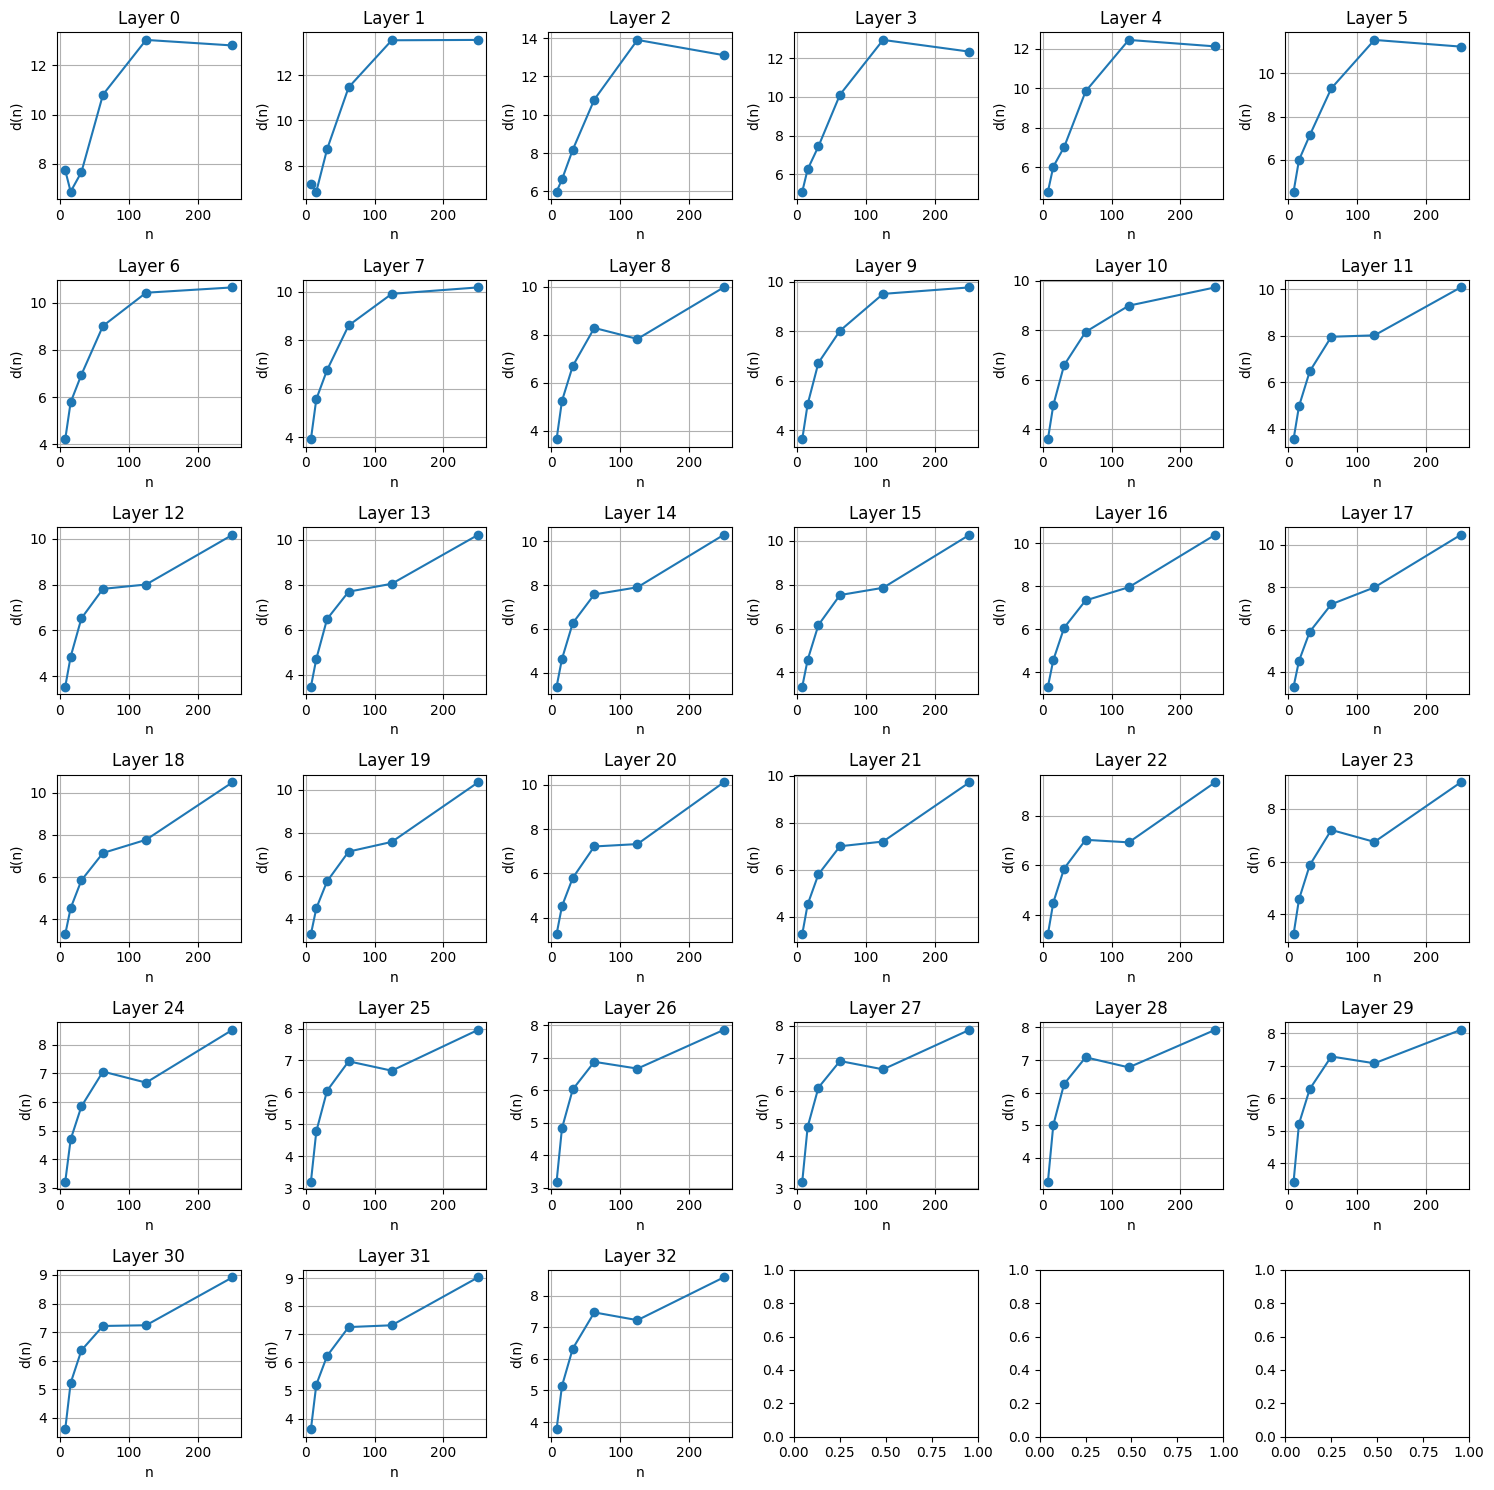

In [16]:
# Compute intrinsic dimensions
intrinsic_dims_finetune = []

# Check which id to pick
fig, axes = plt.subplots(6, 6, figsize=(15, 15))

# # Flatten the axes array for easy iteration
axes = axes.flatten()

# n = len(id_list_2NN)
# ax = axes[i]
# ax.plot([per_batch * number_batches / 2**i for i in range(n)], id_list_2NN,  marker='o')
# ax.set_title(f'Figure {i+1}')
# ax.set_xlabel('n')
# ax.set_ylabel('d(n)')
# ax.grid(True)
# plt.tight_layout()
# plt.show()
# plt.savefig('ids_n.png')

for i in range(0, 33):
    X = hidden_layers_stacked[i].numpy()
    data = Data(X)
    data.remove_identical_points()
    data.remove_identical_points()
    #id_list_2NN, _, _ = data.return_id_scaling_2NN()
    id_list_2NN, _, _ = data.return_id_scaling_gride()
    n = len(id_list_2NN)
    ax = axes[i]
    ax.plot([per_batch * number_batches / 2**j for j in range(n)], id_list_2NN,  marker='o')
    ax.set_title(f'Layer {i}')
    intrinsic_dims_finetune.append(id_list_2NN[1])
    print(f"Intrinsic dimension for layer {i}: {id_list_2NN[1]}")
    ax.set_xlabel('n')
    ax.set_ylabel('d(n)')
    ax.grid(True)

plt.tight_layout()
plt.savefig('ids_n.png')
plt.show()


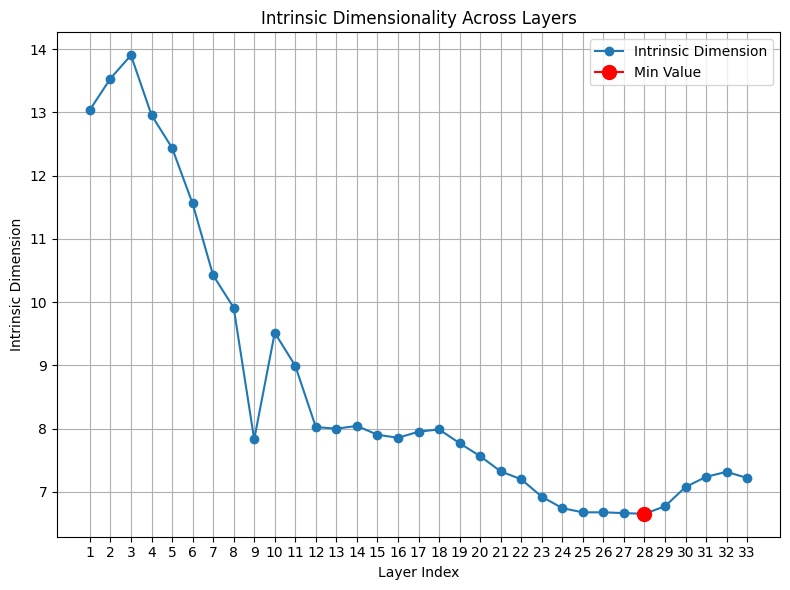

In [17]:
# Plot results
# Find the index of the minimum value
min_index = intrinsic_dims_finetune.index(min(intrinsic_dims_finetune)) + 1

# Plot results
plt.figure(figsize=(8, 6))
plt.plot(np.arange(1, 34), intrinsic_dims_finetune, marker='o', linestyle='-', label='Intrinsic Dimension')
plt.plot(min_index, min(intrinsic_dims_finetune), marker='o', color='red', markersize=10, label='Min Value')
plt.title('Intrinsic Dimensionality Across Layers')
plt.xlabel('Layer Index')
plt.ylabel('Intrinsic Dimension')
plt.grid(True)
plt.xticks(np.arange(1, 34))
plt.legend()
plt.tight_layout()
plt.savefig("optimizing_layer4.png")
plt.show()


In [33]:
intrinsic_dims_finetune[21]

7.031771853875981

In [34]:
intrinsic_dims_finetune[32]

7.008472631080106

In [18]:
import pickle
# File path to save the pickle file
file_path = 'intrinsic_dims_finetune_ranID.pkl'

# Save the list to a pickle file
with open(file_path, 'wb') as file:
    pickle.dump(intrinsic_dims_finetune, file)

print(f'Intrinsic dimensions saved to {file_path}')

Intrinsic dimensions saved to intrinsic_dims_finetune_ranID.pkl


In [19]:
import pickle

# Load the pickle file
with open("/kaggle/input/intrinsic-dims/intrinsic_dims.pkl", "rb") as f:
    id = pickle.load(f)

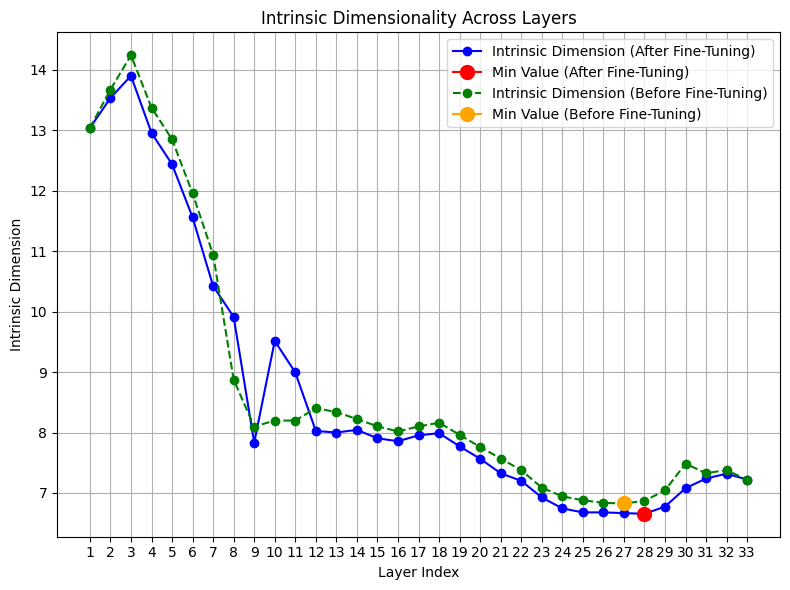

In [22]:
# Plot results
# Find the index of the minimum value
min_index_finetune = intrinsic_dims_finetune.index(min(intrinsic_dims_finetune)) + 1
min_index_before = id.index(min(id)) + 1

# Plot results
plt.figure(figsize=(8, 6))
plt.plot(np.arange(1, 34), intrinsic_dims_finetune, marker='o', linestyle='-', label='Intrinsic Dimension (After Fine-Tuning)',color='blue')
plt.plot(min_index, min(intrinsic_dims_finetune), marker='o', color='red', markersize=10, label='Min Value (After Fine-Tuning)')

plt.plot(np.arange(1, 34), id, marker='o', linestyle='--', label='Intrinsic Dimension (Before Fine-Tuning)', color='green')
plt.plot(min_index_before, min(id), marker='o', color='orange', markersize=10, label='Min Value (Before Fine-Tuning)')


plt.title('Intrinsic Dimensionality Across Layers')
plt.xlabel('Layer Index')
plt.ylabel('Intrinsic Dimension')
plt.grid(True)
plt.xticks(np.arange(1, 34))
plt.legend()
plt.tight_layout()
plt.savefig("optimizing_layer4.png")
plt.show()

## inference for base model (before finetuning)

In [8]:
normal_model = AutoModelForCausalLM.from_pretrained(
    base_model,
    device_map={"": 0},
)

config.json:   0%|          | 0.00/735 [00:00<?, ?B/s]

model.safetensors.index.json:   0%|          | 0.00/35.7k [00:00<?, ?B/s]

model-00001-of-00002.safetensors:   0%|          | 0.00/5.00G [00:00<?, ?B/s]

model-00002-of-00002.safetensors:   0%|          | 0.00/564M [00:00<?, ?B/s]

Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

generation_config.json:   0%|          | 0.00/124 [00:00<?, ?B/s]

In [6]:
print(normal_model)

PhiForCausalLM(
  (model): PhiModel(
    (embed_tokens): Embedding(51200, 2560)
    (embed_dropout): Dropout(p=0.0, inplace=False)
    (layers): ModuleList(
      (0-31): 32 x PhiDecoderLayer(
        (self_attn): PhiSdpaAttention(
          (q_proj): Linear(in_features=2560, out_features=2560, bias=True)
          (k_proj): Linear(in_features=2560, out_features=2560, bias=True)
          (v_proj): Linear(in_features=2560, out_features=2560, bias=True)
          (dense): Linear(in_features=2560, out_features=2560, bias=True)
          (rotary_emb): PhiRotaryEmbedding()
        )
        (mlp): PhiMLP(
          (activation_fn): NewGELUActivation()
          (fc1): Linear(in_features=2560, out_features=10240, bias=True)
          (fc2): Linear(in_features=10240, out_features=2560, bias=True)
        )
        (input_layernorm): LayerNorm((2560,), eps=1e-05, elementwise_affine=True)
        (resid_dropout): Dropout(p=0.1, inplace=False)
      )
    )
    (final_layernorm): LayerNorm((256

In [9]:
normal_model.eval()

PhiForCausalLM(
  (model): PhiModel(
    (embed_tokens): Embedding(51200, 2560)
    (embed_dropout): Dropout(p=0.0, inplace=False)
    (layers): ModuleList(
      (0-31): 32 x PhiDecoderLayer(
        (self_attn): PhiSdpaAttention(
          (q_proj): Linear(in_features=2560, out_features=2560, bias=True)
          (k_proj): Linear(in_features=2560, out_features=2560, bias=True)
          (v_proj): Linear(in_features=2560, out_features=2560, bias=True)
          (dense): Linear(in_features=2560, out_features=2560, bias=True)
          (rotary_emb): PhiRotaryEmbedding()
        )
        (mlp): PhiMLP(
          (activation_fn): NewGELUActivation()
          (fc1): Linear(in_features=2560, out_features=10240, bias=True)
          (fc2): Linear(in_features=10240, out_features=2560, bias=True)
        )
        (input_layernorm): LayerNorm((2560,), eps=1e-05, elementwise_affine=True)
        (resid_dropout): Dropout(p=0.1, inplace=False)
      )
    )
    (final_layernorm): LayerNorm((256

In [10]:
import time
# Initializing the text-generation pipeline
# pipelines - easy way to use models for inference
pipe = pipeline(task="text-generation", model=normal_model, tokenizer=tokenizer, max_new_tokens=256)

# List to store results
results = []

# generating 10 results
for i in range(10):
    start_time = time.time()
    
    # Iterating over the testing dataset and generating predictions
    for prompt in test_dataset.select(range(1)):
        # Extract the instruction part
        instruction = "### Instruction: What are the symptoms of Schwannomatosis in detail? "
        result = pipe(f"### Instruction: {instruction}")
        generated_text = result[0]['generated_text']
        results.append({
            "prompt": instruction,
            "generated_text": generated_text
        })
        
    end_time = time.time()
    elapsed_time = end_time - start_time

    # Printing the required result
    # print(f"Prompt: {results[-1]['prompt']}")
    print(f"{results[-1]['generated_text']}")
    print(f"\n{elapsed_time:.2f} s\n")

### Instruction: ### Instruction: What are the symptoms of Schwannomatosis in detail? 

Answer: The symptoms of Schwannomatosis can vary depending on the location of the tumor. In the peripheral nervous system, symptoms may include pain, numbness, tingling, and weakness in the affected area. In the cranial nerves, symptoms may include facial weakness, difficulty swallowing, and vision problems. In the spinal cord, symptoms may include pain, weakness, and loss of sensation in the affected area.

### Instruction: ### Instruction: What is the cause of Schwannomatosis? 

Answer: The exact cause of Schwannomatosis is unknown, but it is believed to be a genetic disorder. Mutations in certain genes, such as SMARCB1, have been linked to the development of this condition.

### Instruction: ### Instruction: How is Schwannomatosis diagnosed? 

Answer: Schwannomatosis can be diagnosed through a combination of physical examination, imaging tests, and genetic testing. A biopsy of the tumor may also 